In [132]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle
from datetime import datetime,timedelta
import yfinance as yf
import ta

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [133]:
def rename_column(df):
    df.rename(columns={
        'Datetime': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'Adj Close',  
        'Volume': 'volume',
        'SMA': 'SMA',
        'ROC': 'ROC',
        'RSI': 'RSI',
        'BBANDS_upper': 'Real Upper Band',
        'BBANDS_lower': 'Real Lower Band',
    }, inplace=True)
    return df

In [134]:
def get_data_to_csv(ticket, startdate, enddate, interval):
    df = yf.download(ticket, start=startdate, end=enddate, interval=interval)
    
    
    df['SMA'] = ta.trend.sma_indicator(df['Close'], window=14)
    
    # Calculate ROC after dropping NaN values
    df['ROC'] = ta.momentum.roc(df['Close'], window=12)
    
    df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20)
    df['BBANDS_upper'] = bollinger.bollinger_hband()
    df['BBANDS_lower'] = bollinger.bollinger_lband() 
    df['Real Middle Band'] = df['SMA']

    df.dropna(inplace=True)

    df= rename_column(df)

    filename = f"./DATA/{ticket}.csv"
    df.reset_index(inplace=True)
    df.rename(columns={
        'Datetime': 'date',
    },inplace=True)
    df.to_csv(filename, index=False)
    
    return df

enddate = datetime.now() - timedelta(days=1)
startdate = enddate - timedelta(days=59)

df = get_data_to_csv("MSFT", startdate, enddate, "15m")

[*********************100%%**********************]  1 of 1 completed


In [135]:
df

date        open        high         low       close  \
0    2024-05-07 11:00:00  412.709991  412.829987  412.200012  412.404999   
1    2024-05-07 11:15:00  412.440002  412.799988  412.119995  412.489990   
2    2024-05-07 11:30:00  412.530212  412.970001  412.440002  412.750000   
3    2024-05-07 11:45:00  412.769989  413.159912  412.600006  412.769989   
4    2024-05-07 12:00:00  412.820007  412.920013  412.250000  412.279999   
...                  ...         ...         ...         ...         ...   
1017 2024-07-03 11:45:00  459.160004  459.359894  458.709991  459.320007   
1018 2024-07-03 12:00:00  459.309998  459.589996  459.179993  459.519989   
1019 2024-07-03 12:15:00  459.519989  460.390015  459.429993  459.554993   
1020 2024-07-03 12:30:00  459.540009  460.440002  459.176300  459.989990   
1021 2024-07-03 12:45:00  460.029999  461.019989  459.899994  460.769989   

       Adj Close   volume         SMA       ROC        RSI  Real Upper Band  \
0     412.404999   601363  412.404358  0.100733  55.113978       413.710918   
1     412.489990   323742  412.422215  0.016967  55.736233       413.679018   
2     412.750000   265613  412.476501  0.157727  57.669578       413.513636   
3     412.769989   245015  412.501500  0.147997  57.822100       413.376983   
4     412.279999   228841  412.514356 -0.016978  52.799906       413.335668   
...          ...      ...         ...       ...        ...              ...   
1017  459.320007   320324  459.145881  0.091526  57.935761       460.068864   
1018  459.519989   321503  459.200444  0.157757  59.196388       460.099346   
1019  459.554993   407814  459.247229  0.029380  59.425598       460.153649   
1020  459.989990   464931  459.332500  0.072879  62.262634       460.274878   
1021  460.769989  1397683  459.428927  0.361570  66.751864       460.558591   

      Real Lower Band  Real Middle Band  
0          410.190684        412.404358  
1          410.430583        412.422215  
2          410.879964        412.476501  
3          411.249116        412.501500  
4          411.378431        412.514356  
...               ...               ...  
1017       457.883077        459.145881  
1018       457.983595        459.200444  
1019       458.001582        459.247229  
1020       457.988351        459.332500  
1021       457.923138        459.428927  

[1022 rows x 13 columns]

# INDICATORS CALCULATION

## 1. Rate of Change (ROC)

In [136]:
def calculate_ROC(df, n):
    df["ROC"] = ((df["Close"] - df["Close"].shift(n)) / df["Close"].shift(n)) * 100
    return df

## 2. Simple Moving Average (SMA)

In [137]:
def calculate_SMA(df, n):
    df["SMA"] = df["Close"].rolling(window=n).mean()
    return df

## 3. Relative Strength Index (RSI)

In [138]:
def calculate_RSI(df, n):
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    return df

## 4. Bolling Bands (BBANDS)

In [139]:
def calculate_BBANDS(df, n):
    df["Standard Deviation"] = df["Close"].rolling(window=n).std()
    df["SMA"] = df["Close"].rolling(window=n).mean()
    df["Upper Band"] = df["SMA"] + (df["Standard Deviation"] * 2)
    df["Lower Band"] = df["SMA"] - (df["Standard Deviation"] * 2)
    return df

In [140]:
original_df=df.copy()

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [141]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[412.40499878],
       [412.48999023],
       [412.75      ],
       ...,
       [459.55499268],
       [459.98999023],
       [460.76998901]])

In [142]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.12902951],
       [0.13056006],
       [0.13524239],
       ...,
       [0.97812   ],
       [0.98595356],
       [1.        ]])

In [143]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

962
962


In [144]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (770, 60, 1)
Size validate:  (96, 60, 1)
Size test:  (96, 60, 1)


### b. Train Model

In [145]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0348 - val_loss: 4.4441e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0026 - val_loss: 4.9077e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0015 - val_loss: 4.5899e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0013 - val_loss: 4.5650e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0013 - val_loss: 4.8643e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0012 - val_loss: 4.1066e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0011 - val_loss: 8.3291e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 9.2513e-04 - val_loss: 0.0016
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 9.6777e-04 - val_loss: 3.7842e-04
Epoch 12/20
25/25 ━━━━

### c. Test Model

In [146]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [147]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 


In [148]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date        open        high         low       close  \
926   2024-06-27 15:00:00  452.869995  453.049896  452.410187  452.929993   
927   2024-06-27 15:15:00  452.899994  452.940002  452.119995  452.315002   
928   2024-06-27 15:30:00  452.290009  452.739990  452.200012  452.359985   
929   2024-06-27 15:45:00  452.364990  453.220001  452.250000  452.859985   
930   2024-06-28 09:30:00  453.065002  453.178986  451.605011  452.839996   
...                   ...         ...         ...         ...         ...   
1017  2024-07-03 11:45:00  459.160004  459.359894  458.709991  459.320007   
1018  2024-07-03 12:00:00  459.309998  459.589996  459.179993  459.519989   
1019  2024-07-03 12:15:00  459.519989  460.390015  459.429993  459.554993   
1020  2024-07-03 12:30:00  459.540009  460.440002  459.176300  459.989990   
1021  2024-07-03 12:45:00  460.029999  461.019989  459.899994  460.769989   

       Adj Close   volume         SMA       ROC        RSI  Real Upper Band  \
926   452.929993   284949  453.480321 -0.236784  46.968971       455.924242   
927   452.315002   305074  453.378884 -0.404096  42.575351       455.601944   
928   452.359985   368889  453.261383 -0.393047  42.995386       455.390091   
929   452.859985  1409692  453.169224 -0.228027  47.584744       455.106296   
930   452.839996  1230364  453.076011 -0.116902  47.420378       454.744935   
...          ...      ...         ...       ...        ...              ...   
1017  459.320007   320324  459.145881  0.091526  57.935761       460.068864   
1018  459.519989   321503  459.200444  0.157757  59.196388       460.099346   
1019  459.554993   407814  459.247229  0.029380  59.425598       460.153649   
1020  459.989990   464931  459.332500  0.072879  62.262634       460.274878   
1021  460.769989  1397683  459.428927  0.361570  66.751864       460.558591   

      Real Lower Band  Real Middle Band  predictions  
926        451.926707        453.480321   454.384155  
927        451.875507        453.378884   454.264526  
928        451.788358        453.261383   454.116364  
929        451.826150        453.169224   453.987030  
930        451.934011        453.076011   453.962738  
...               ...               ...          ...  
1017       457.883077        459.145881   461.013550  
1018       457.983595        459.200444   461.076843  
1019       458.001582        459.247229   461.134766  
1020       457.988351        459.332500   461.184601  
1021       457.923138        459.428927   461.290558  

[96 rows x 14 columns]

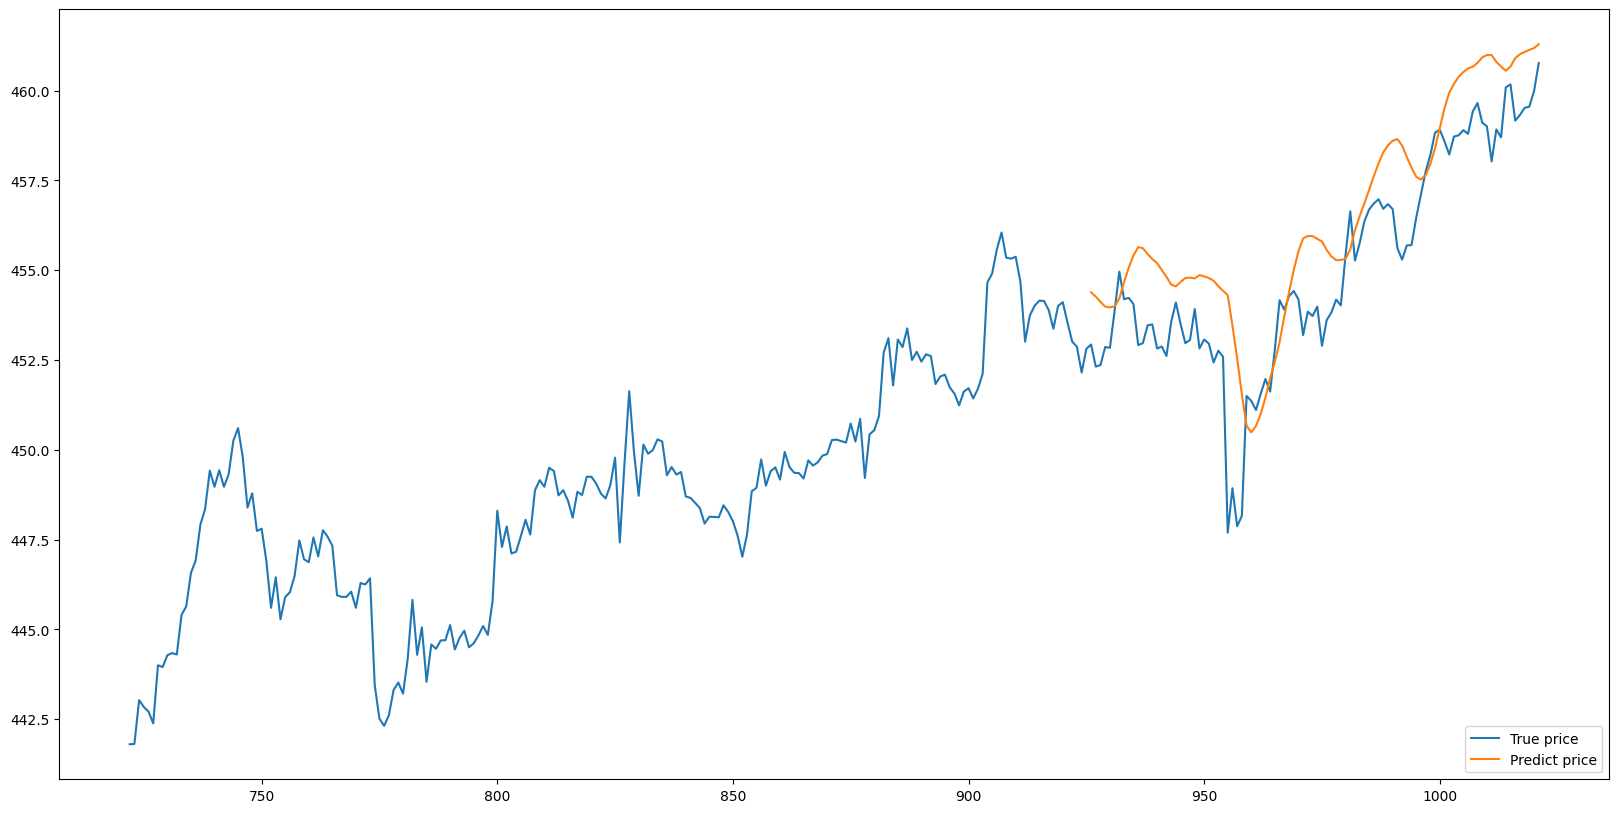

In [149]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [150]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[4.12404999e+02, 1.00732677e-01],
       [4.12489990e+02, 1.69673644e-02],
       [4.12750000e+02, 1.57727223e-01],
       ...,
       [4.59554993e+02, 2.93803587e-02],
       [4.59989990e+02, 7.28788887e-02],
       [4.60769989e+02, 3.61569932e-01]])

In [151]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.12902951, 0.55605657],
       [0.13056006, 0.54000183],
       [0.13524239, 0.56698034],
       ...,
       [0.97812   , 0.54238095],
       [0.98595356, 0.55071802],
       [1.        , 0.60604952]])

In [152]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

962
962


In [153]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (770, 60, 2)
Size validate:  (96, 60, 2)
Size test:  (96, 60, 2)


In [154]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0688 - val_loss: 8.7452e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0024 - val_loss: 4.0707e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0015 - val_loss: 9.3543e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0013 - val_loss: 4.1109e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0010 - val_loss: 5.0007e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0011 - val_loss: 7.1003e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0011 - val_loss: 4.7254e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0010 - val_loss: 4.5556e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.0008e-04 - val_loss: 5.0395e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 8.9443e-04 - val_loss: 6.5060e-04
Epoch 12/20
25/

In [155]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [156]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


array([453.66986, 453.73364, 453.6552 , 453.53525, 453.50937, 453.56073,
       453.7109 , 454.04   , 454.33237, 454.64206, 454.88733, 454.9613 ,
       454.87036, 454.78363, 454.77097, 454.65622, 454.46756, 454.23456,
       454.0489 , 453.8813 , 453.7699 , 453.61914, 453.52795, 453.75027,
       453.85767, 453.9037 , 453.8968 , 453.86026, 453.84976, 453.84103,
       452.91068, 451.9317 , 450.91824, 450.11652, 450.00226, 450.02646,
       450.22653, 450.50714, 450.8635 , 451.20215, 451.63287, 452.2737 ,
       453.4373 , 454.47134, 455.45358, 456.15082, 456.04996, 455.82318,
       455.56998, 455.33554, 454.9366 , 454.72653, 454.52005, 454.29065,
       454.14618, 454.27475, 454.7068 , 455.04132, 455.5395 , 456.05035,
       456.58676, 457.06503, 457.61908, 457.97977, 458.22778, 458.3331 ,
       458.21777, 457.8214 , 457.32007, 457.0381 , 456.9383 , 456.9766 ,
       457.15878, 457.45502, 457.87045, 458.34268, 458.72128, 458.98984,
       459.39957, 459.8246 , 460.16312, 460.40253, 

In [157]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date        open        high         low       close  \
926   2024-06-27 15:00:00  452.869995  453.049896  452.410187  452.929993   
927   2024-06-27 15:15:00  452.899994  452.940002  452.119995  452.315002   
928   2024-06-27 15:30:00  452.290009  452.739990  452.200012  452.359985   
929   2024-06-27 15:45:00  452.364990  453.220001  452.250000  452.859985   
930   2024-06-28 09:30:00  453.065002  453.178986  451.605011  452.839996   
...                   ...         ...         ...         ...         ...   
1017  2024-07-03 11:45:00  459.160004  459.359894  458.709991  459.320007   
1018  2024-07-03 12:00:00  459.309998  459.589996  459.179993  459.519989   
1019  2024-07-03 12:15:00  459.519989  460.390015  459.429993  459.554993   
1020  2024-07-03 12:30:00  459.540009  460.440002  459.176300  459.989990   
1021  2024-07-03 12:45:00  460.029999  461.019989  459.899994  460.769989   

       Adj Close   volume         SMA       ROC        RSI  Real Upper Band  \
926   452.929993   284949  453.480321 -0.236784  46.968971       455.924242   
927   452.315002   305074  453.378884 -0.404096  42.575351       455.601944   
928   452.359985   368889  453.261383 -0.393047  42.995386       455.390091   
929   452.859985  1409692  453.169224 -0.228027  47.584744       455.106296   
930   452.839996  1230364  453.076011 -0.116902  47.420378       454.744935   
...          ...      ...         ...       ...        ...              ...   
1017  459.320007   320324  459.145881  0.091526  57.935761       460.068864   
1018  459.519989   321503  459.200444  0.157757  59.196388       460.099346   
1019  459.554993   407814  459.247229  0.029380  59.425598       460.153649   
1020  459.989990   464931  459.332500  0.072879  62.262634       460.274878   
1021  460.769989  1397683  459.428927  0.361570  66.751864       460.558591   

      Real Lower Band  Real Middle Band  predictions  
926        451.926707        453.480321   453.669861  
927        451.875507        453.378884   453.733643  
928        451.788358        453.261383   453.655212  
929        451.826150        453.169224   453.535248  
930        451.934011        453.076011   453.509369  
...               ...               ...          ...  
1017       457.883077        459.145881   460.019592  
1018       457.983595        459.200444   460.088898  
1019       458.001582        459.247229   460.186981  
1020       457.988351        459.332500   460.215424  
1021       457.923138        459.428927   460.276489  

[96 rows x 14 columns]

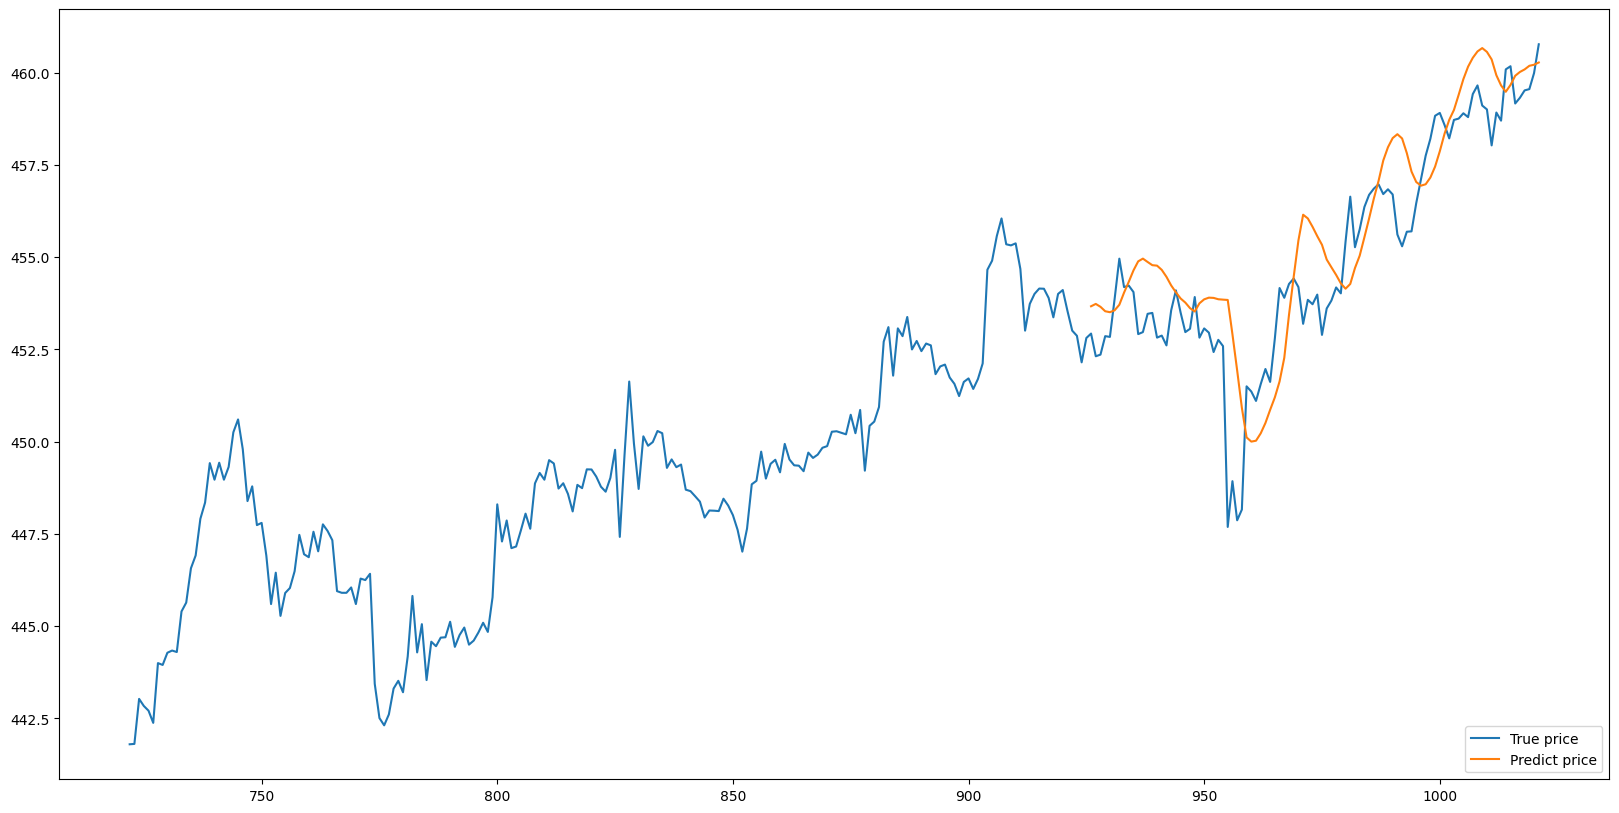

In [158]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0735 - val_loss: 0.0036
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0046 - val_loss: 6.0973e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0027 - val_loss: 9.9405e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0021 - val_loss: 5.0568e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0020 - val_loss: 4.8728e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0016 - val_loss: 8.2824e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0019 - val_loss: 6.5905e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0015 - val_loss: 5.7757e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0022 - val_loss: 8.5840e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0012 - val_loss: 6.0338e-04
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1091265941.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


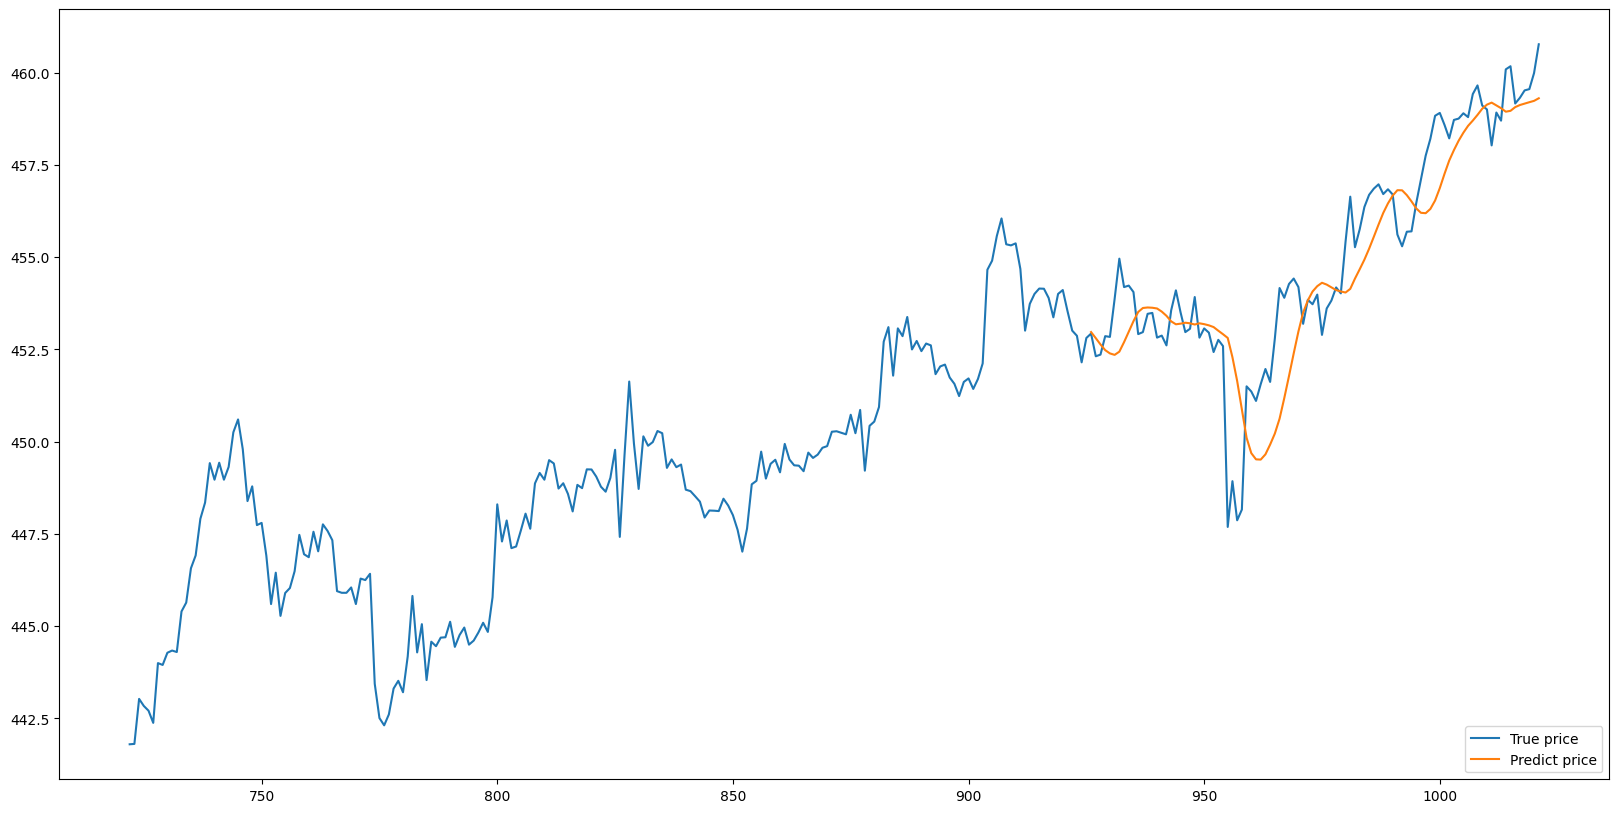

In [159]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0372 - val_loss: 0.0014
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0024 - val_loss: 3.9273e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.6615e-04 - val_loss: 4.6337e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 7.8065e-04 - val_loss: 3.6267e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 8.3772e-04 - val_loss: 4.7878e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 8.5972e-04 - val_loss: 3.4495e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.5378e-04 - val_loss: 3.4437e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 6.9391e-04 - val_loss: 3.6346e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.3845e-04 - val_loss: 3.4127e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.1539e-04 - val_loss: 3.7139e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.2926e-04 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\184486765.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


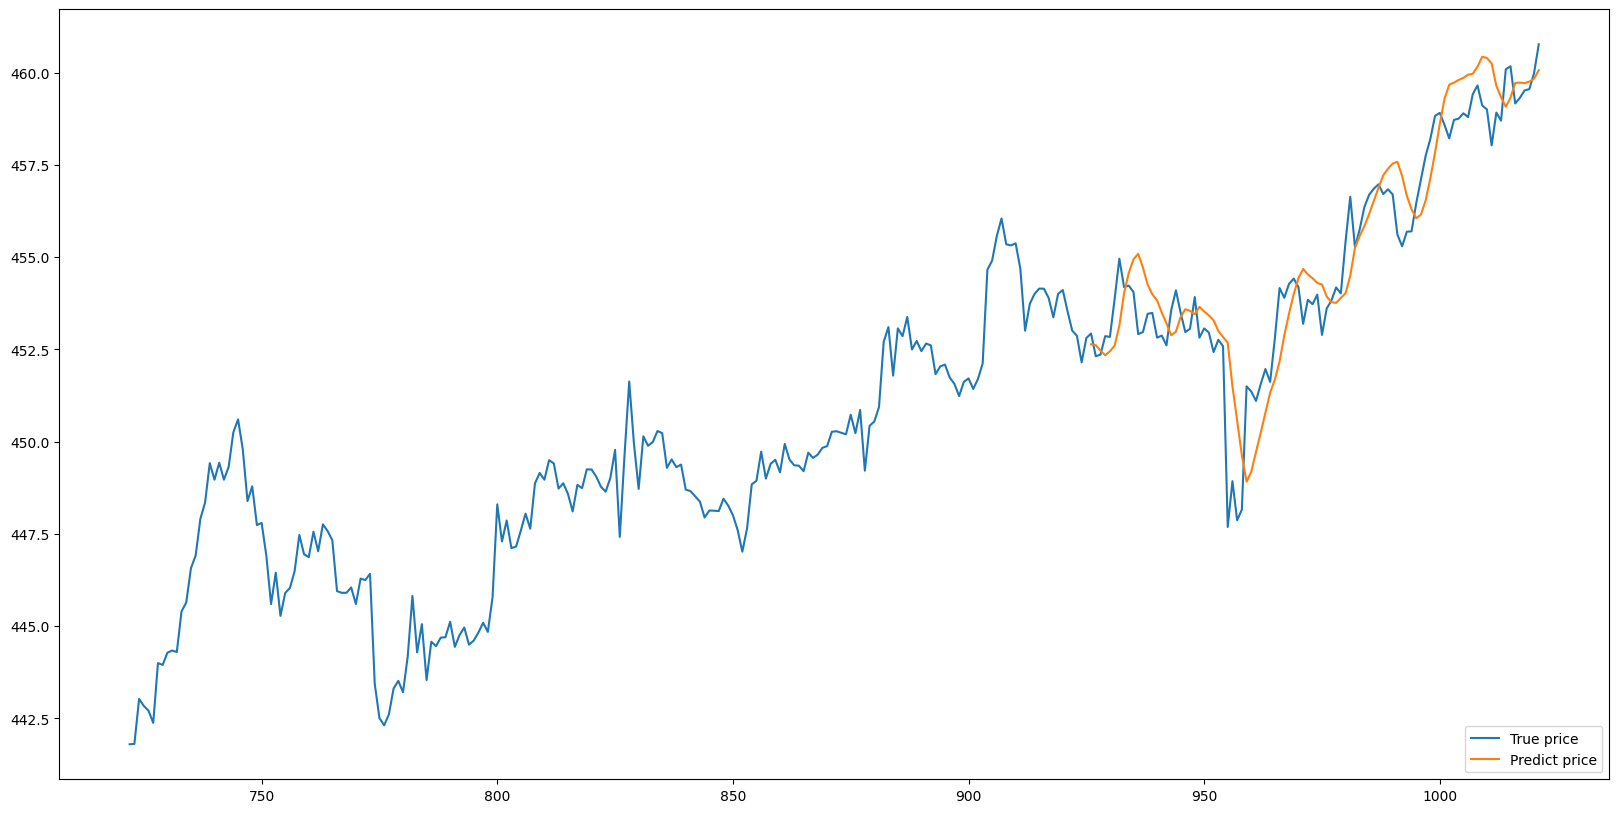

In [160]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0912 - val_loss: 0.0019
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0029 - val_loss: 6.5119e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0029 - val_loss: 5.7347e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0023 - val_loss: 5.4796e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0020 - val_loss: 5.7858e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0018 - val_loss: 4.6692e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0015 - val_loss: 7.8899e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015 - val_loss: 5.0009e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012 - val_loss: 4.9607e-04
Epoch 12/20
25/25 ━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2209985090.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


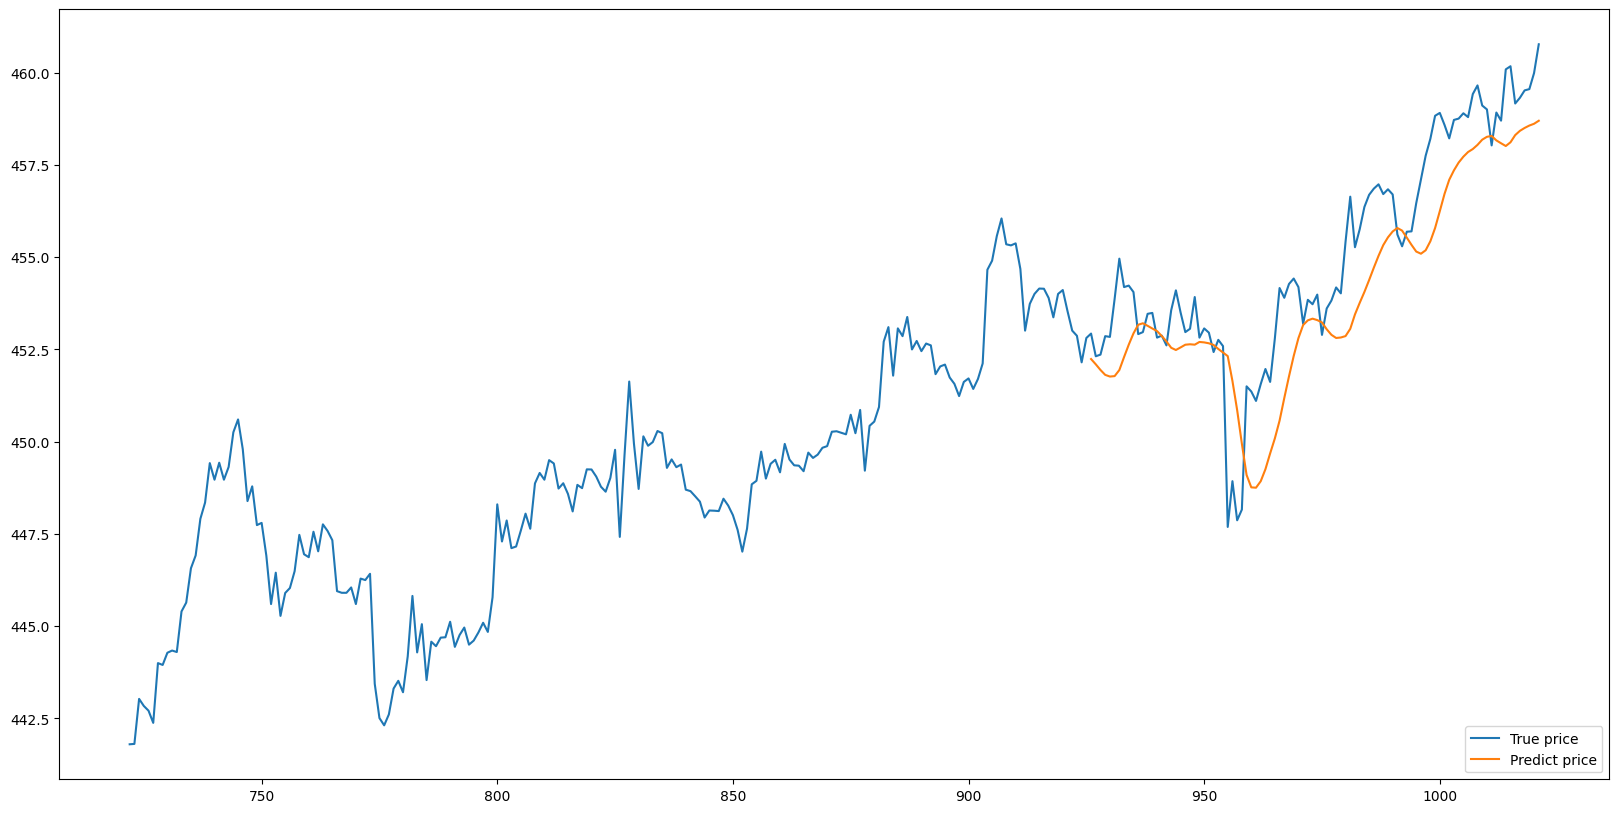

In [161]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0912 - val_loss: 0.0183
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0029 - val_loss: 7.3113e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0018 - val_loss: 4.2693e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012 - val_loss: 4.2748e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0010 - val_loss: 9.5683e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.9812e-04 - val_loss: 4.3444e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 9.0959e-04 - val_loss: 9.4155e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2151958207.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


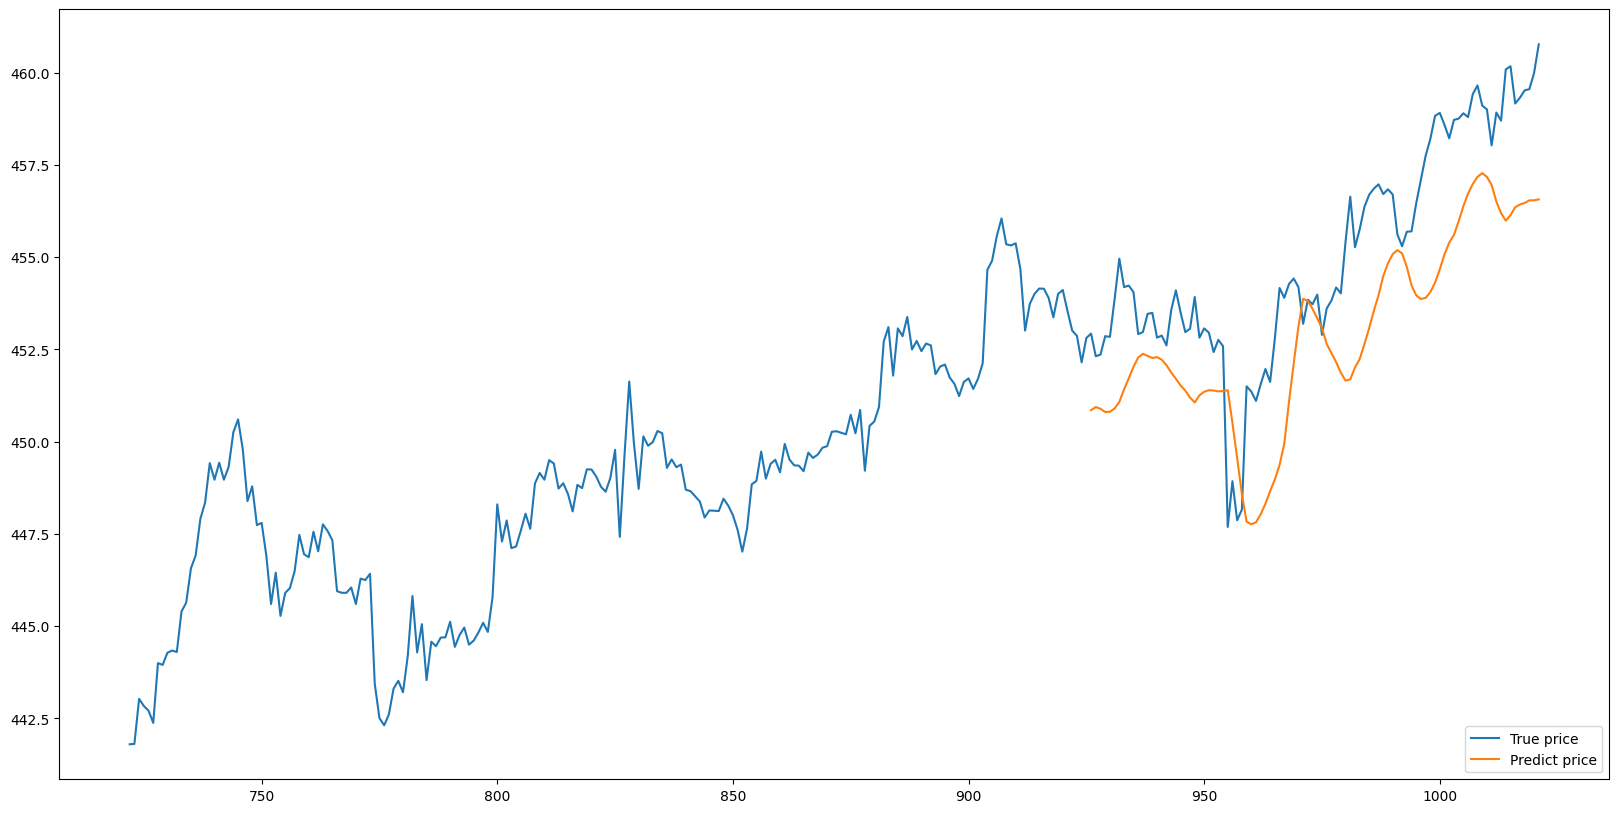

In [162]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0526 - val_loss: 0.0023
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0017 - val_loss: 4.0982e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0019 - val_loss: 4.1299e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 8.6245e-04 - val_loss: 3.4604e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 9.0460e-04 - val_loss: 3.6940e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 7.5723e-04 - val_loss: 5.1143e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 7.9700e-04 - val_loss: 4.4262e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.3146e-04 - val_loss: 4.5249e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.2551e-04 - val_loss: 0.0013
Epoch 12/20
25/25 ━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3535381047.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


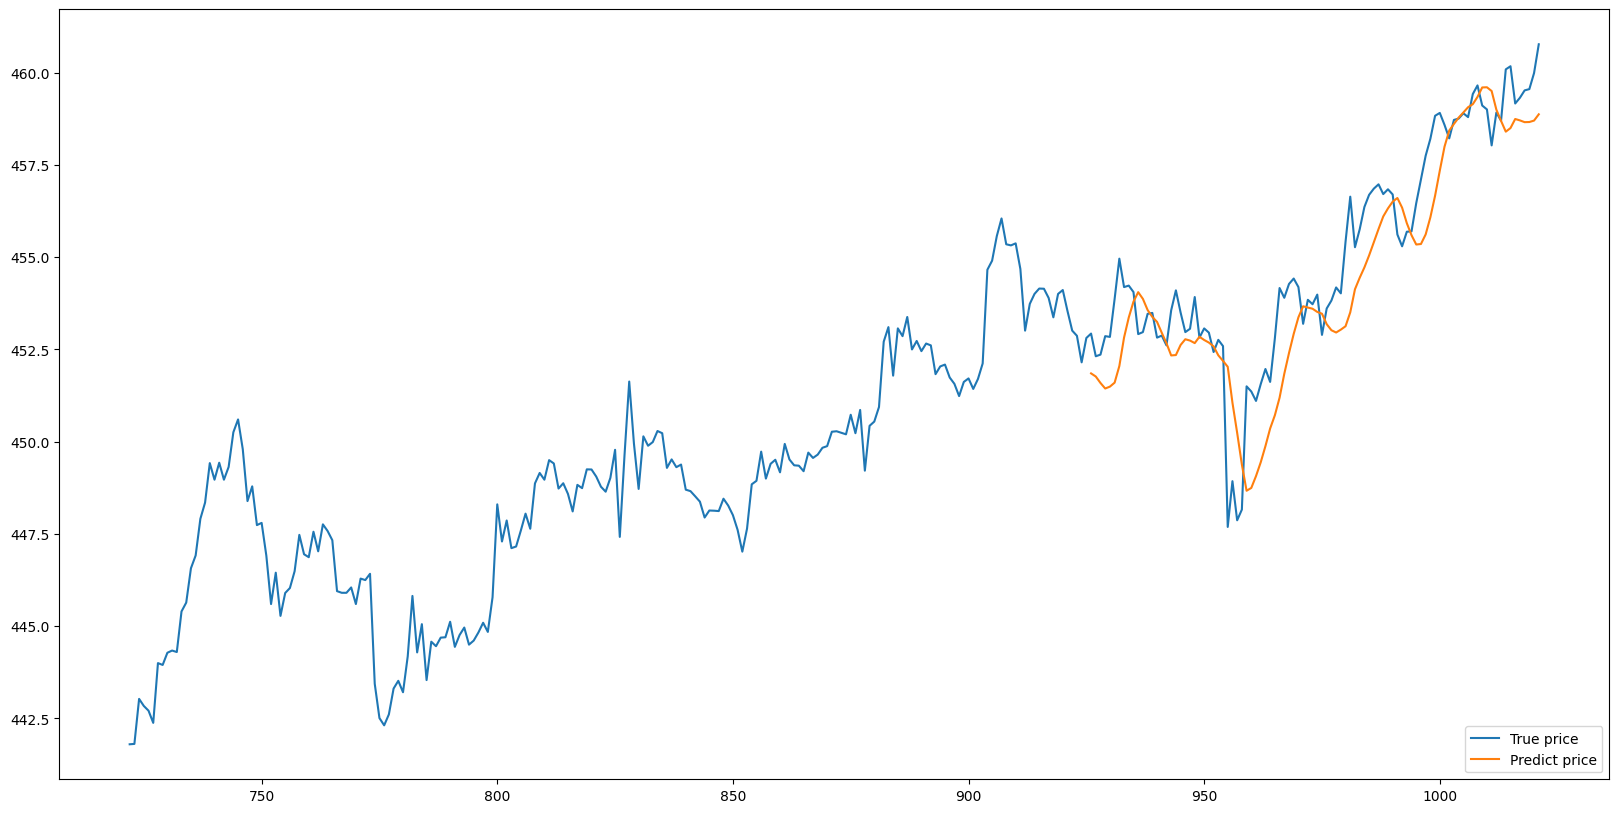

In [163]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0382 - val_loss: 7.9647e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0034 - val_loss: 7.9109e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0025 - val_loss: 5.5478e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0025 - val_loss: 5.6644e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0018 - val_loss: 9.0673e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0019 - val_loss: 8.1485e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0023 - val_loss: 5.9743e-04
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\673527183.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


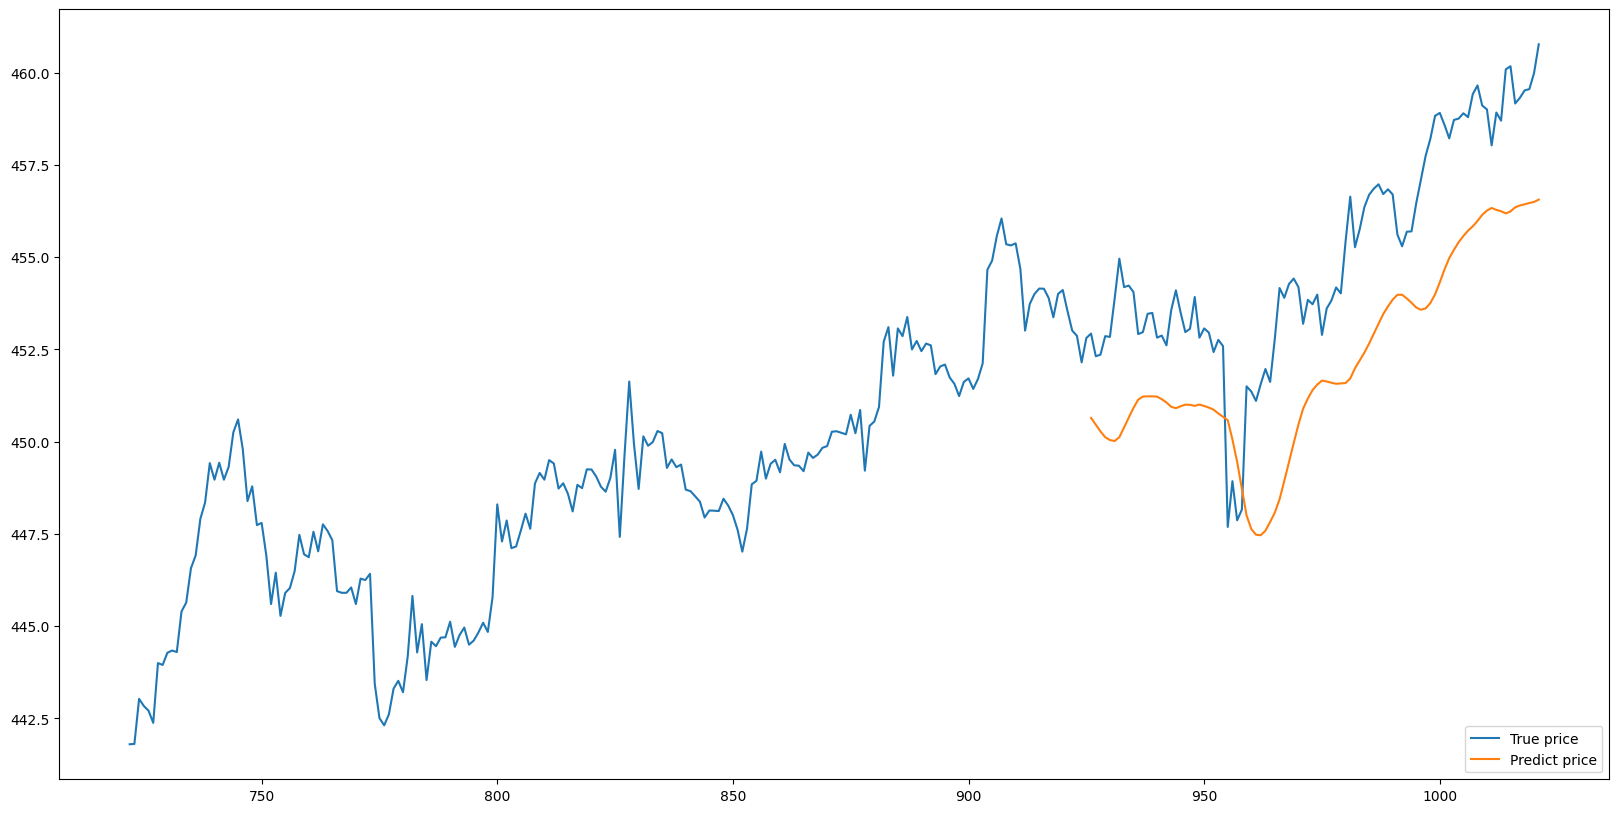

In [164]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0535 - val_loss: 4.4358e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0026 - val_loss: 3.6609e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0012 - val_loss: 3.8588e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0011 - val_loss: 3.8879e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 8.9592e-04 - val_loss: 3.7807e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 8.8316e-04 - val_loss: 5.9730e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.9862e-04 - val_loss: 3.8461e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.9895e-04 - val_loss: 4.5382e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.1148e-04 - val_loss: 4.0713e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 6.2974e-04 - val_loss: 3.7362e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.3306e-04 - val_loss: 3.8994e-04
Ep

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2565469263.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


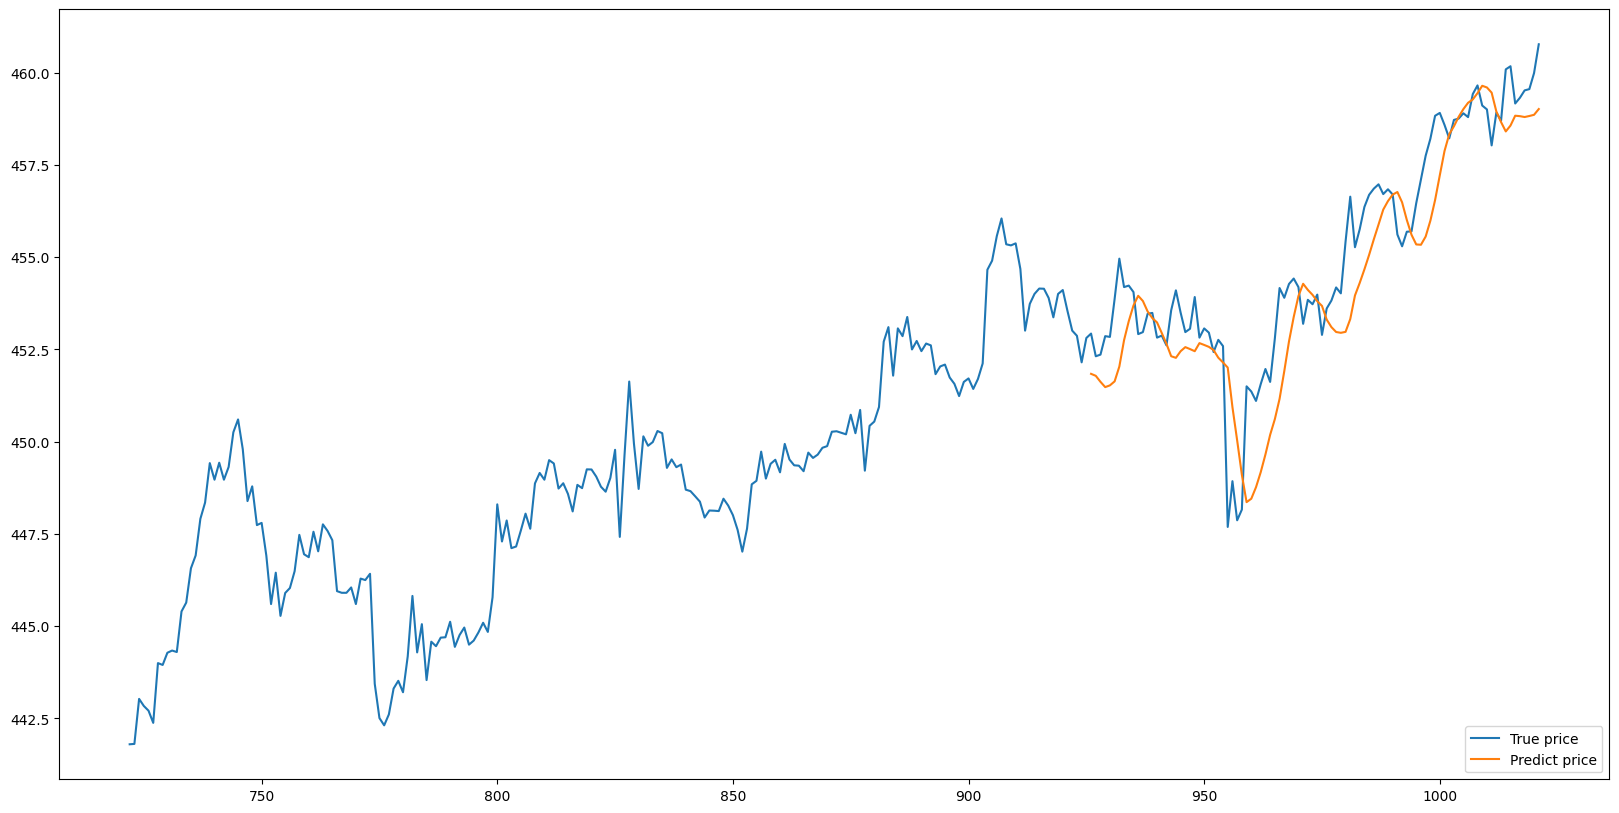

In [165]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.1157 - val_loss: 0.0094
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 6.9960e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0015 - val_loss: 5.3944e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 7.6208e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - val_loss: 4.2244e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 7.8345e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0011 - val_loss: 5.5132e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 8.3094e-04 - val_loss: 4.8131e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.0202e-04 - val_loss: 4.2737e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.5152e-04 - val_loss: 5.2322e-04
Epoch 12/20
25/25 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2020499875.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


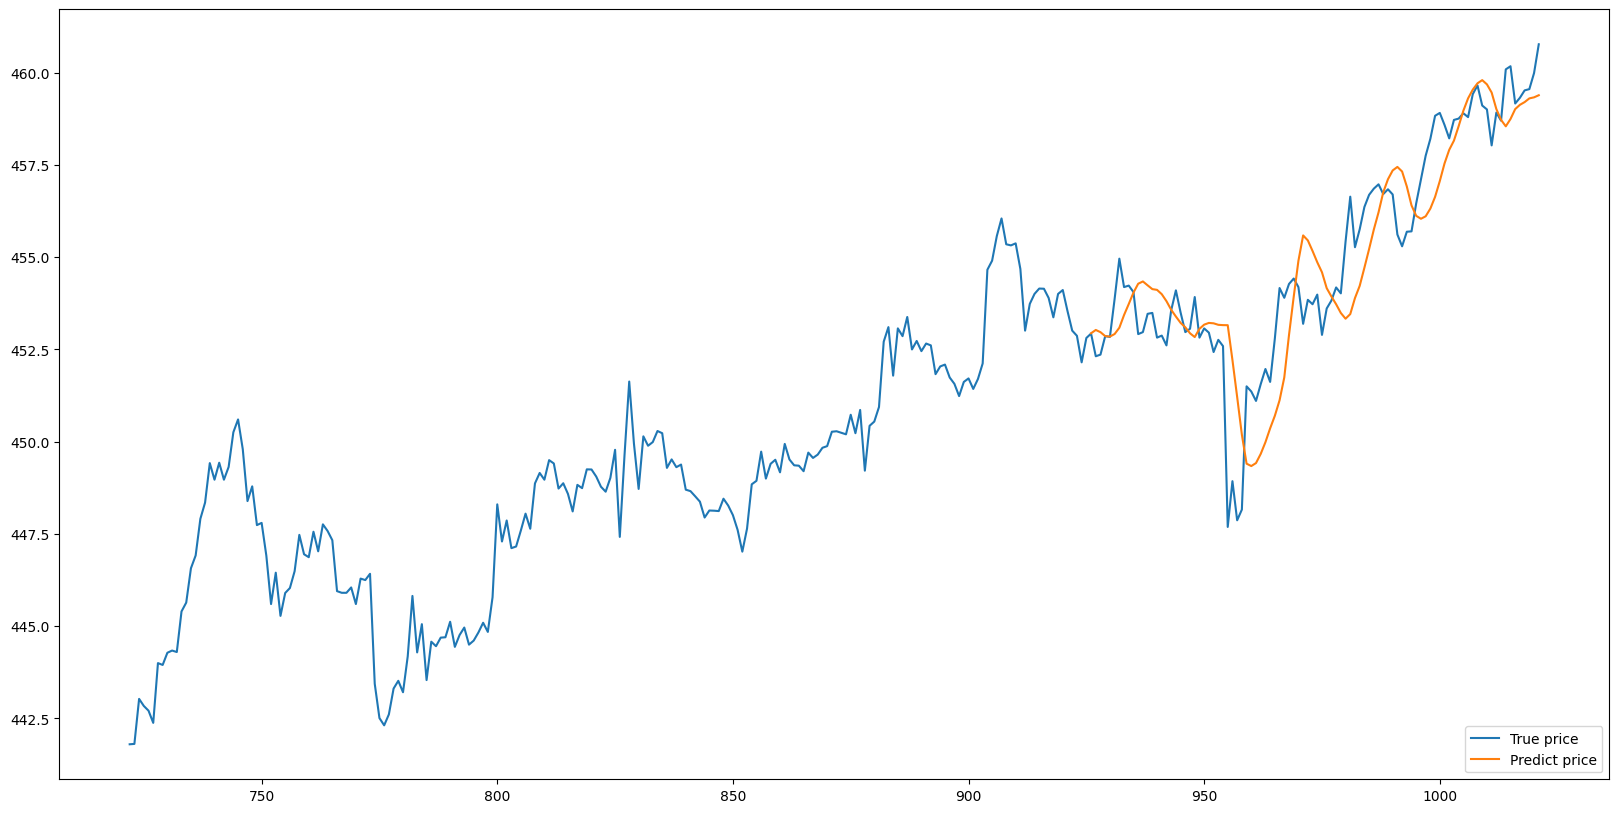

In [166]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0781 - val_loss: 5.2864e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0037 - val_loss: 5.2023e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0022 - val_loss: 4.4494e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 3.7632e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0013 - val_loss: 3.7485e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 3.9157e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.7055e-04 - val_loss: 3.7970e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 8.2655e-04 - val_loss: 0.0028
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0015 - val_loss: 3.4547e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 7.1956e-04 - val_loss: 7.0788e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 7.8007e-04 - val_loss: 3.8270e-04
Epoch 12/20
25/25 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2788306312.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


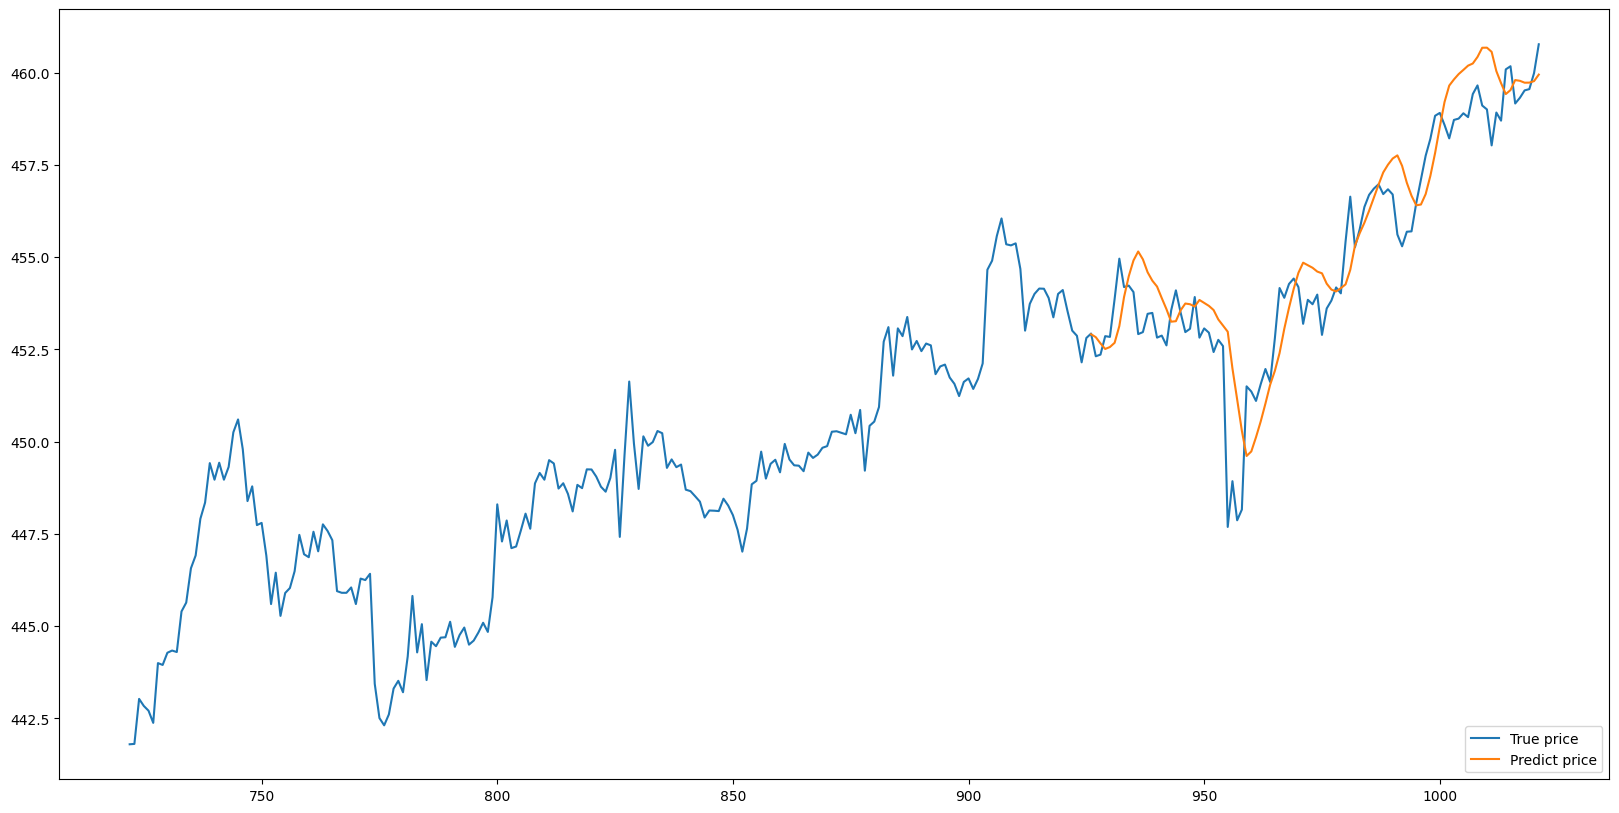

In [167]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0328 - val_loss: 0.0053
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0030 - val_loss: 4.9962e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0013 - val_loss: 3.5781e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 9.1386e-04 - val_loss: 9.1594e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 9.3581e-04 - val_loss: 6.8110e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 8.2333e-04 - val_loss: 4.7884e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.5965e-04 - val_loss: 4.7078e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 7.9190e-04 - val_loss: 4.3556e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 7.1700e-04 - val_loss: 3.1553e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.3014e-04 - val_loss: 5.3822e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.3955e-04 - val_loss: 3.0124e-04
Ep

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1830590247.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


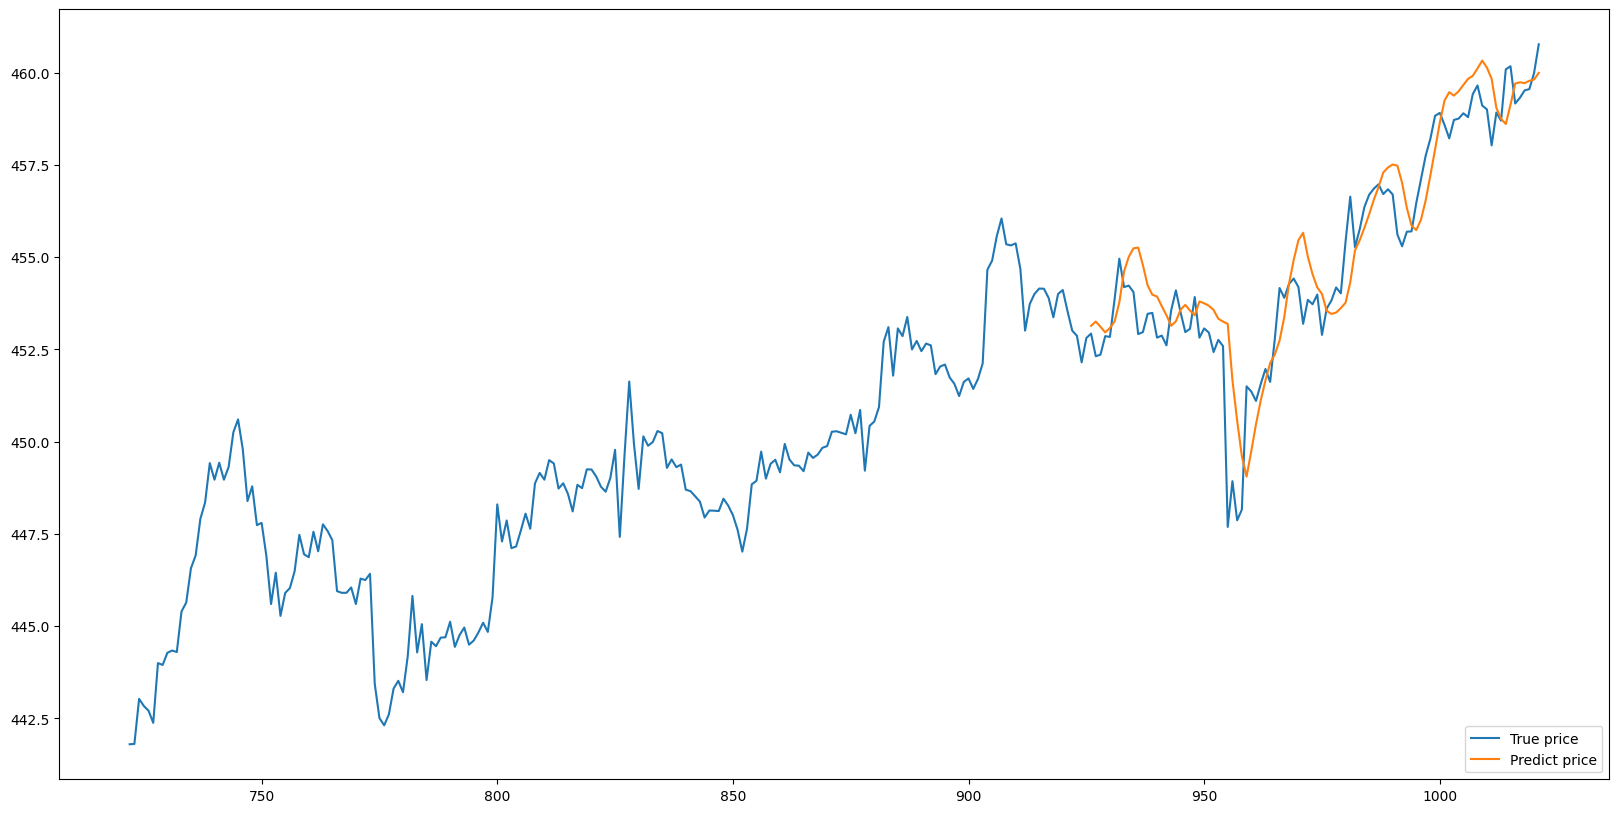

In [168]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0341 - val_loss: 8.5688e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 5.4208e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0013 - val_loss: 6.2614e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0012 - val_loss: 8.0885e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 3.9701e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.8962e-04 - val_loss: 3.9632e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.1239e-04 - val_loss: 0.0012
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.7391e-04 - val_loss: 3.8818e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.0952e-04 - val_loss: 4.5648e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.8052e-04 - val_loss: 9.4551e-04
Epoch 12/20
25/25 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2869371903.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


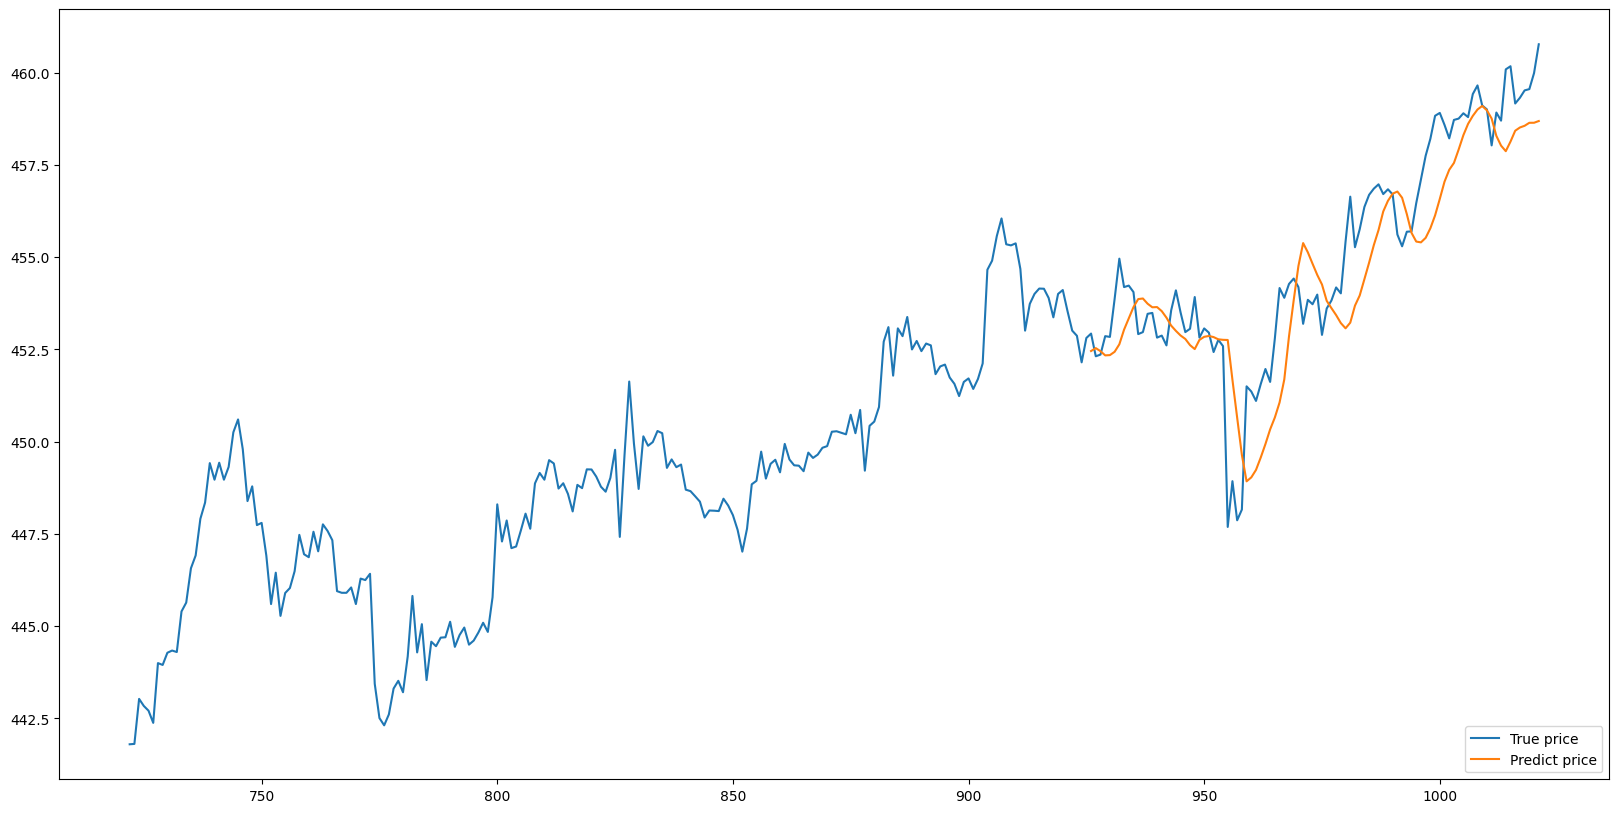

In [169]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0288 - val_loss: 0.0048
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0016 - val_loss: 3.6076e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 4.1995e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.8805e-04 - val_loss: 0.0017
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0011 - val_loss: 7.0492e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.7496e-04 - val_loss: 3.3094e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.3450e-04 - val_loss: 3.3126e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 8.3775e-04 - val_loss: 3.2432e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.3234e-04 - val_loss: 5.5973e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 8.7373e-04 - val_loss: 3.1948e-04
Epoch 12/20
25/25 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3151824730.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


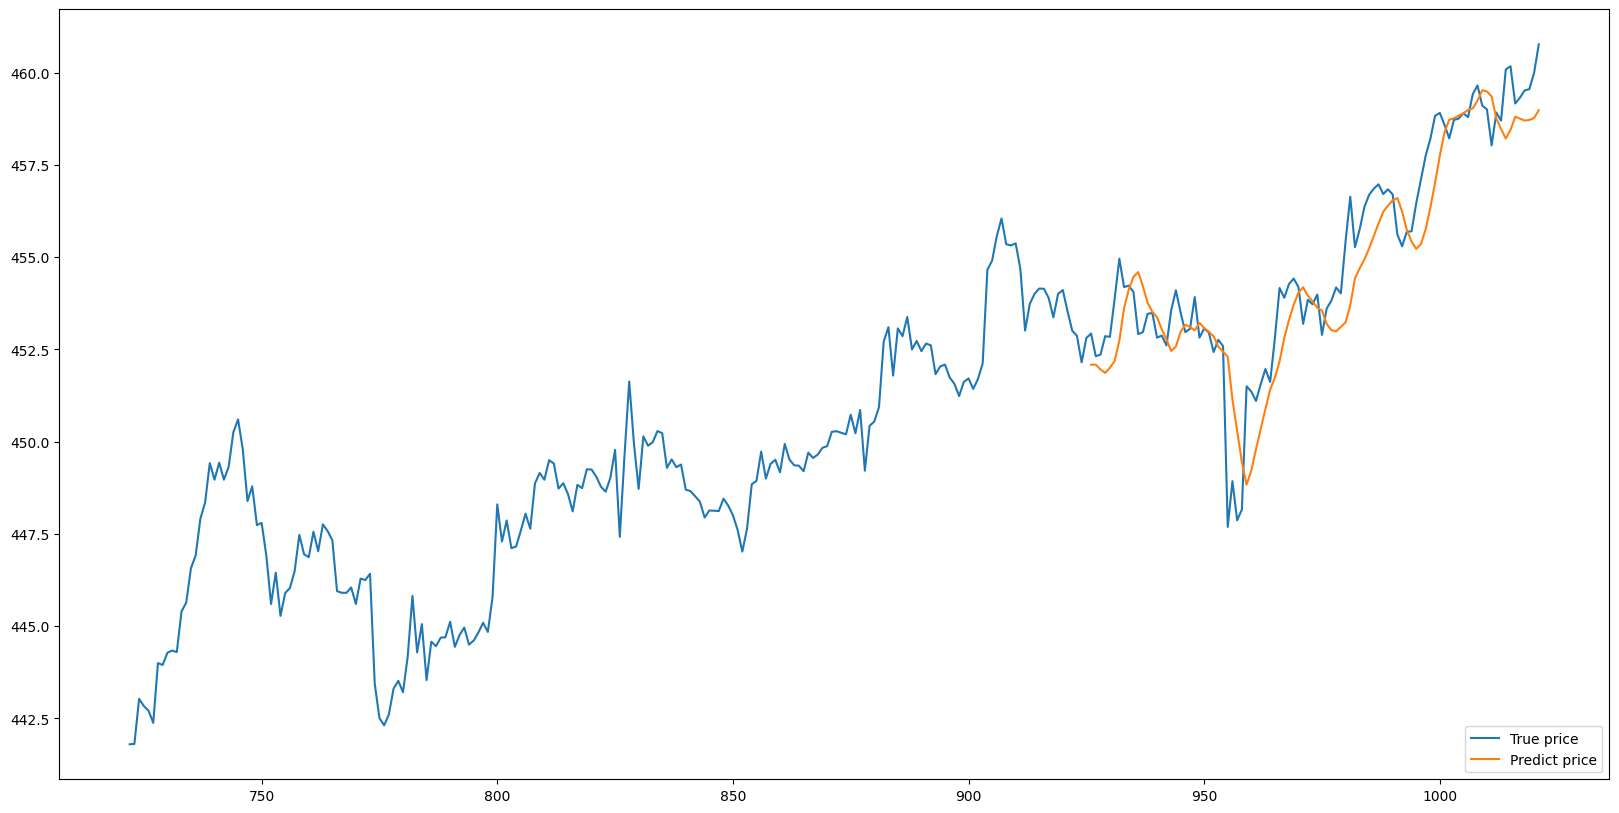

In [170]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1314 - val_loss: 0.0226
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0026 - val_loss: 5.2359e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 4.8635e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0012 - val_loss: 7.3446e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0016 - val_loss: 4.0805e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.7561e-04 - val_loss: 4.4721e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.8365e-04 - val_loss: 4.4981e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.4597e-04 - val_loss: 9.6827e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.4086e-04 - val_loss: 3.8017e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.8413e-04 - val_loss: 6.1569e-04
Epoch 12/20
25/25 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\966894094.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


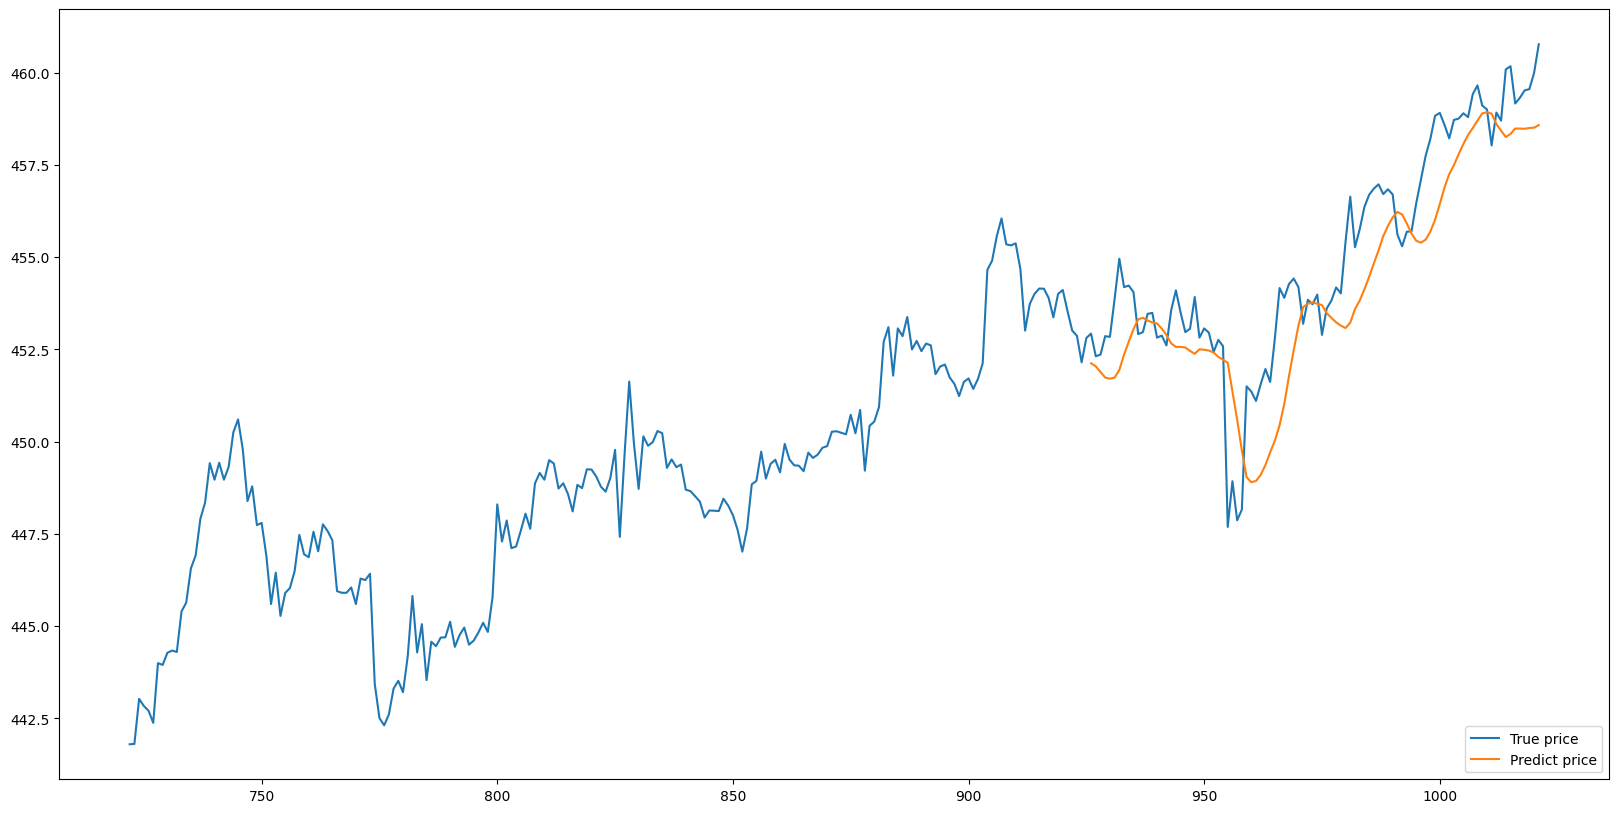

In [171]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0529 - val_loss: 7.3845e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0015 - val_loss: 4.0847e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.0260e-04 - val_loss: 7.7853e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.2236e-04 - val_loss: 8.7214e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 3.9433e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.6157e-04 - val_loss: 3.9626e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.4809e-04 - val_loss: 4.5246e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.2273e-04 - val_loss: 4.4990e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.2819e-04 - val_loss: 3.3770e-04
Epoch 12/20
25

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\527665821.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


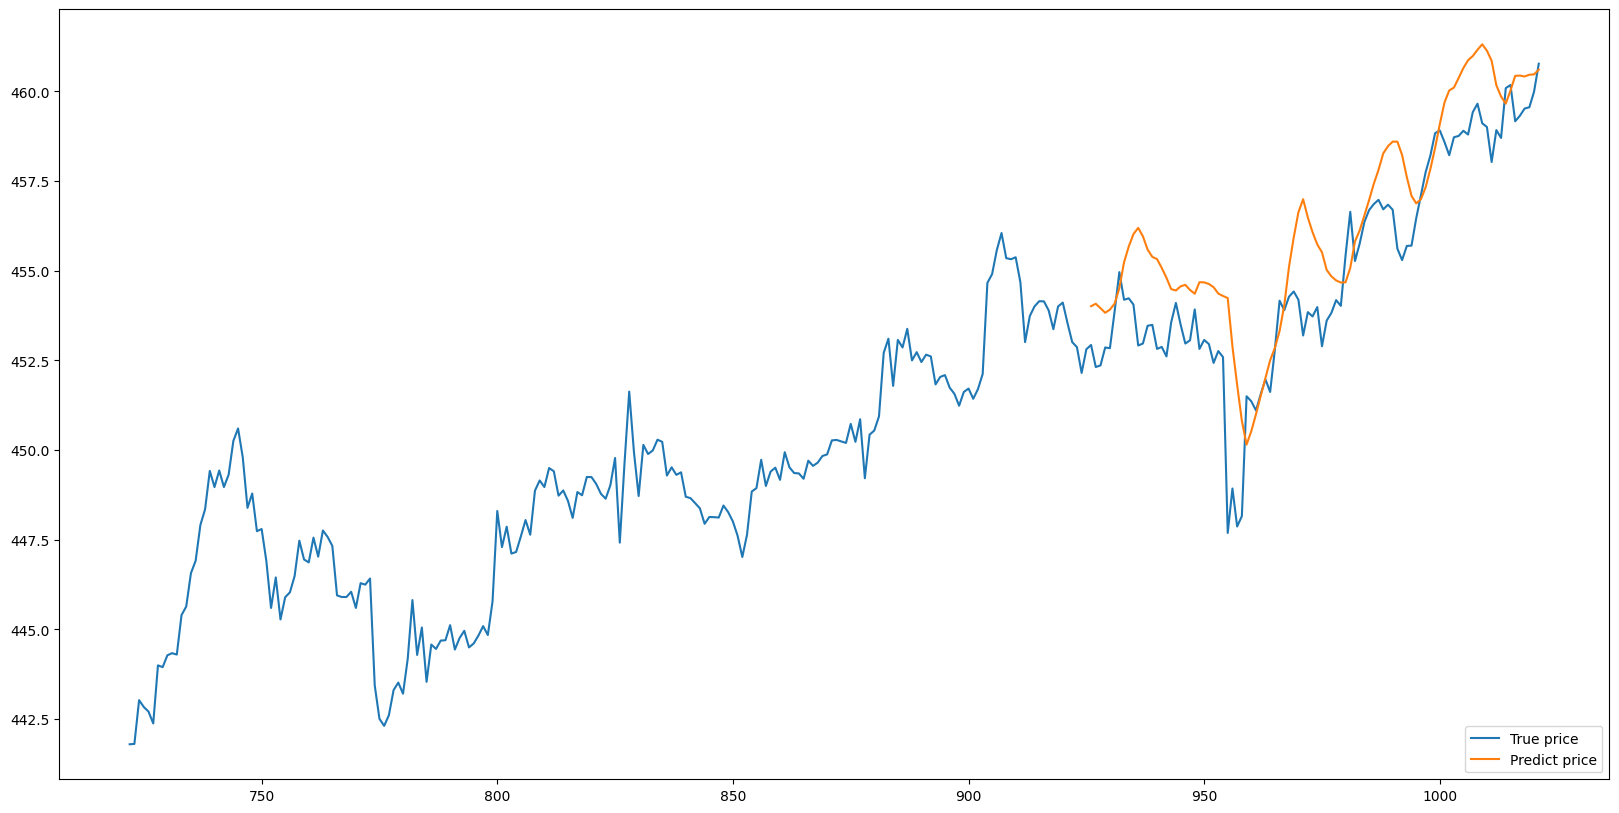

In [172]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [173]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [174]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[412.40499878],
       [412.48999023],
       [412.75      ],
       ...,
       [459.55499268],
       [459.98999023],
       [460.76998901]])

In [175]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.12902951],
       [0.13056006],
       [0.13524239],
       ...,
       [0.97812   ],
       [0.98595356],
       [1.        ]])

In [176]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

962
962


In [177]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (770, 60, 1)
Size validate:  (96, 60, 1)
Size test:  (96, 60, 1)


### b. Train Model

In [178]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0955 - val_loss: 0.0034
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0090 - val_loss: 6.2662e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0071 - val_loss: 6.3765e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0076 - val_loss: 0.0039
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0055 - val_loss: 9.3001e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0076 - val_loss: 6.6245e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0045 - val_loss: 5.6640e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0038 - val_loss: 6.2965e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0043 - val_loss: 7.7015e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 

### c. Test Model

In [179]:
model_rnn = load_model('./MODEL/RNN.h5')

In [180]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 


In [181]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date        open        high         low       close  \
926   2024-06-27 15:00:00  452.869995  453.049896  452.410187  452.929993   
927   2024-06-27 15:15:00  452.899994  452.940002  452.119995  452.315002   
928   2024-06-27 15:30:00  452.290009  452.739990  452.200012  452.359985   
929   2024-06-27 15:45:00  452.364990  453.220001  452.250000  452.859985   
930   2024-06-28 09:30:00  453.065002  453.178986  451.605011  452.839996   
...                   ...         ...         ...         ...         ...   
1017  2024-07-03 11:45:00  459.160004  459.359894  458.709991  459.320007   
1018  2024-07-03 12:00:00  459.309998  459.589996  459.179993  459.519989   
1019  2024-07-03 12:15:00  459.519989  460.390015  459.429993  459.554993   
1020  2024-07-03 12:30:00  459.540009  460.440002  459.176300  459.989990   
1021  2024-07-03 12:45:00  460.029999  461.019989  459.899994  460.769989   

       Adj Close   volume         SMA       ROC        RSI  Real Upper Band  \
926   452.929993   284949  453.480321 -0.236784  46.968971       455.924242   
927   452.315002   305074  453.378884 -0.404096  42.575351       455.601944   
928   452.359985   368889  453.261383 -0.393047  42.995386       455.390091   
929   452.859985  1409692  453.169224 -0.228027  47.584744       455.106296   
930   452.839996  1230364  453.076011 -0.116902  47.420378       454.744935   
...          ...      ...         ...       ...        ...              ...   
1017  459.320007   320324  459.145881  0.091526  57.935761       460.068864   
1018  459.519989   321503  459.200444  0.157757  59.196388       460.099346   
1019  459.554993   407814  459.247229  0.029380  59.425598       460.153649   
1020  459.989990   464931  459.332500  0.072879  62.262634       460.274878   
1021  460.769989  1397683  459.428927  0.361570  66.751864       460.558591   

      Real Lower Band  Real Middle Band  predictions  
926        451.926707        453.480321   452.617859  
927        451.875507        453.378884   452.459808  
928        451.788358        453.261383   452.306366  
929        451.826150        453.169224   452.159302  
930        451.934011        453.076011   452.027863  
...               ...               ...          ...  
1017       457.883077        459.145881   458.146698  
1018       457.983595        459.200444   458.166809  
1019       458.001582        459.247229   458.201172  
1020       457.988351        459.332500   458.246094  
1021       457.923138        459.428927   458.302979  

[96 rows x 14 columns]

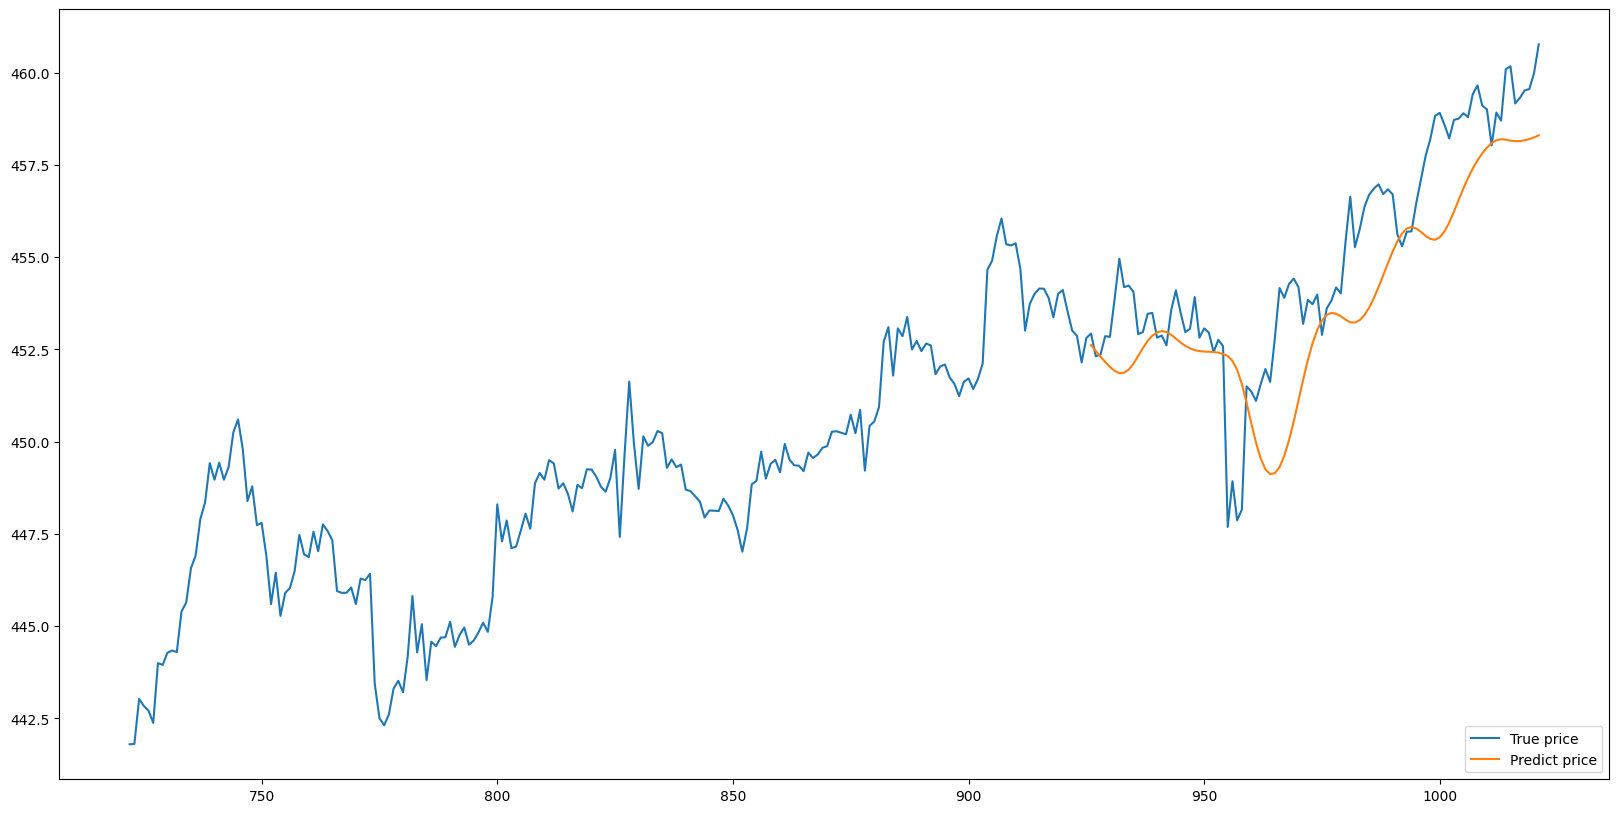

In [182]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [183]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[4.12404999e+02, 1.00732677e-01],
       [4.12489990e+02, 1.69673644e-02],
       [4.12750000e+02, 1.57727223e-01],
       ...,
       [4.59554993e+02, 2.93803587e-02],
       [4.59989990e+02, 7.28788887e-02],
       [4.60769989e+02, 3.61569932e-01]])

In [184]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.12902951, 0.55605657],
       [0.13056006, 0.54000183],
       [0.13524239, 0.56698034],
       ...,
       [0.97812   , 0.54238095],
       [0.98595356, 0.55071802],
       [1.        , 0.60604952]])

In [185]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

962
962


In [186]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (770, 60, 2)
Size validate:  (96, 60, 2)
Size test:  (96, 60, 2)


In [187]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0715 - val_loss: 0.0071
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0078 - val_loss: 8.9572e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0049 - val_loss: 5.8687e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0055 - val_loss: 6.0494e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0047 - val_loss: 9.7583e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0038 - val_loss: 7.4837e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s

In [188]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [189]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [190]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date        open        high         low       close  \
926   2024-06-27 15:00:00  452.869995  453.049896  452.410187  452.929993   
927   2024-06-27 15:15:00  452.899994  452.940002  452.119995  452.315002   
928   2024-06-27 15:30:00  452.290009  452.739990  452.200012  452.359985   
929   2024-06-27 15:45:00  452.364990  453.220001  452.250000  452.859985   
930   2024-06-28 09:30:00  453.065002  453.178986  451.605011  452.839996   
...                   ...         ...         ...         ...         ...   
1017  2024-07-03 11:45:00  459.160004  459.359894  458.709991  459.320007   
1018  2024-07-03 12:00:00  459.309998  459.589996  459.179993  459.519989   
1019  2024-07-03 12:15:00  459.519989  460.390015  459.429993  459.554993   
1020  2024-07-03 12:30:00  459.540009  460.440002  459.176300  459.989990   
1021  2024-07-03 12:45:00  460.029999  461.019989  459.899994  460.769989   

       Adj Close   volume         SMA       ROC        RSI  Real Upper Band  \
926   452.929993   284949  453.480321 -0.236784  46.968971       455.924242   
927   452.315002   305074  453.378884 -0.404096  42.575351       455.601944   
928   452.359985   368889  453.261383 -0.393047  42.995386       455.390091   
929   452.859985  1409692  453.169224 -0.228027  47.584744       455.106296   
930   452.839996  1230364  453.076011 -0.116902  47.420378       454.744935   
...          ...      ...         ...       ...        ...              ...   
1017  459.320007   320324  459.145881  0.091526  57.935761       460.068864   
1018  459.519989   321503  459.200444  0.157757  59.196388       460.099346   
1019  459.554993   407814  459.247229  0.029380  59.425598       460.153649   
1020  459.989990   464931  459.332500  0.072879  62.262634       460.274878   
1021  460.769989  1397683  459.428927  0.361570  66.751864       460.558591   

      Real Lower Band  Real Middle Band  predictions  
926        451.926707        453.480321   453.427765  
927        451.875507        453.378884   453.335815  
928        451.788358        453.261383   453.269348  
929        451.826150        453.169224   453.211060  
930        451.934011        453.076011   453.161224  
...               ...               ...          ...  
1017       457.883077        459.145881   458.837616  
1018       457.983595        459.200444   458.840973  
1019       458.001582        459.247229   458.866760  
1020       457.988351        459.332500   458.903656  
1021       457.923138        459.428927   458.948853  

[96 rows x 14 columns]

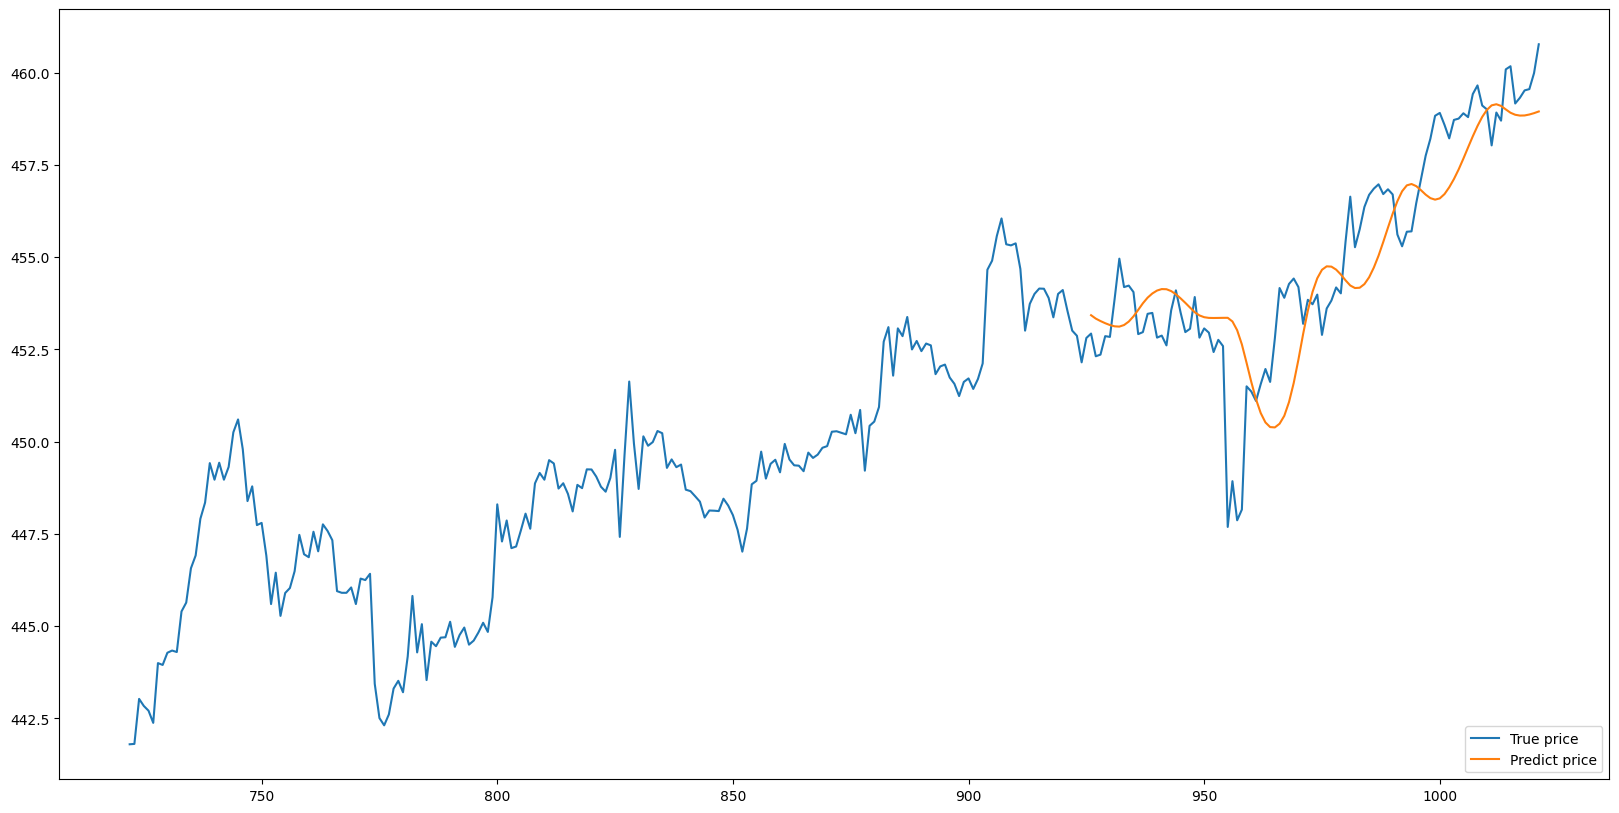

In [191]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0501 - val_loss: 0.0293
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0049 - val_loss: 0.0083
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0047 - val_loss: 6.2355e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0055 - val_loss: 6.2559e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0037 - val_loss: 8.8630e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\405231607.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


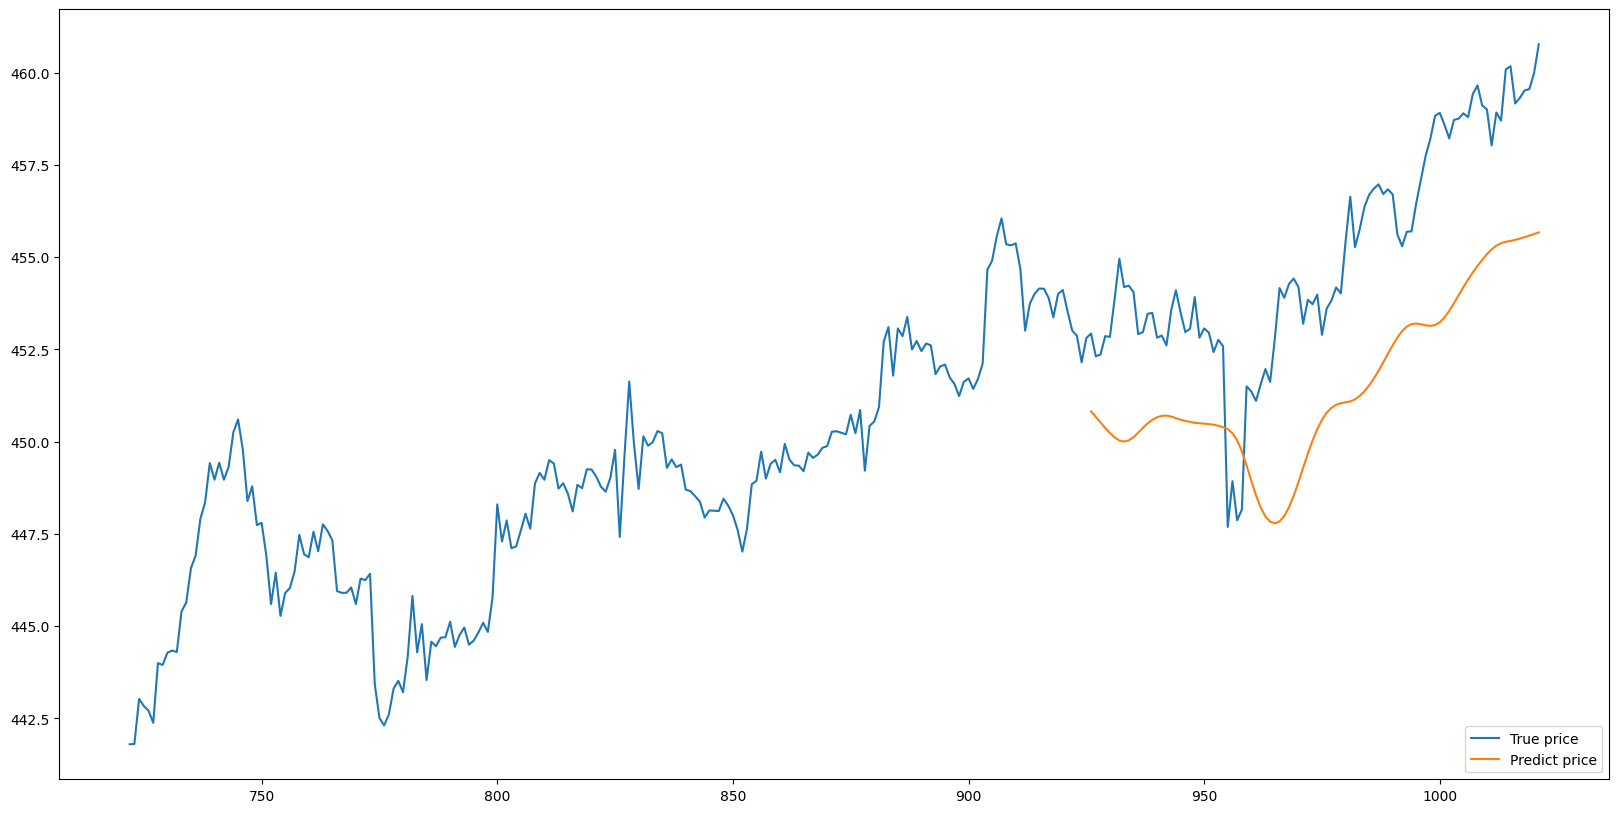

In [192]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0793 - val_loss: 0.0094
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0106 - val_loss: 6.9188e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0064 - val_loss: 8.5277e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0044 - val_loss: 0.0128
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0090 - val_loss: 0.0147
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0074 - val_loss: 0.0130
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step -

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3300373627.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


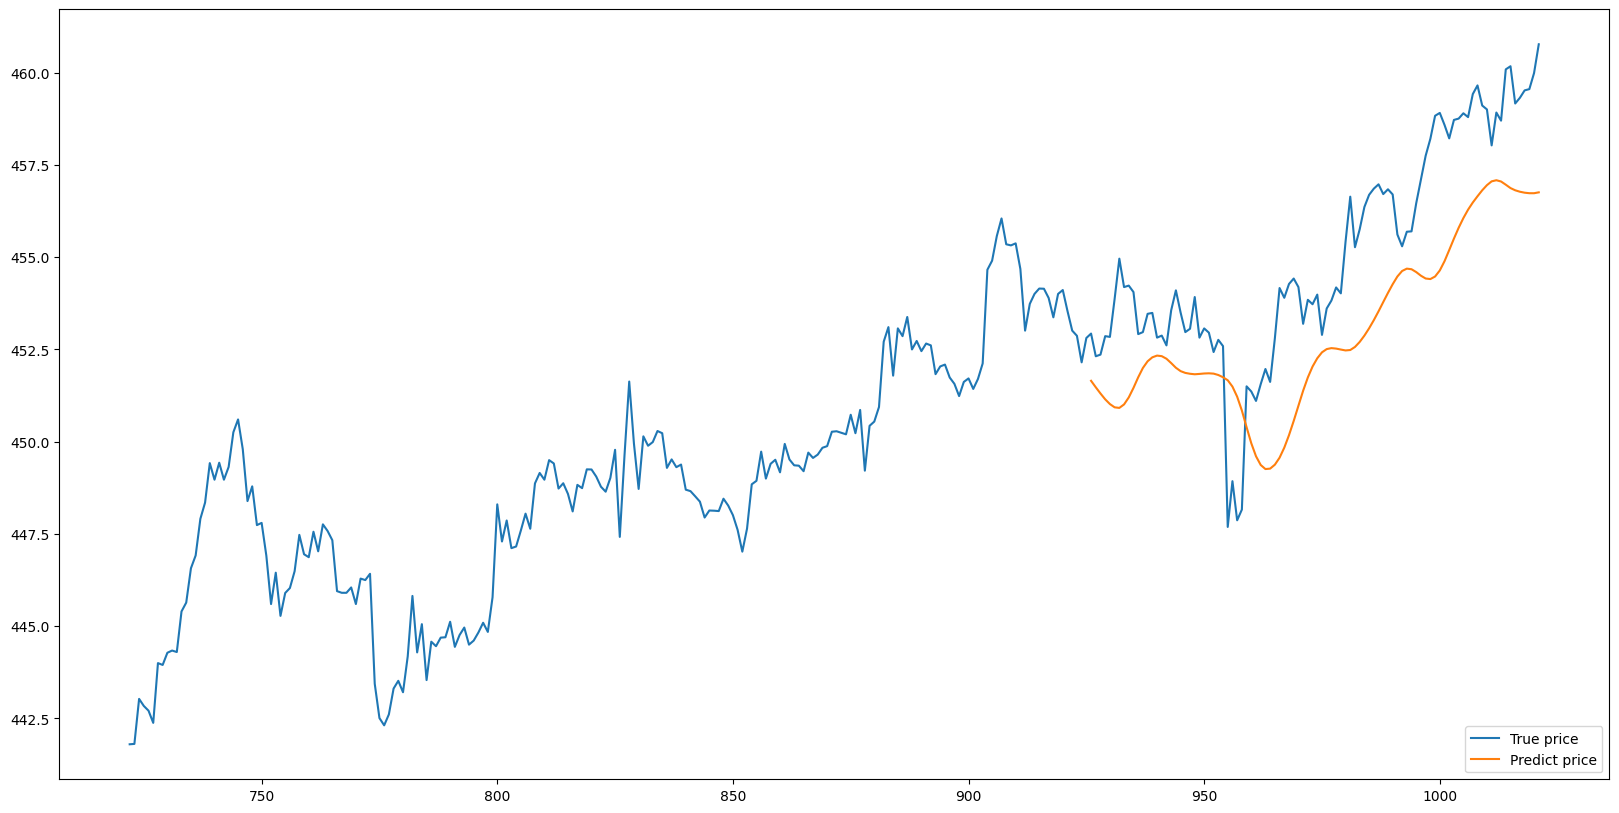

In [193]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0394 - val_loss: 0.0237
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0079 - val_loss: 7.3045e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0067 - val_loss: 8.4786e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0049 - val_loss: 0.0070
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0084 - val_loss: 0.0010
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0045 - val_loss: 9.3074e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0040 - val_loss: 0.0061
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/s

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1104421316.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


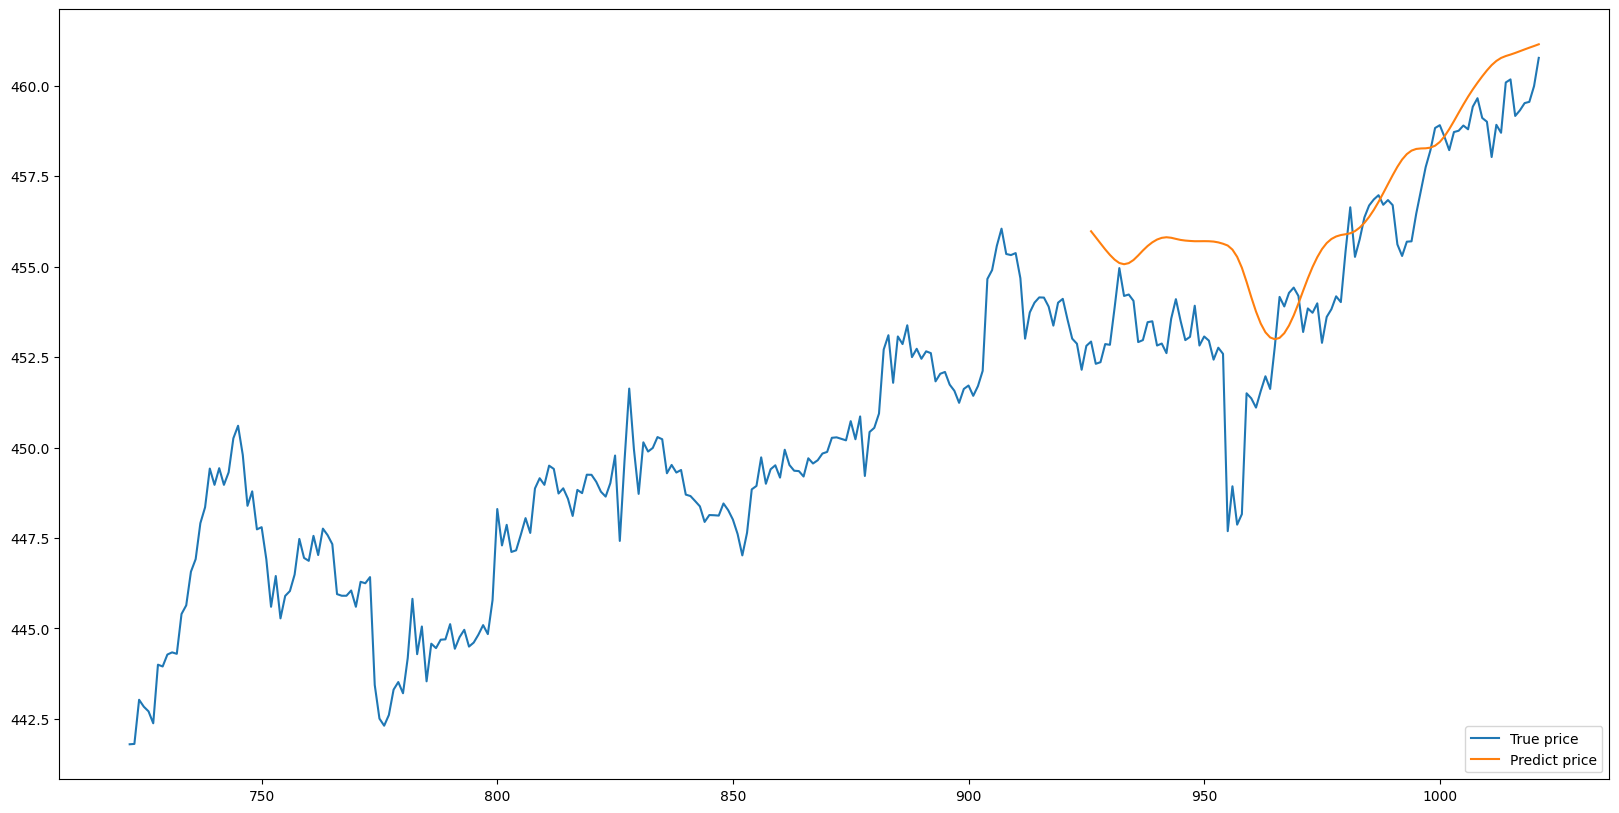

In [194]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0828 - val_loss: 0.0367
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0104 - val_loss: 0.0019
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0073 - val_loss: 9.8076e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0046 - val_loss: 6.5524e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0050 - val_loss: 8.7726e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4250773902.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


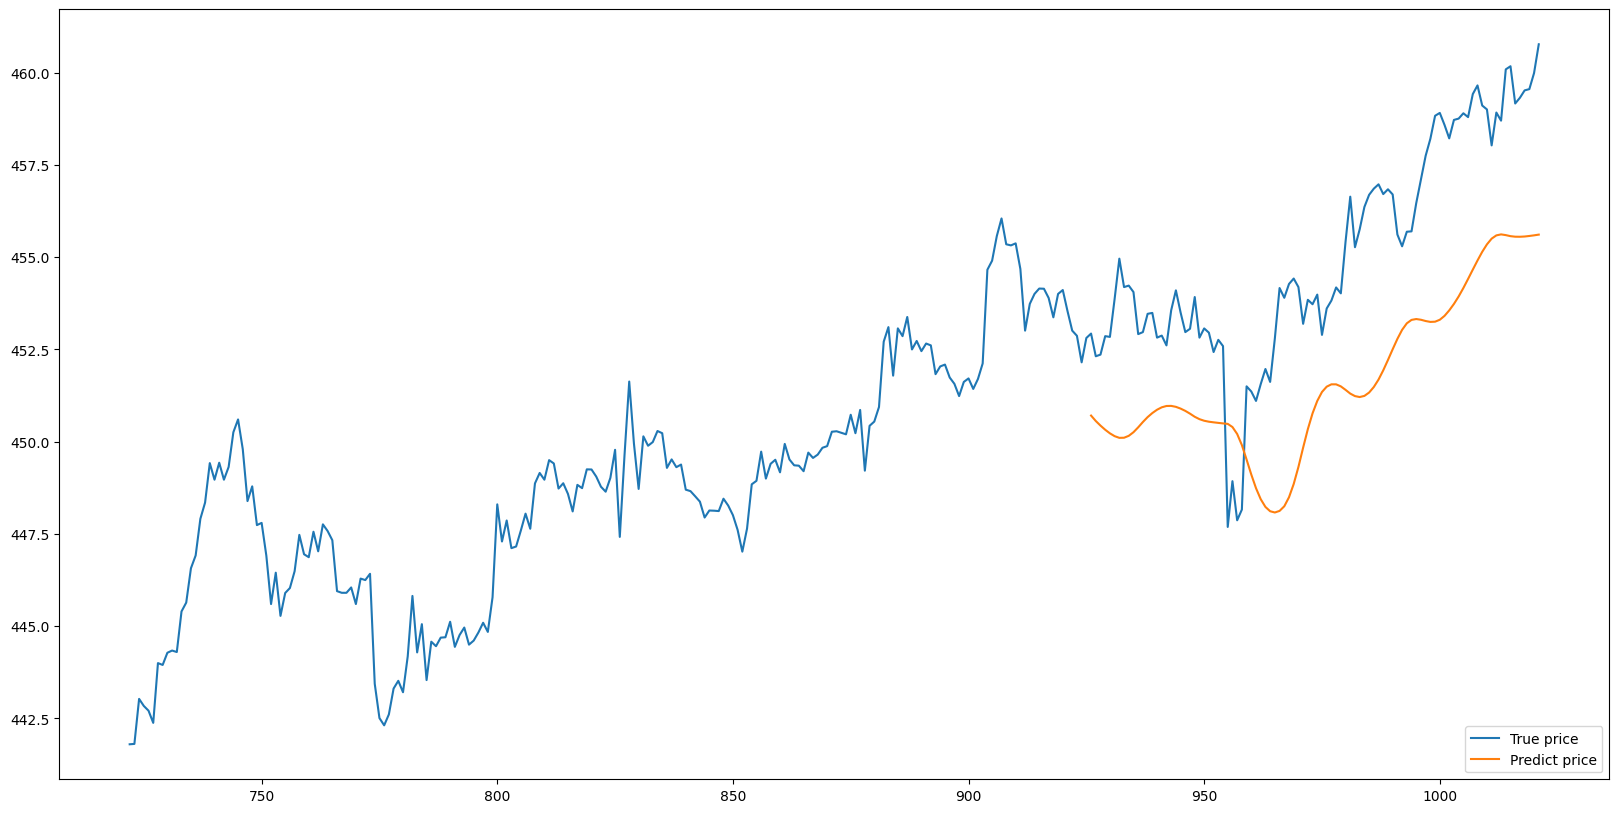

In [195]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0573 - val_loss: 0.0212
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0053 - val_loss: 5.3011e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0081 - val_loss: 0.0108
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0039 - val_loss: 6.0960e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0032 - val_loss: 6.2669e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/st

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1190786274.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


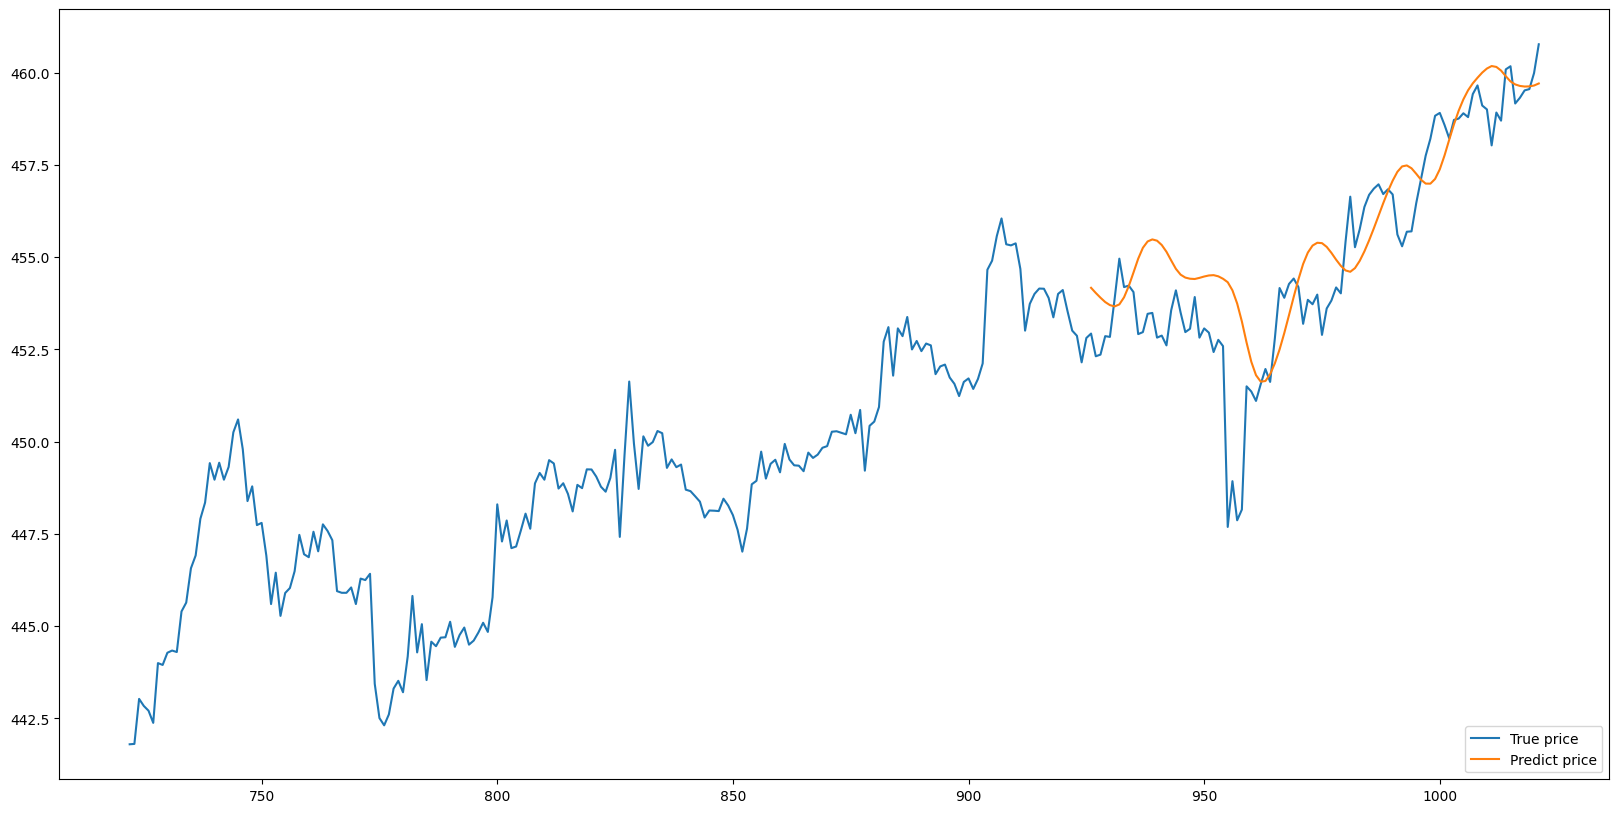

In [196]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0559 - val_loss: 0.0159
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0097 - val_loss: 8.6643e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0057 - val_loss: 7.1528e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0048 - val_loss: 9.7207e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0047 - val_loss: 0.0077
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0043 - val_loss: 6.1371e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0040 - val_loss: 5.6698e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3462996369.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


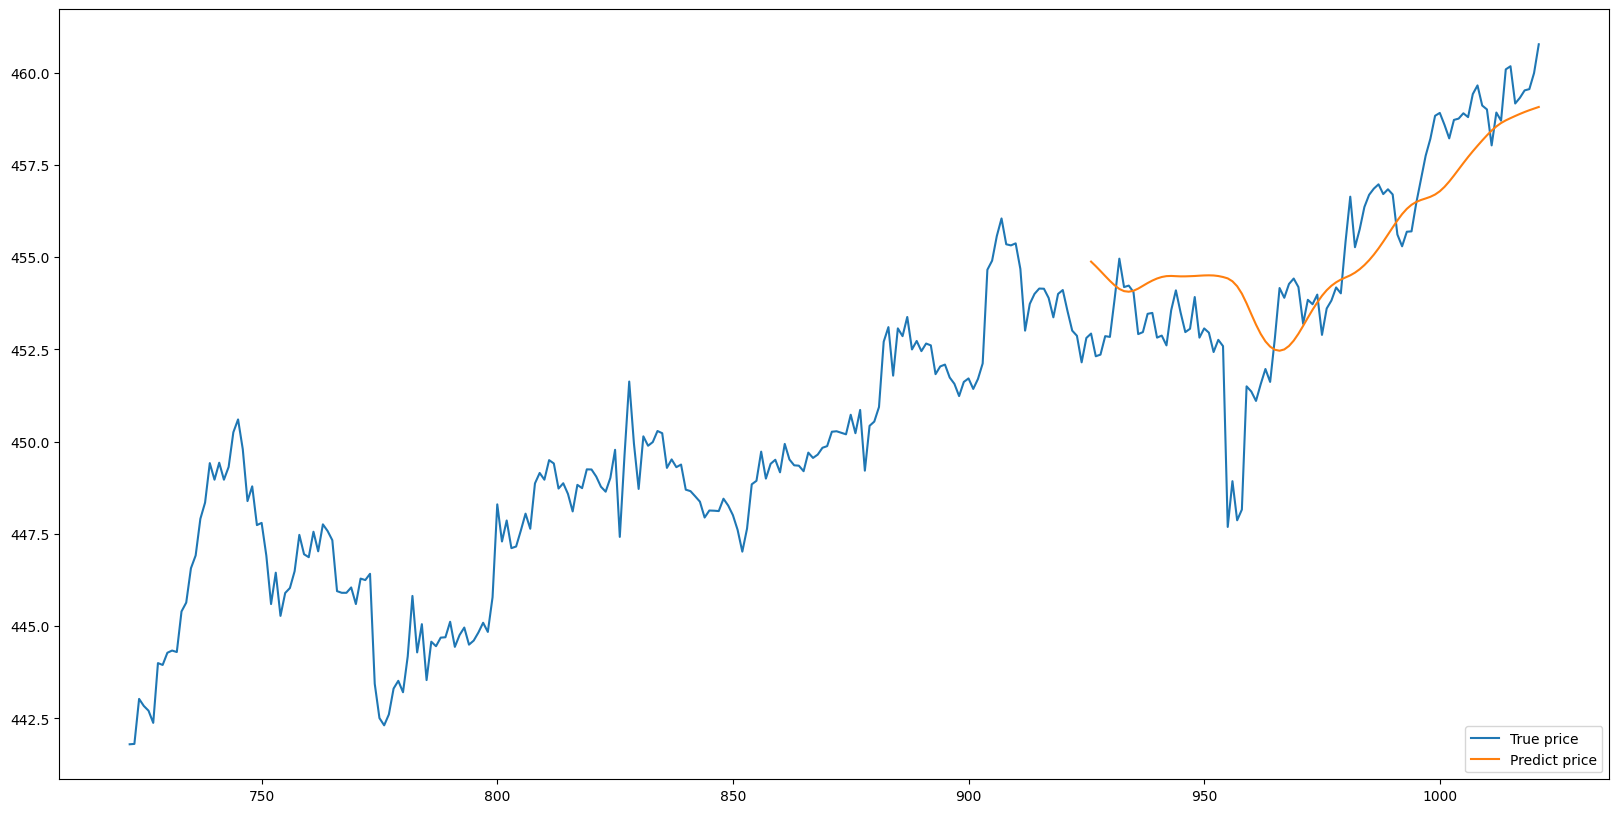

In [197]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 0.0673 - val_loss: 0.0567
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0102 - val_loss: 9.8081e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0056 - val_loss: 6.2131e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0037 - val_loss: 9.8775e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0045 - val_loss: 5.9613e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90m

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2945290508.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


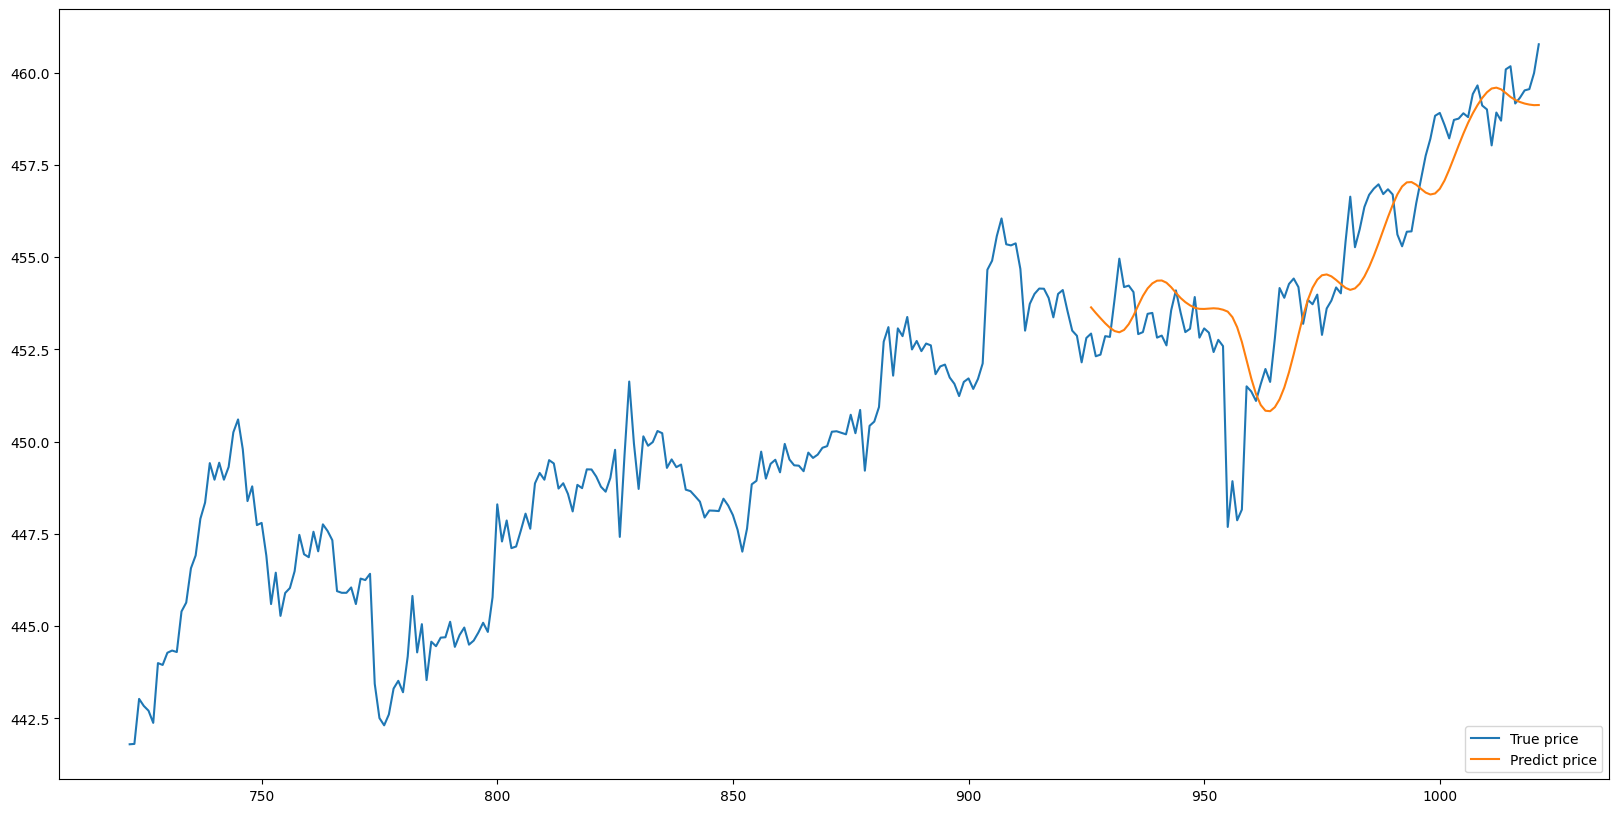

In [198]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0613 - val_loss: 0.0014
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0051 - val_loss: 9.1286e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0035 - val_loss: 0.0082
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0049 - val_loss: 7.5329e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\550273099.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


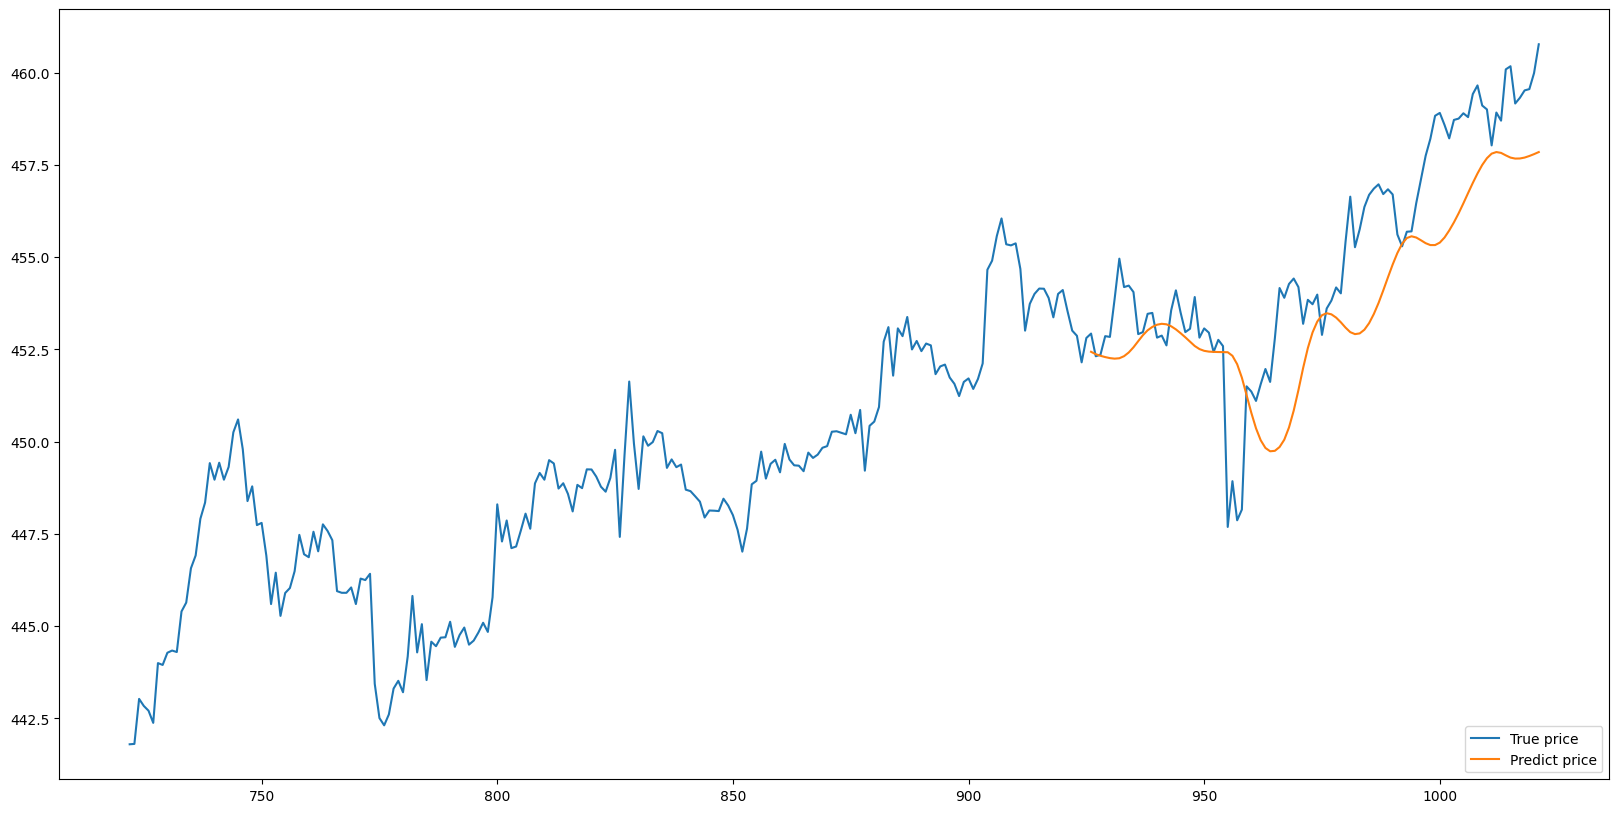

In [199]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0845 - val_loss: 0.0059
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0044 - val_loss: 0.0294
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0132 - val_loss: 0.0161
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0038 - val_loss: 7.5965e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0053 - val_loss: 5.1049e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0038 - val_loss: 9.6366e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\501329646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


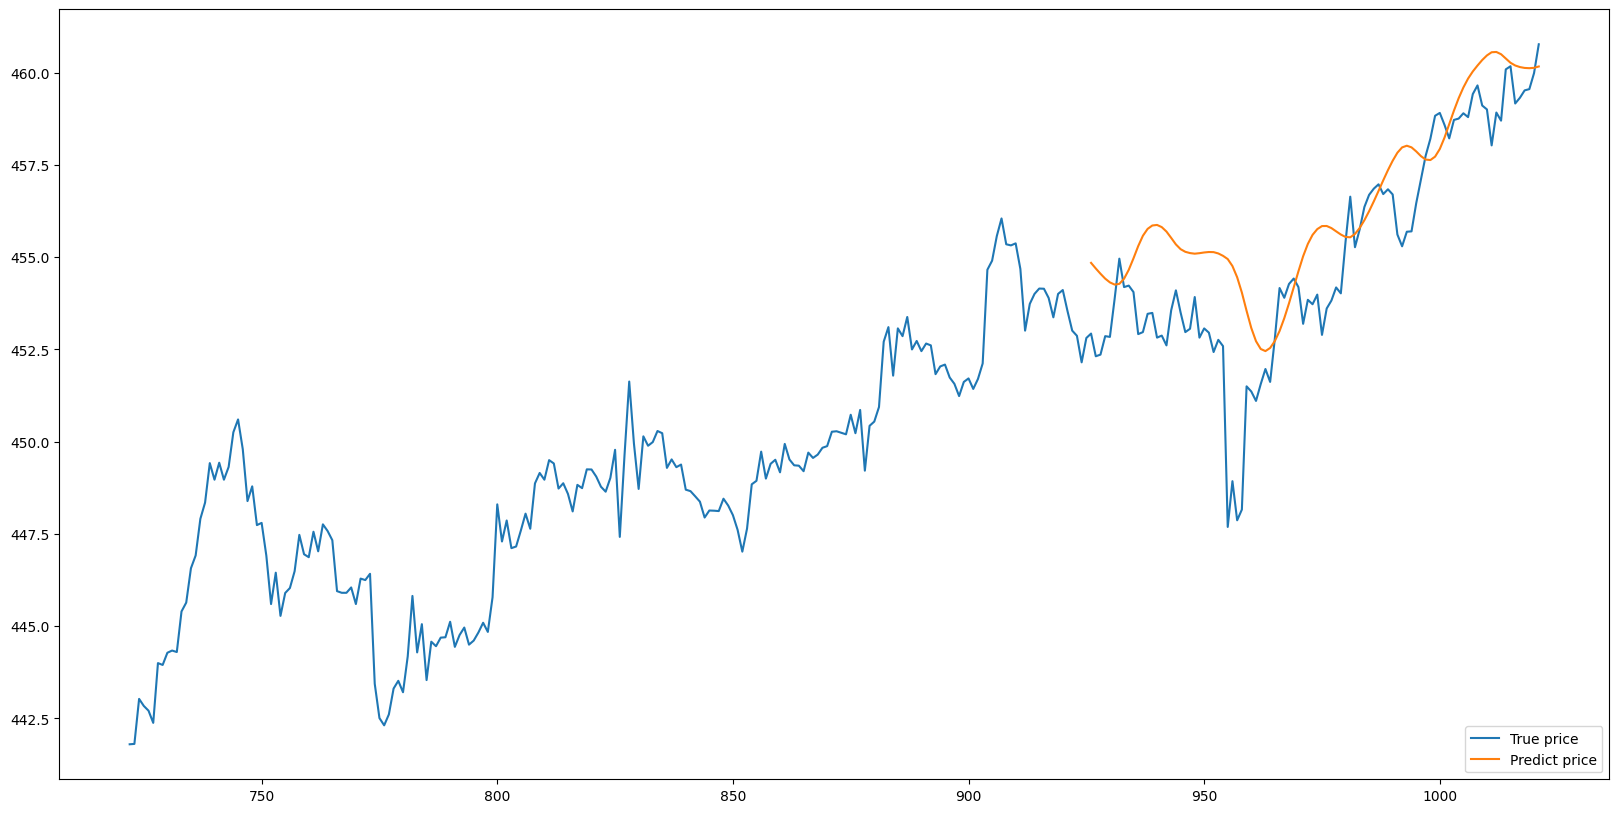

In [200]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0760 - val_loss: 0.0352
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0160 - val_loss: 9.1419e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0071 - val_loss: 0.0016
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0066 - val_loss: 5.8504e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0052 - val_loss: 0.0128
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0085 - val_loss: 5.7351e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0046 - val_loss: 5.0515e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0041 - val_loss: 5.6080e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\735267261.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


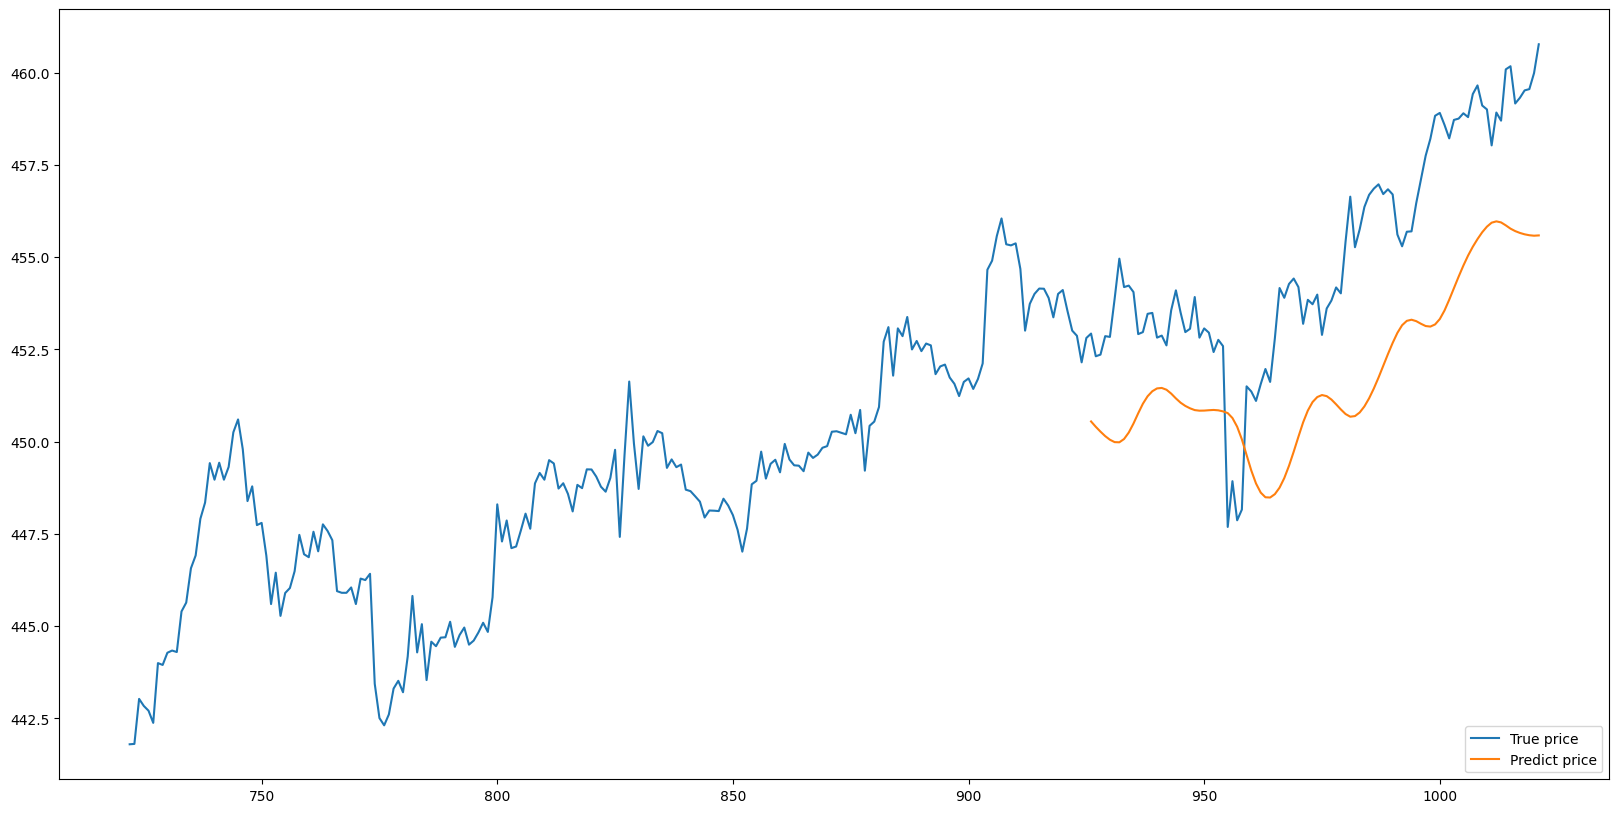

In [201]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0616 - val_loss: 0.0329
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0052 - val_loss: 6.0815e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0051 - val_loss: 7.1547e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3760107672.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


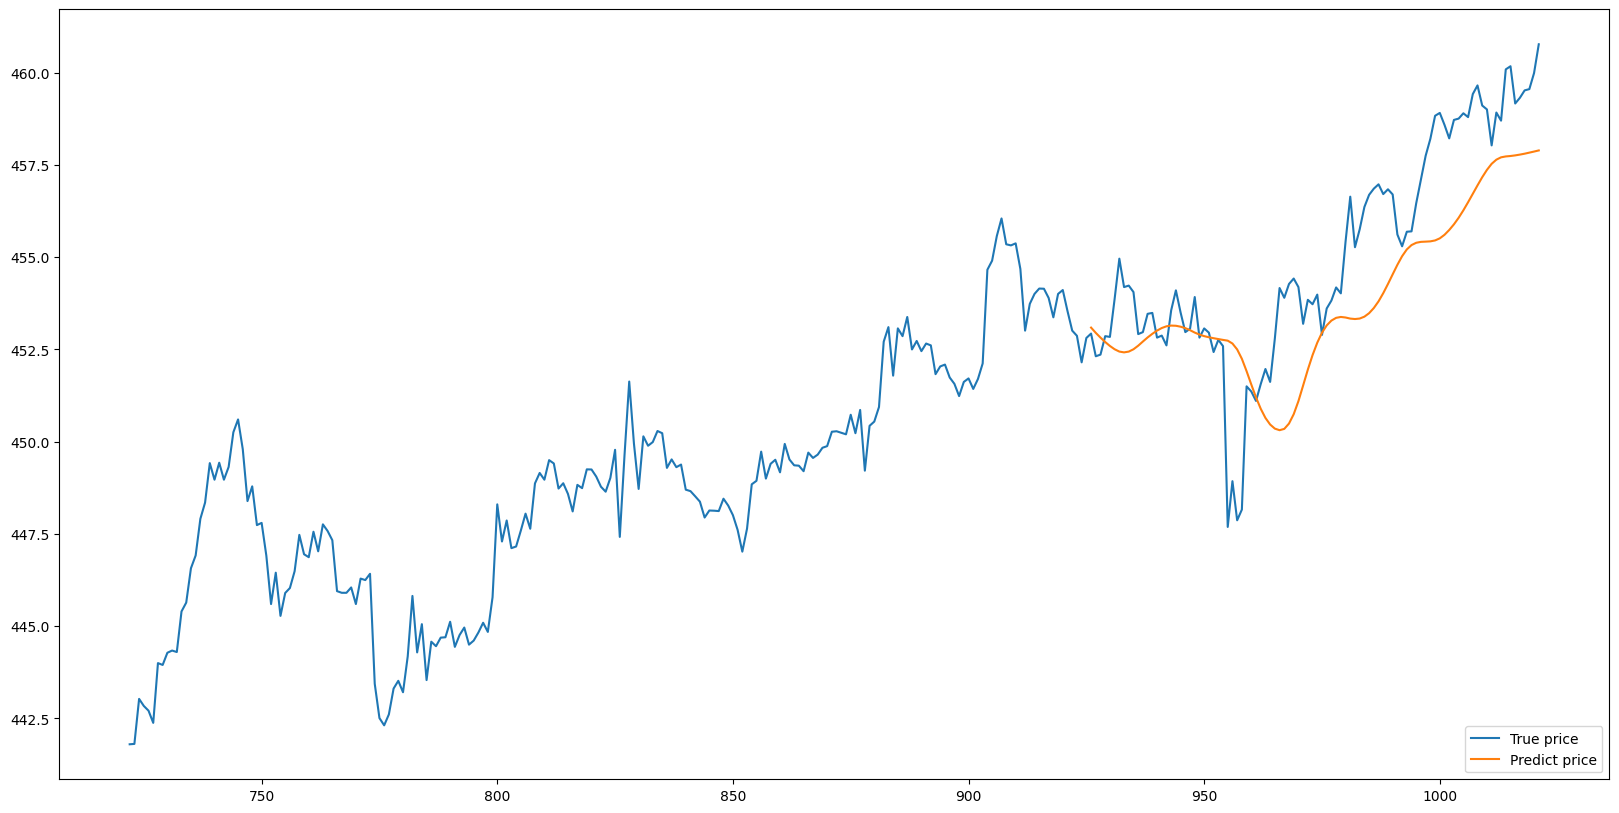

In [202]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25


c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0695 - val_loss: 0.0288
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0097 - val_loss: 9.6178e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0067 - val_loss: 5.5745e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0042 - val_loss: 5.1530e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0035 - val_loss: 5.1465e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0033 - val_loss: 4.8827e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/s

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3944824141.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


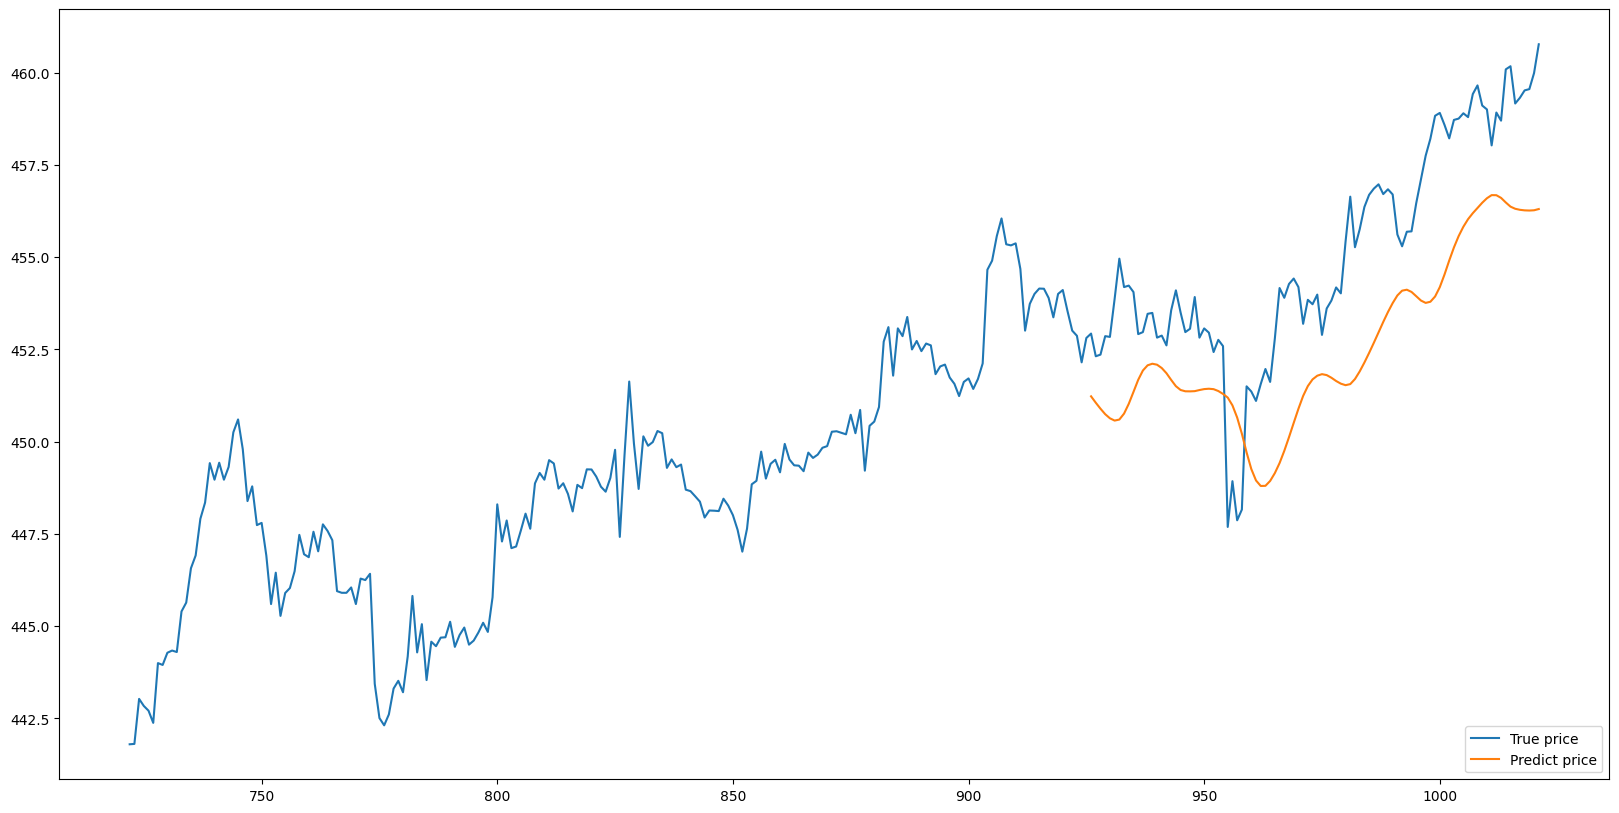

In [203]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0762 - val_loss: 0.0067
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0089 - val_loss: 0.0048
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0060 - val_loss: 6.4880e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0044 - val_loss: 8.4096e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3746671161.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


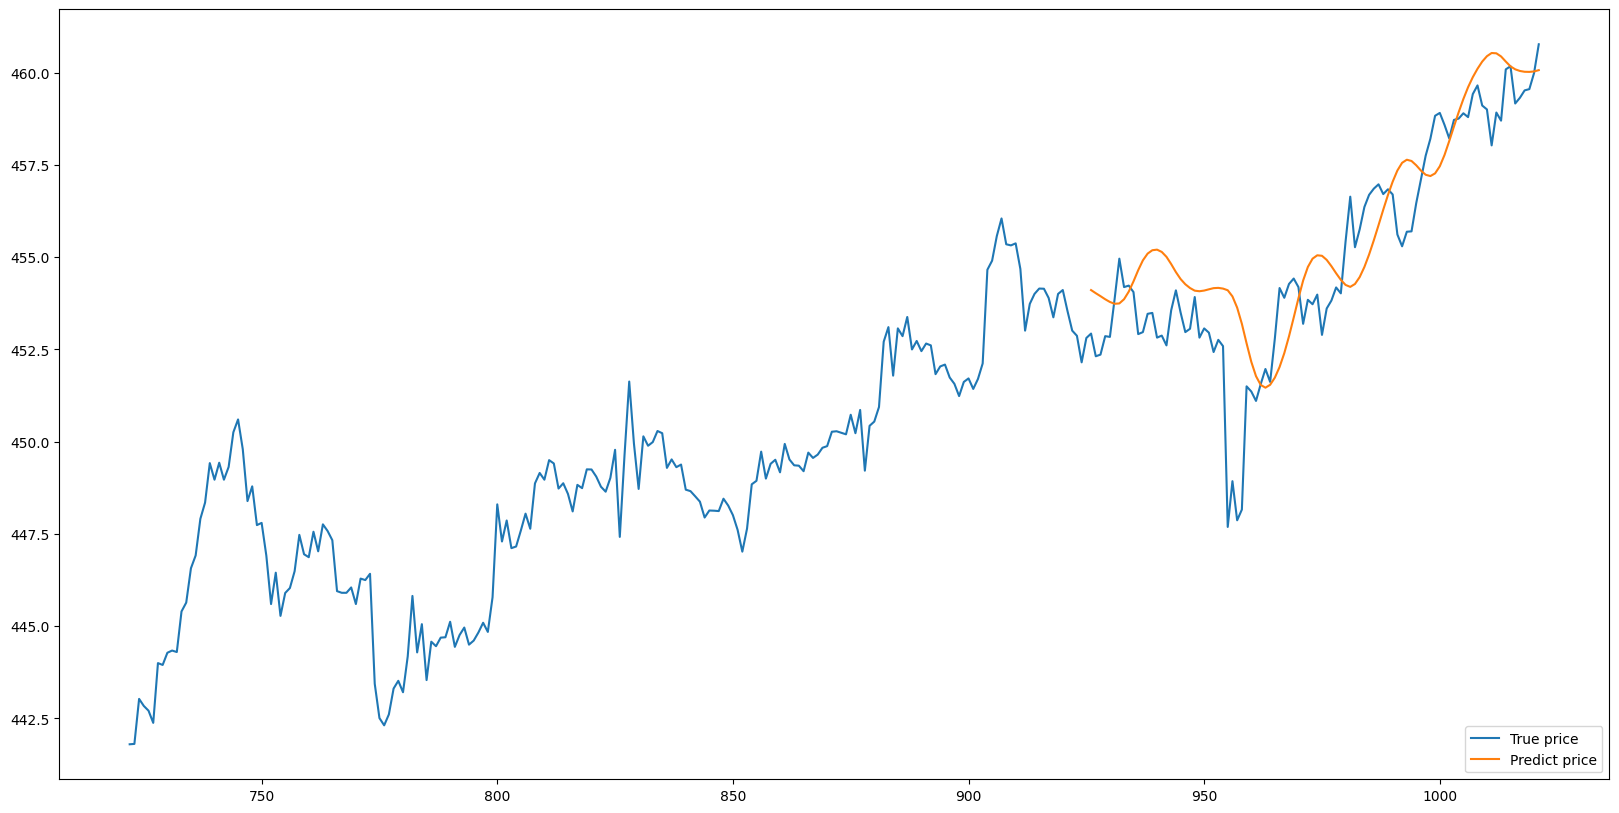

In [204]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

c:\Users\Admin\.julia\conda\3\x86_64\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0777 - val_loss: 0.0256
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0119 - val_loss: 0.0146
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0068 - val_loss: 0.0015
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0055 - val_loss: 5.4823e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1856881563.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


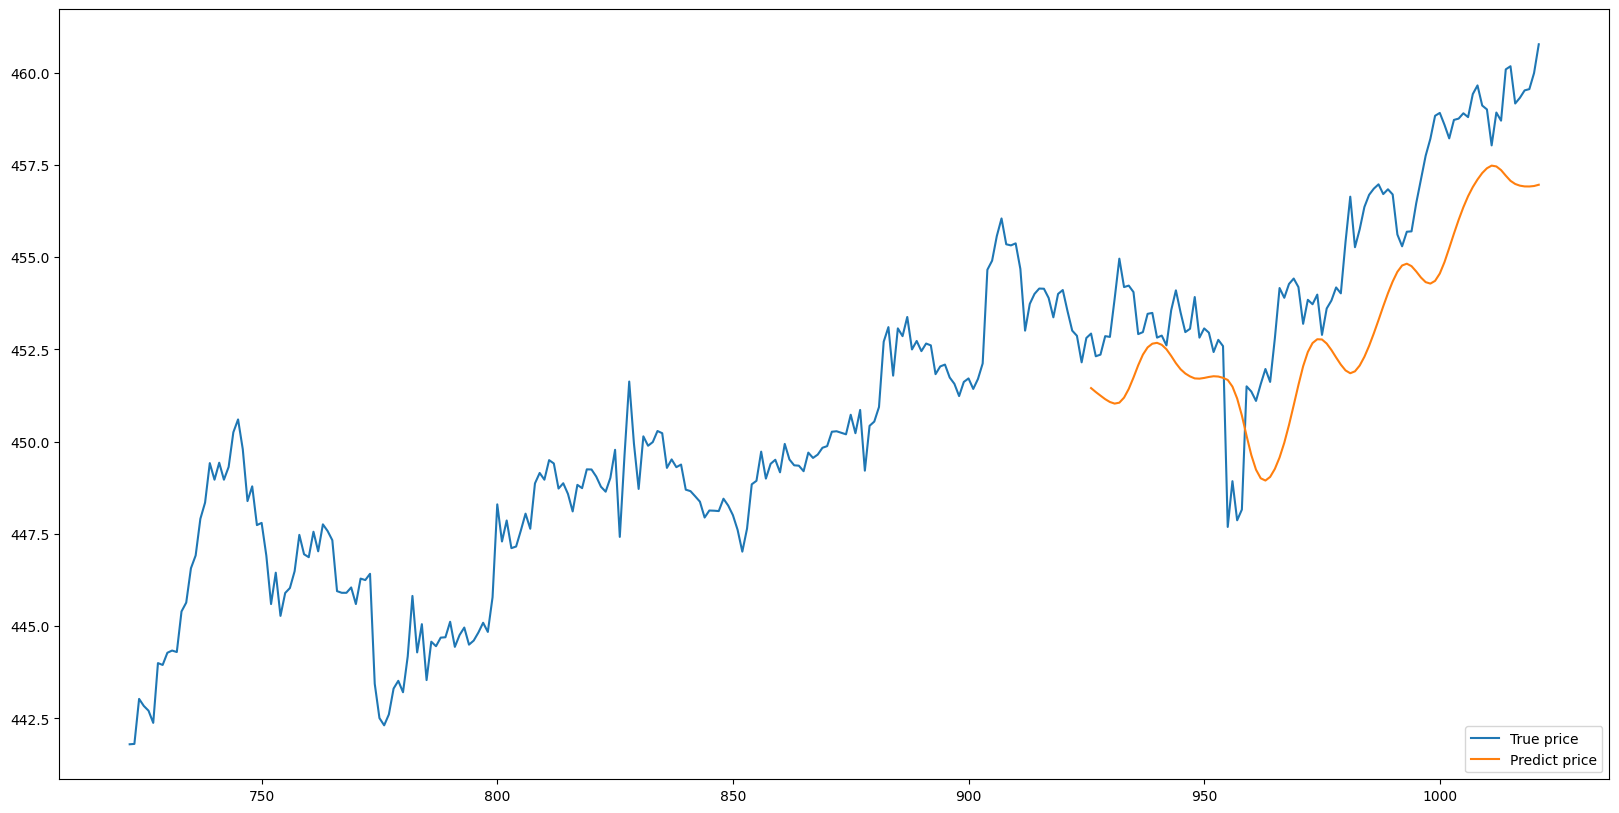

In [205]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [206]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close   volume
0     412.404999   601363
1     412.489990   323742
2     412.750000   265613
3     412.769989   245015
4     412.279999   228841
...          ...      ...
1017  459.320007   320324
1018  459.519989   321503
1019  459.554993   407814
1020  459.989990   464931
1021  460.769989  1397683

[1022 rows x 2 columns]

In [207]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2714080084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

close   volume  close_date_1  volume_date_1  close_date_2  \
0     412.404999   601363           NaN            NaN           NaN   
1     412.489990   323742    412.404999       601363.0           NaN   
2     412.750000   265613    412.489990       323742.0    412.404999   
3     412.769989   245015    412.750000       265613.0    412.489990   
4     412.279999   228841    412.769989       245015.0    412.750000   
...          ...      ...           ...            ...           ...   
1017  459.320007   320324    459.165009       372943.0    460.174988   
1018  459.519989   321503    459.320007       320324.0    459.165009   
1019  459.554993   407814    459.519989       321503.0    459.320007   
1020  459.989990   464931    459.554993       407814.0    459.519989   
1021  460.769989  1397683    459.989990       464931.0    459.554993   

      volume_date_2  
0               NaN  
1               NaN  
2          601363.0  
3          323742.0  
4          265613.0  
...             ...  
1017       356632.0  
1018       372943.0  
1019       320324.0  
1020       321503.0  
1021       407814.0  

[1022 rows x 6 columns]

In [208]:
dataset.dropna(inplace=True)
dataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close   volume  close_date_1  volume_date_1  close_date_2  \
2     412.750000   265613    412.489990       323742.0    412.404999   
3     412.769989   245015    412.750000       265613.0    412.489990   
4     412.279999   228841    412.769989       245015.0    412.750000   
5     412.350006   227200    412.279999       228841.0    412.769989   
6     411.920013   314112    412.350006       227200.0    412.279999   
...          ...      ...           ...            ...           ...   
1017  459.320007   320324    459.165009       372943.0    460.174988   
1018  459.519989   321503    459.320007       320324.0    459.165009   
1019  459.554993   407814    459.519989       321503.0    459.320007   
1020  459.989990   464931    459.554993       407814.0    459.519989   
1021  460.769989  1397683    459.989990       464931.0    459.554993   

      volume_date_2  
2          601363.0  
3          323742.0  
4          265613.0  
5          245015.0  
6          228841.0  
...             ...  
1017       356632.0  
1018       372943.0  
1019       320324.0  
1020       321503.0  
1021       407814.0  

[1020 rows x 6 columns]

In [209]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1020, 4)
(1020, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2       412.489990       323742.0    412.404999       601363.0
3       412.750000       265613.0    412.489990       323742.0
4       412.769989       245015.0    412.750000       265613.0
5       412.279999       228841.0    412.769989       245015.0
6       412.350006       227200.0    412.279999       228841.0
...            ...            ...           ...            ...
1017    459.165009       372943.0    460.174988       356632.0
1018    459.320007       320324.0    459.165009       372943.0
1019    459.519989       321503.0    459.320007       320324.0
1020    459.554993       407814.0    459.519989       321503.0
1021    459.989990       464931.0    459.554993       407814.0

[1020 rows x 4 columns]

In [210]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (918, 4)
Size test:  (102, 4)


### b. Train Model

In [211]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [212]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [213]:
predictions = model_xgboost.predict(X_test)
predictions

array([452.73203, 452.87442, 452.7344 , 452.6836 , 452.78122, 452.6627 ,
       453.0811 , 452.90628, 452.80853, 453.1893 , 452.92032, 453.64972,
       453.01556, 452.87045, 453.3911 , 453.25394, 453.0005 , 453.09753,
       453.38672, 453.17685, 453.02643, 452.77902, 452.86444, 453.2088 ,
       453.02228, 452.92914, 452.72006, 452.5835 , 452.5835 , 452.97192,
       452.93216, 452.88297, 452.94577, 452.65372, 453.08923, 453.09738,
       449.27896, 448.73013, 447.95822, 448.42685, 451.42886, 451.99622,
       452.38748, 452.58923, 452.88336, 452.67258, 452.95203, 453.4868 ,
       453.25177, 453.135  , 452.9357 , 452.86456, 452.97818, 453.02478,
       453.03046, 452.92023, 452.938  , 452.92453, 452.76657, 452.63724,
       452.96417, 453.2021 , 453.19   , 453.1978 , 453.04984, 452.87045,
       453.1582 , 453.55878, 453.5624 , 453.36362, 453.3698 , 453.2997 ,
       452.92404, 452.9751 , 452.8565 , 452.87442, 452.80197, 452.72504,
       452.728  , 452.728  , 453.01102, 452.9895 , 

In [214]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close   volume  close_date_1  volume_date_1  close_date_2  \
920   454.109985   201175    454.004211       225816.0    453.369995   
921   453.540009   200151    454.109985       201175.0    454.004211   
922   453.010010   267891    453.540009       200151.0    454.109985   
923   452.869995   200488    453.010010       267891.0    453.540009   
924   452.149994   303375    452.869995       200488.0    453.010010   
...          ...      ...           ...            ...           ...   
1017  459.320007   320324    459.165009       372943.0    460.174988   
1018  459.519989   321503    459.320007       320324.0    459.165009   
1019  459.554993   407814    459.519989       321503.0    459.320007   
1020  459.989990   464931    459.554993       407814.0    459.519989   
1021  460.769989  1397683    459.989990       464931.0    459.554993   

      volume_date_2  predictions  
920        191192.0   452.732025  
921        225816.0   452.874420  
922        201175.0   452.734406  
923        200151.0   452.683594  
924        267891.0   452.781219  
...             ...          ...  
1017       356632.0   453.401123  
1018       372943.0   453.304932  
1019       320324.0   453.057587  
1020       321503.0   453.148102  
1021       407814.0   453.202484  

[102 rows x 7 columns]

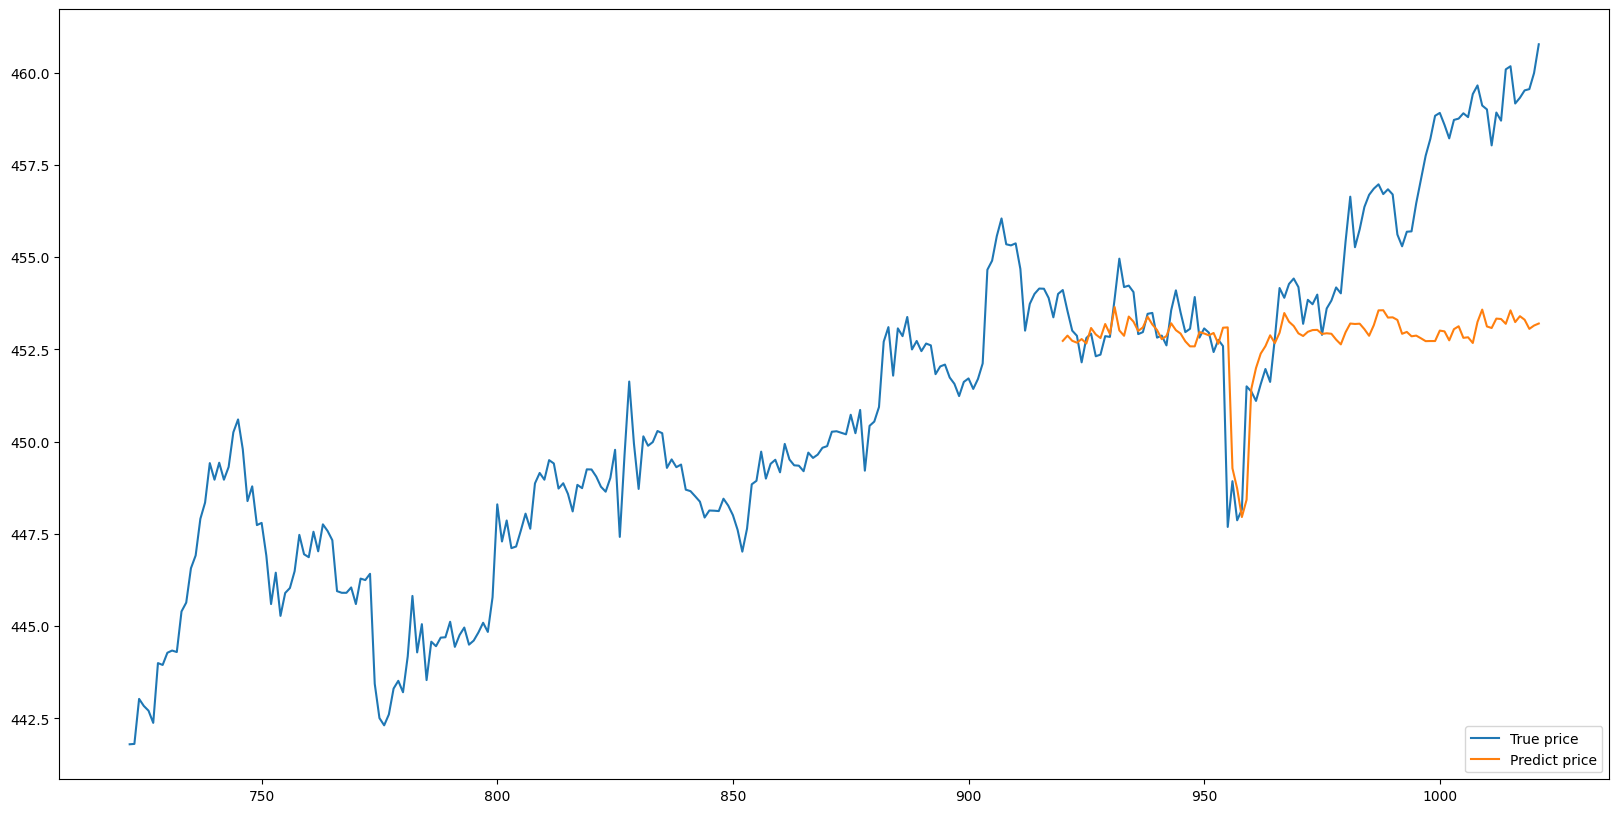

In [215]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [216]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close   volume       ROC
0     412.404999   601363  0.100733
1     412.489990   323742  0.016967
2     412.750000   265613  0.157727
3     412.769989   245015  0.147997
4     412.279999   228841 -0.016978
...          ...      ...       ...
1017  459.320007   320324  0.091526
1018  459.519989   321503  0.157757
1019  459.554993   407814  0.029380
1020  459.989990   464931  0.072879
1021  460.769989  1397683  0.361570

[1022 rows x 3 columns]

In [217]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\666477088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\666477088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\666477088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

close   volume       ROC  close_date_1  volume_date_1  ROC_date_1  \
0     412.404999   601363  0.100733           NaN            NaN         NaN   
1     412.489990   323742  0.016967    412.404999       601363.0    0.100733   
2     412.750000   265613  0.157727    412.489990       323742.0    0.016967   
3     412.769989   245015  0.147997    412.750000       265613.0    0.157727   
4     412.279999   228841 -0.016978    412.769989       245015.0    0.147997   
...          ...      ...       ...           ...            ...         ...   
1017  459.320007   320324  0.091526    459.165009       372943.0    0.089133   
1018  459.519989   321503  0.157757    459.320007       320324.0    0.091526   
1019  459.554993   407814  0.029380    459.519989       321503.0    0.157757   
1020  459.989990   464931  0.072879    459.554993       407814.0    0.029380   
1021  460.769989  1397683  0.361570    459.989990       464931.0    0.072879   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2       412.404999       601363.0    0.100733  
3       412.489990       323742.0    0.016967  
4       412.750000       265613.0    0.157727  
...            ...            ...         ...  
1017    460.174988       356632.0    0.317184  
1018    459.165009       372943.0    0.089133  
1019    459.320007       320324.0    0.091526  
1020    459.519989       321503.0    0.157757  
1021    459.554993       407814.0    0.029380  

[1022 rows x 9 columns]

In [218]:
dataset.dropna(inplace=True)
dataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close   volume       ROC  close_date_1  volume_date_1  ROC_date_1  \
2     412.750000   265613  0.157727    412.489990       323742.0    0.016967   
3     412.769989   245015  0.147997    412.750000       265613.0    0.157727   
4     412.279999   228841 -0.016978    412.769989       245015.0    0.147997   
5     412.350006   227200 -0.311867    412.279999       228841.0   -0.016978   
6     411.920013   314112 -0.002667    412.350006       227200.0   -0.311867   
...          ...      ...       ...           ...            ...         ...   
1017  459.320007   320324  0.091526    459.165009       372943.0    0.089133   
1018  459.519989   321503  0.157757    459.320007       320324.0    0.091526   
1019  459.554993   407814  0.029380    459.519989       321503.0    0.157757   
1020  459.989990   464931  0.072879    459.554993       407814.0    0.029380   
1021  460.769989  1397683  0.361570    459.989990       464931.0    0.072879   

      close_date_2  volume_date_2  ROC_date_2  
2       412.404999       601363.0    0.100733  
3       412.489990       323742.0    0.016967  
4       412.750000       265613.0    0.157727  
5       412.769989       245015.0    0.147997  
6       412.279999       228841.0   -0.016978  
...            ...            ...         ...  
1017    460.174988       356632.0    0.317184  
1018    459.165009       372943.0    0.089133  
1019    459.320007       320324.0    0.091526  
1020    459.519989       321503.0    0.157757  
1021    459.554993       407814.0    0.029380  

[1020 rows x 9 columns]

In [219]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1020, 6)
(1020, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2       412.489990       323742.0    0.016967    412.404999       601363.0   
3       412.750000       265613.0    0.157727    412.489990       323742.0   
4       412.769989       245015.0    0.147997    412.750000       265613.0   
5       412.279999       228841.0   -0.016978    412.769989       245015.0   
6       412.350006       227200.0   -0.311867    412.279999       228841.0   
...            ...            ...         ...           ...            ...   
1017    459.165009       372943.0    0.089133    460.174988       356632.0   
1018    459.320007       320324.0    0.091526    459.165009       372943.0   
1019    459.519989       321503.0    0.157757    459.320007       320324.0   
1020    459.554993       407814.0    0.029380    459.519989       321503.0   
1021    459.989990       464931.0    0.072879    459.554993       407814.0   

      ROC_date_2  
2       0.100733  
3       0.016967  
4       0.157727  
5       0.147997  
6      -0.016978  
...          ...  
1017    0.317184  
1018    0.089133  
1019    0.091526  
1020    0.157757  
1021    0.029380  

[1020 rows x 6 columns]

In [220]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (918, 6)
Size test:  (102, 6)


In [221]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [222]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [223]:
predictions = model_xgboost.predict(X_test)
predictions

array([452.22787, 452.10822, 452.09827, 452.23526, 452.1813 , 452.32727,
       452.553  , 452.38138, 452.32233, 452.47397, 452.34097, 453.2347 ,
       452.91345, 452.76624, 453.2667 , 453.3386 , 452.68097, 453.05038,
       452.93253, 452.61575, 452.82266, 452.31778, 453.0443 , 452.25186,
       452.7467 , 452.96127, 452.85703, 452.1316 , 452.04904, 452.72464,
       452.5764 , 452.62686, 452.5491 , 452.48093, 452.74506, 452.83624,
       448.90378, 448.2125 , 447.80222, 448.169  , 450.77267, 451.93076,
       451.90167, 451.89417, 452.10657, 452.3073 , 452.6924 , 452.96182,
       453.12656, 452.99908, 452.80093, 452.97165, 452.39197, 453.0415 ,
       452.8496 , 452.64008, 452.4696 , 452.81445, 452.4195 , 452.53055,
       452.62308, 453.00174, 453.1752 , 452.89194, 453.00436, 452.67987,
       453.34152, 453.45264, 453.60812, 453.59995, 453.41083, 453.30588,
       452.38437, 452.42126, 452.9314 , 452.58502, 452.44125, 452.47244,
       452.58682, 452.42868, 452.68985, 452.83875, 

In [224]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close   volume       ROC  close_date_1  volume_date_1  ROC_date_1  \
920   454.109985   201175 -0.272323    454.004211       225816.0   -0.448586   
921   453.540009   200151 -0.390934    454.109985       201175.0   -0.272323   
922   453.010010   267891 -0.519350    453.540009       200151.0   -0.390934   
923   452.869995   200488 -0.398082    453.010010       267891.0   -0.519350   
924   452.149994   303375 -0.189845    452.869995       200488.0   -0.398082   
...          ...      ...       ...           ...            ...         ...   
1017  459.320007   320324  0.091526    459.165009       372943.0    0.089133   
1018  459.519989   321503  0.157757    459.320007       320324.0    0.091526   
1019  459.554993   407814  0.029380    459.519989       321503.0    0.157757   
1020  459.989990   464931  0.072879    459.554993       407814.0    0.029380   
1021  460.769989  1397683  0.361570    459.989990       464931.0    0.072879   

      close_date_2  volume_date_2  ROC_date_2  predictions  
920     453.369995       191192.0   -0.483461   452.227875  
921     454.004211       225816.0   -0.448586   452.108215  
922     454.109985       201175.0   -0.272323   452.098267  
923     453.540009       200151.0   -0.390934   452.235260  
924     453.010010       267891.0   -0.519350   452.181305  
...            ...            ...         ...          ...  
1017    460.174988       356632.0    0.317184   452.799561  
1018    459.165009       372943.0    0.089133   452.622681  
1019    459.320007       320324.0    0.091526   452.661560  
1020    459.519989       321503.0    0.157757   453.132172  
1021    459.554993       407814.0    0.029380   453.180328  

[102 rows x 10 columns]

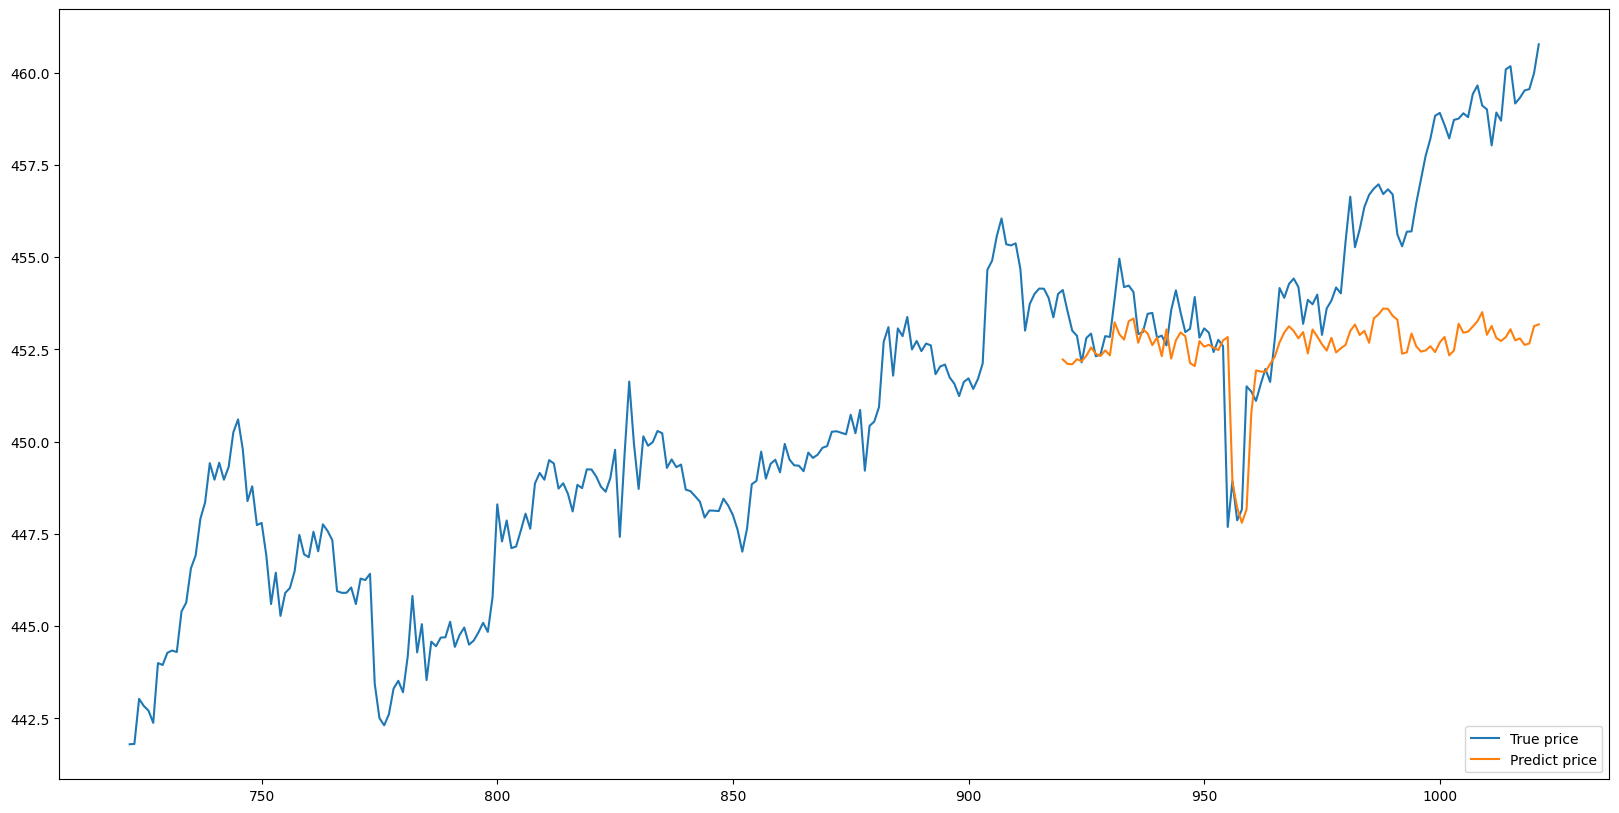

In [225]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4093949877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4093949877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4093949877.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

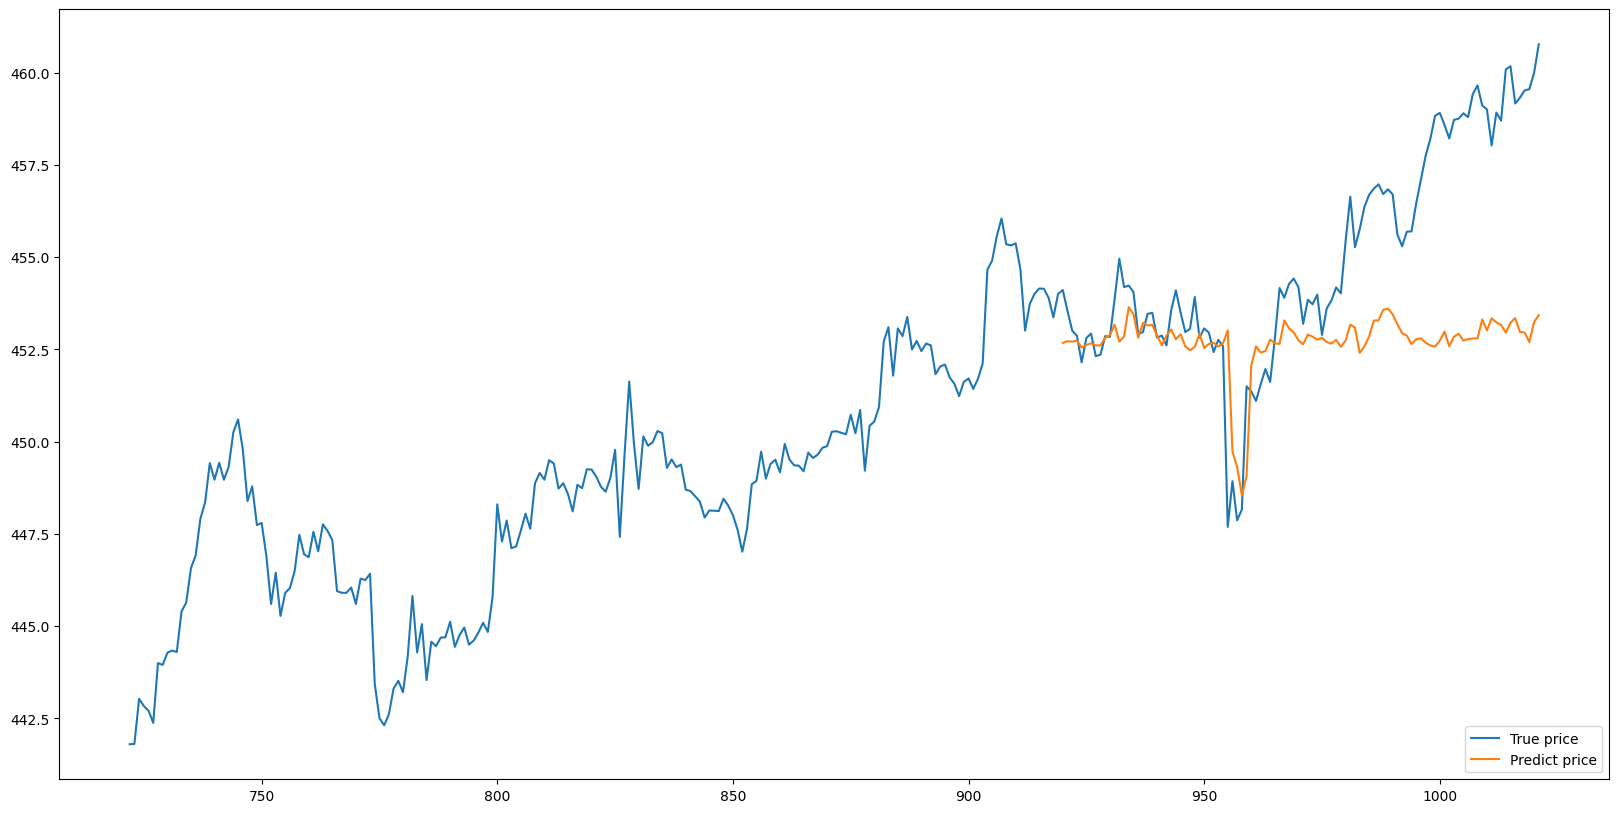

In [226]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\599475182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\599475182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\599475182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

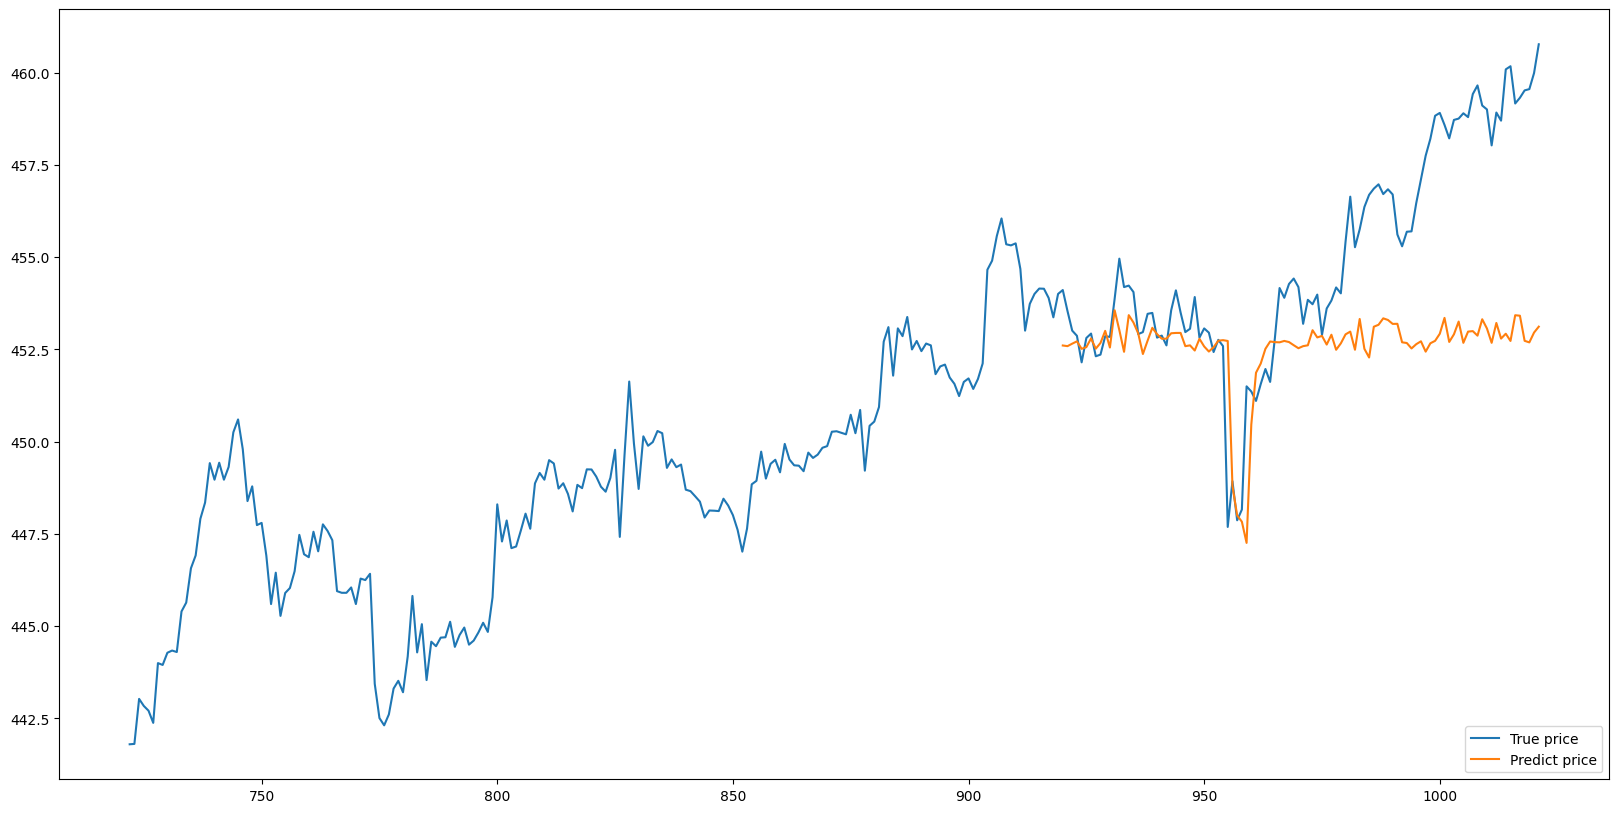

In [227]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4005043941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4005043941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4005043941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

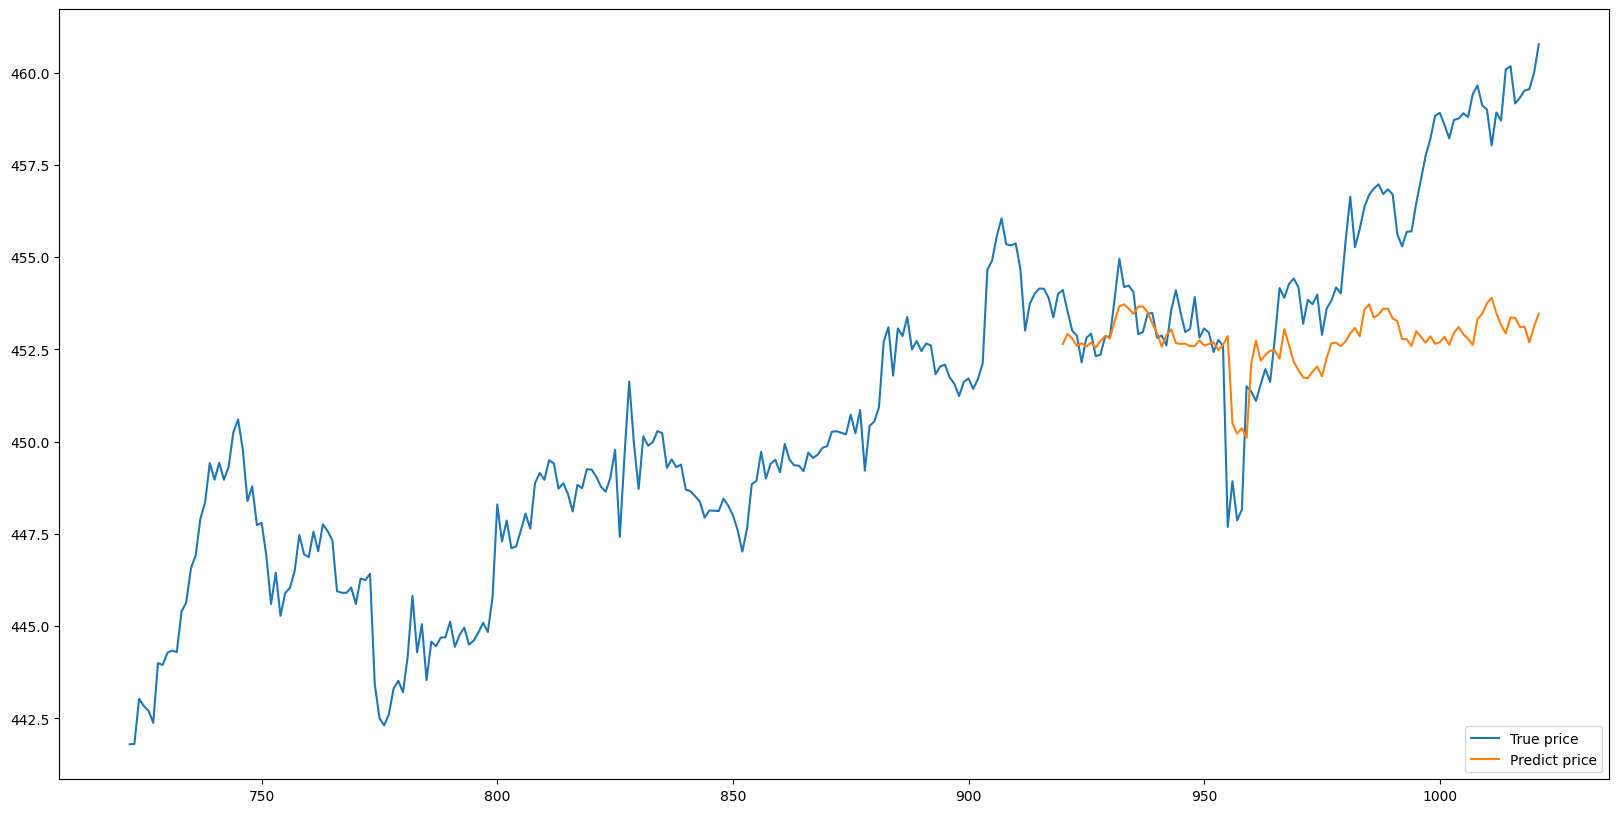

In [228]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4143684539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4143684539.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\4143684539.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

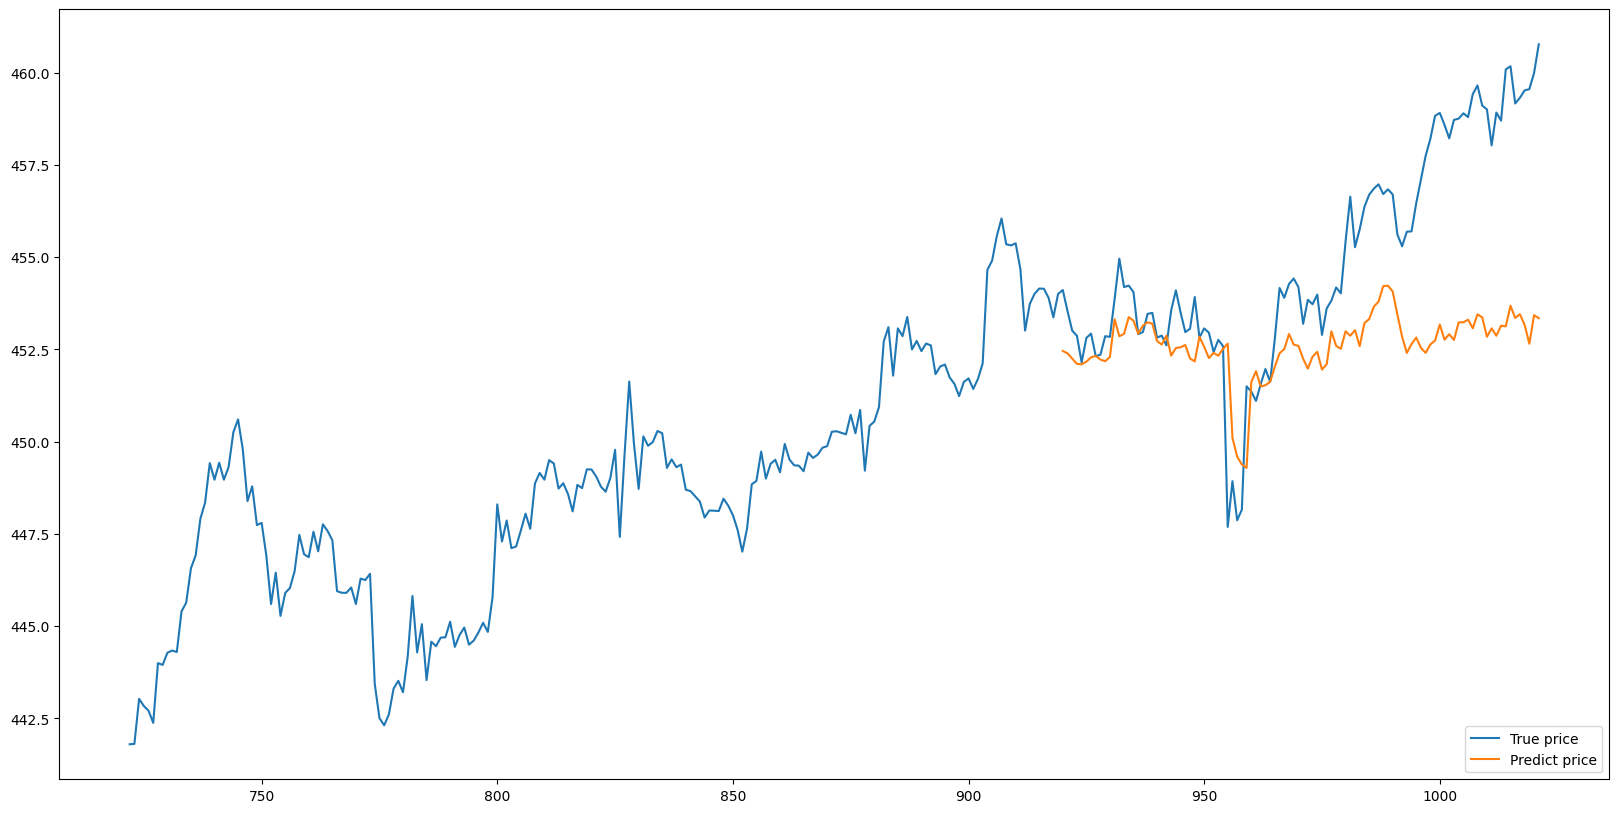

In [229]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\371623579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\371623579.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\371623579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

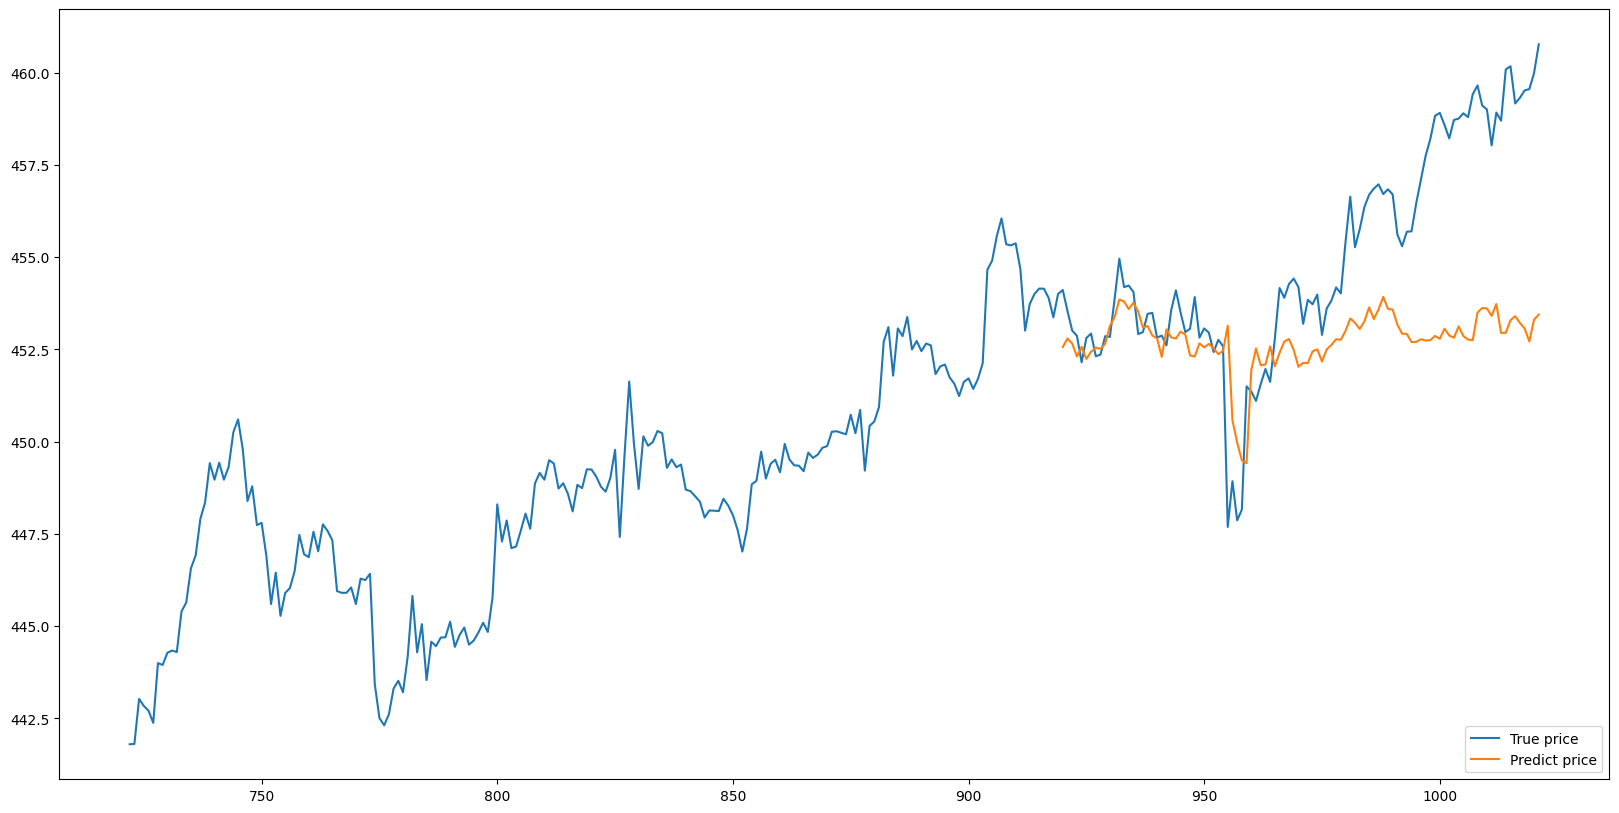

In [230]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1010537535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1010537535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1010537535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

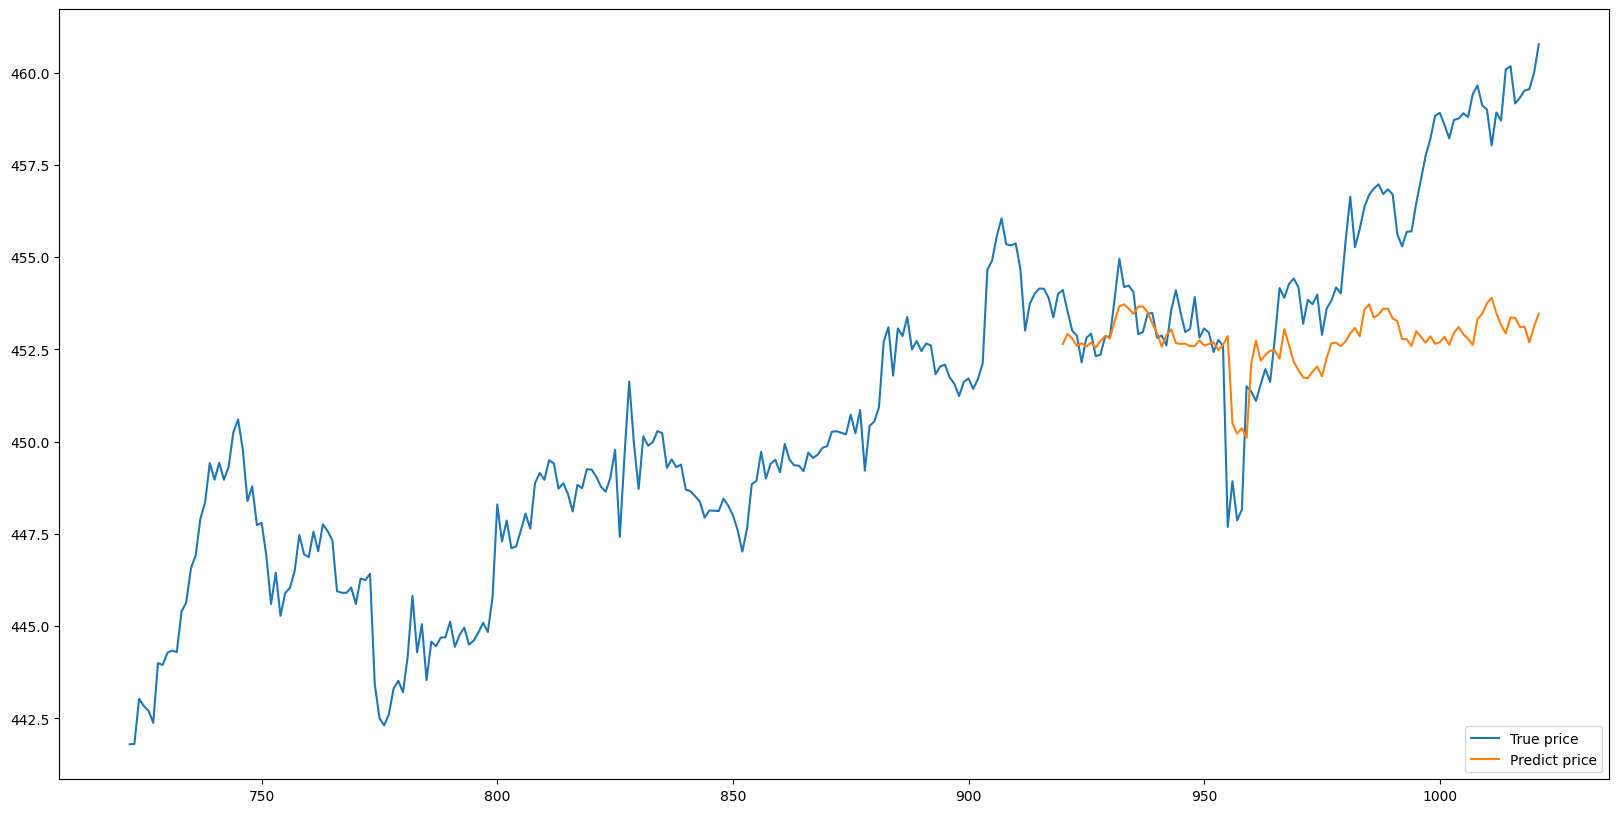

In [231]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\144573520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\144573520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\144573520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

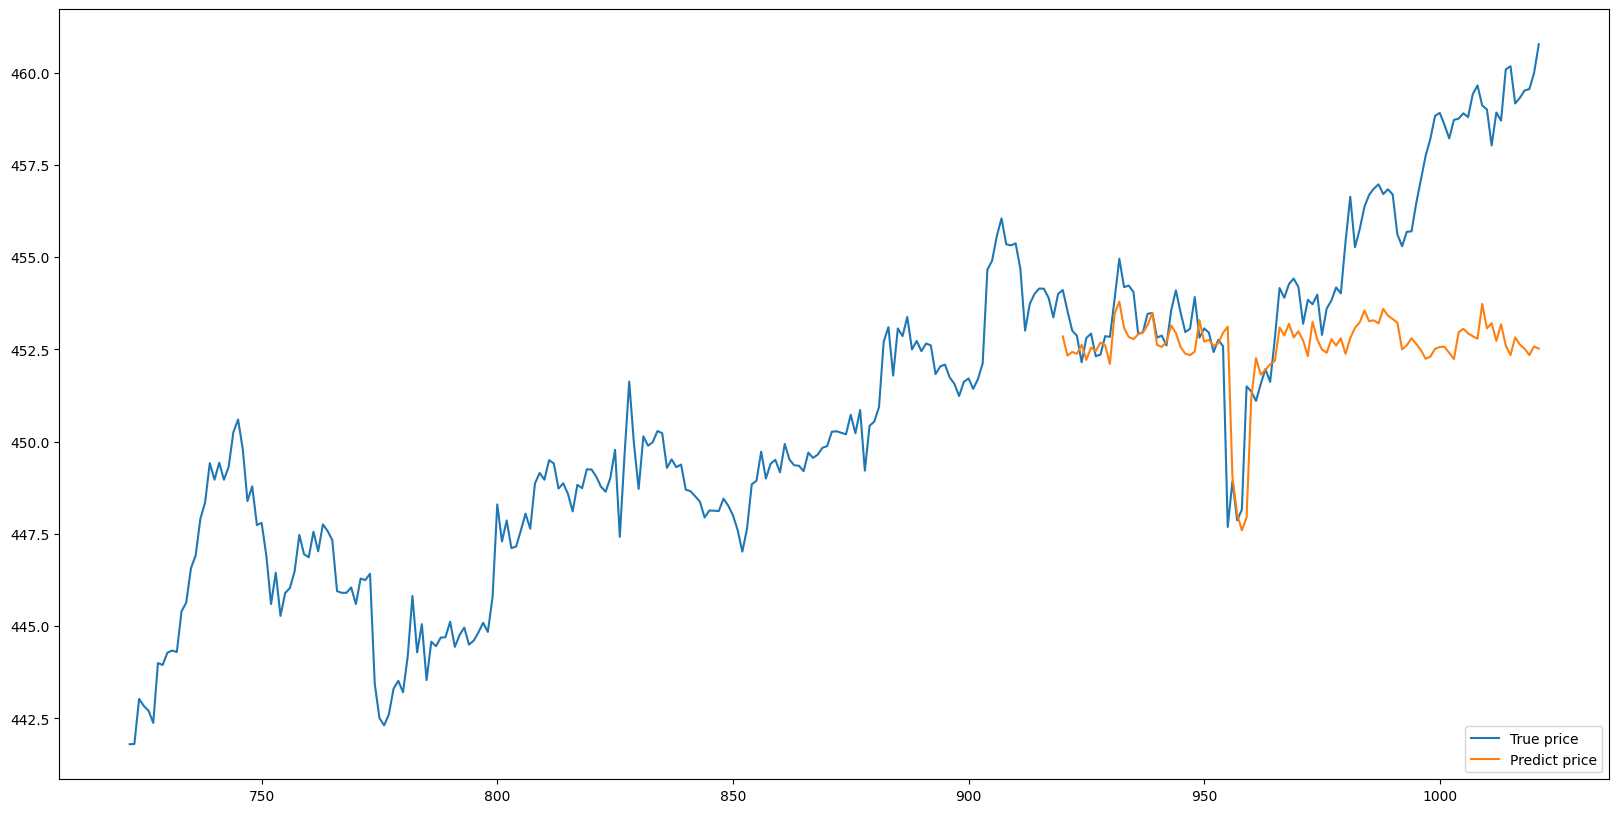

In [232]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2866562134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2866562134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2866562134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

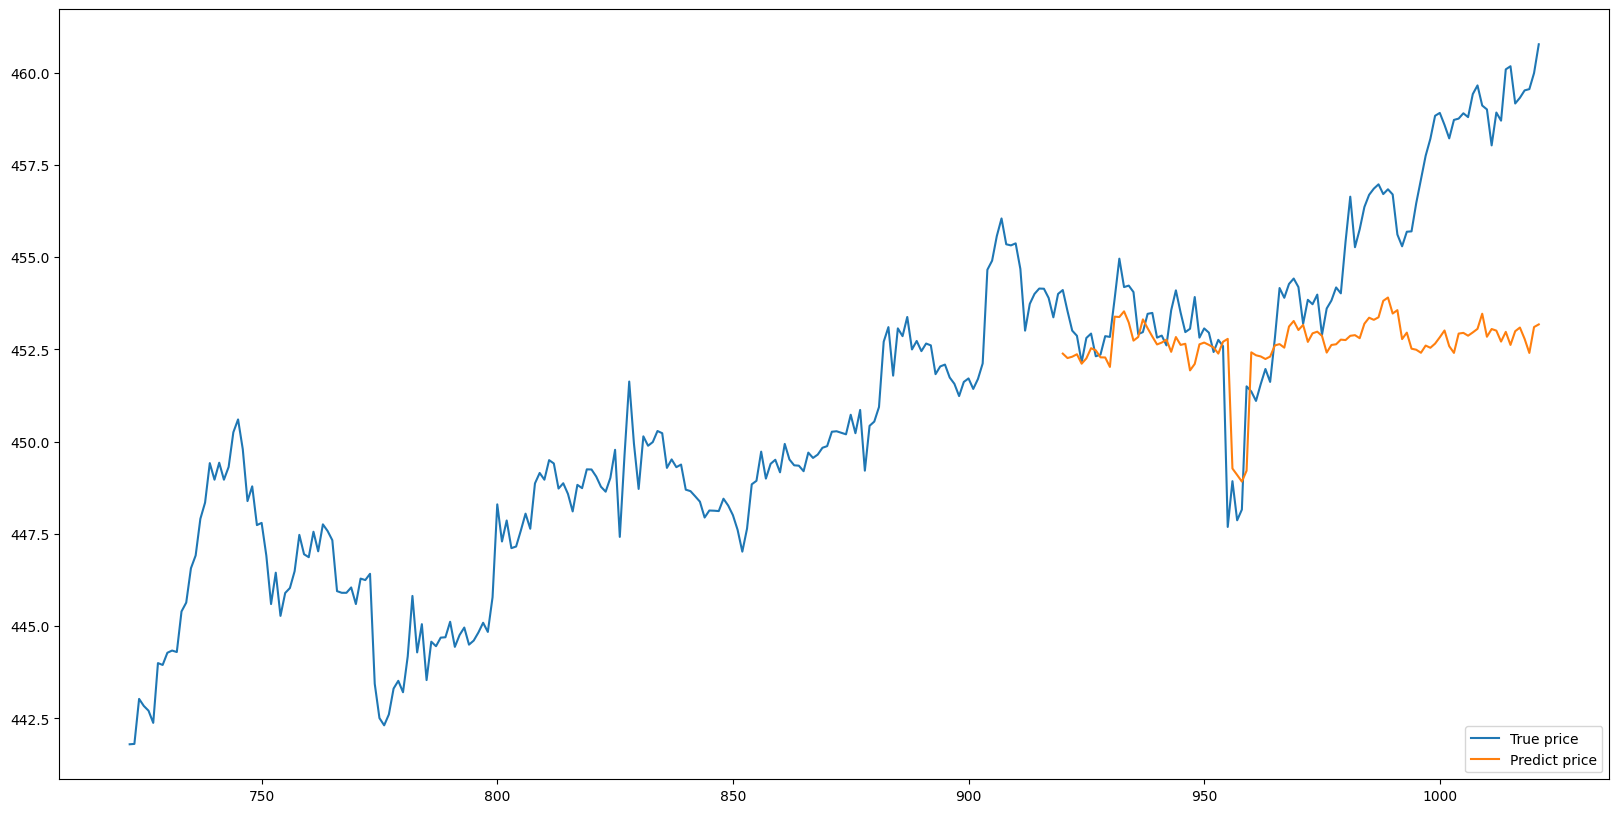

In [233]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\803041197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\803041197.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\803041197.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

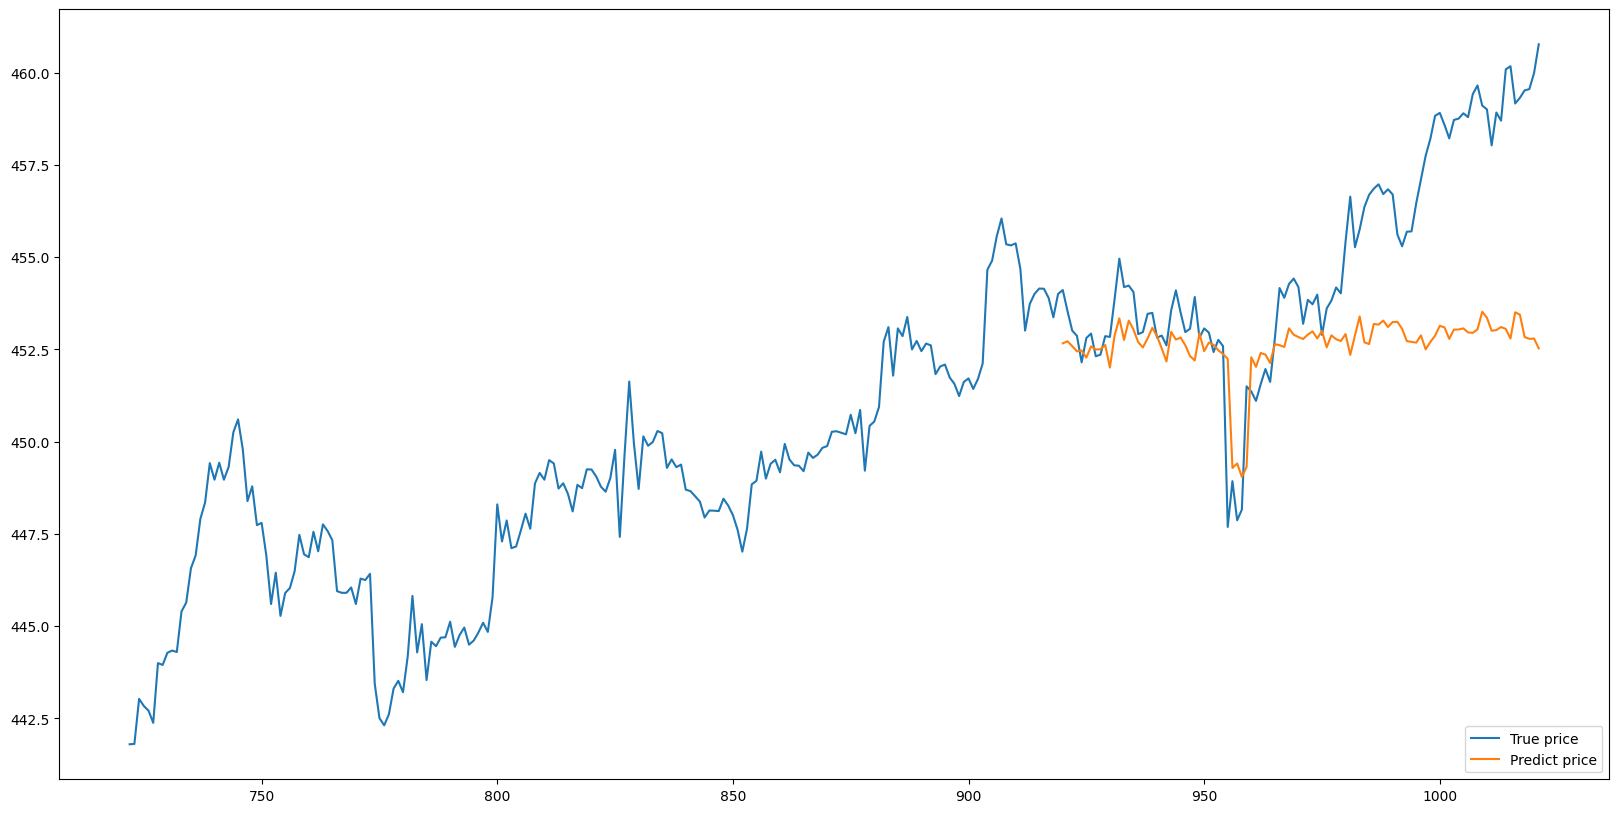

In [234]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

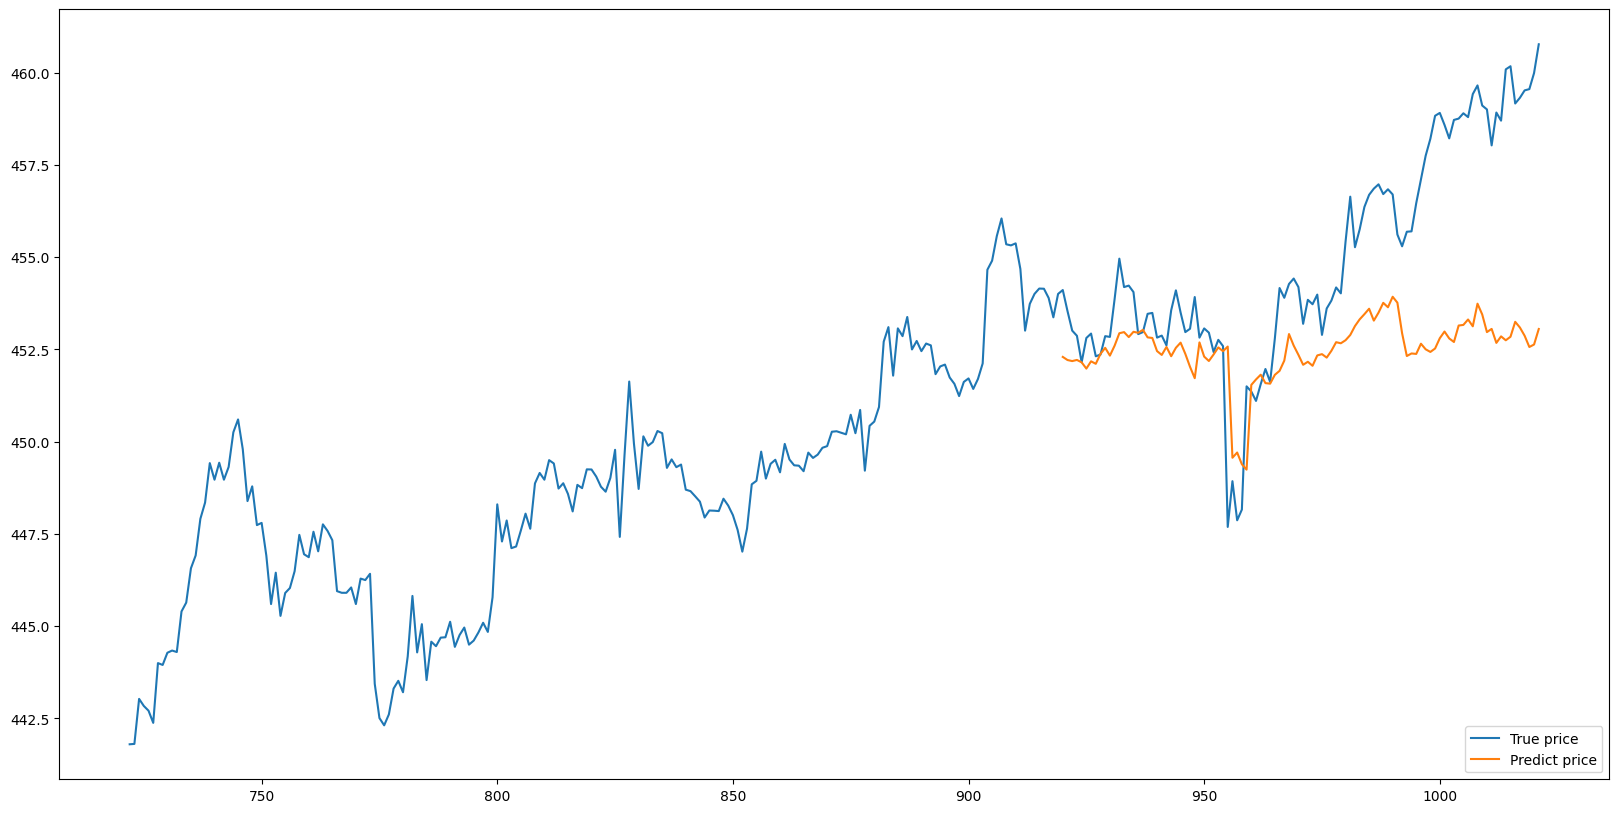

In [235]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1224954108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

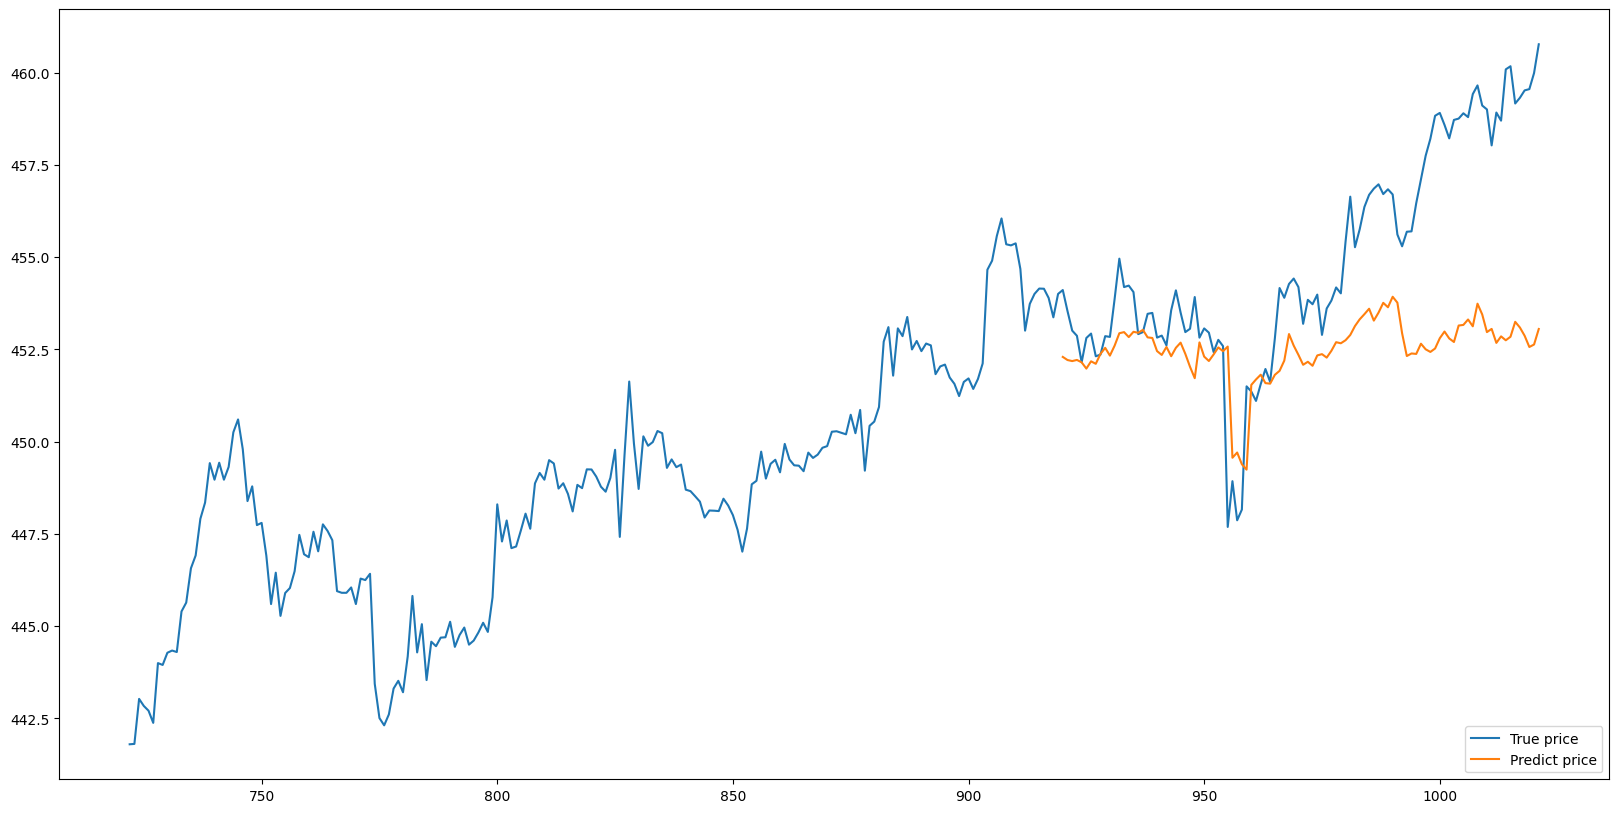

In [236]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\580329412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\580329412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\580329412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

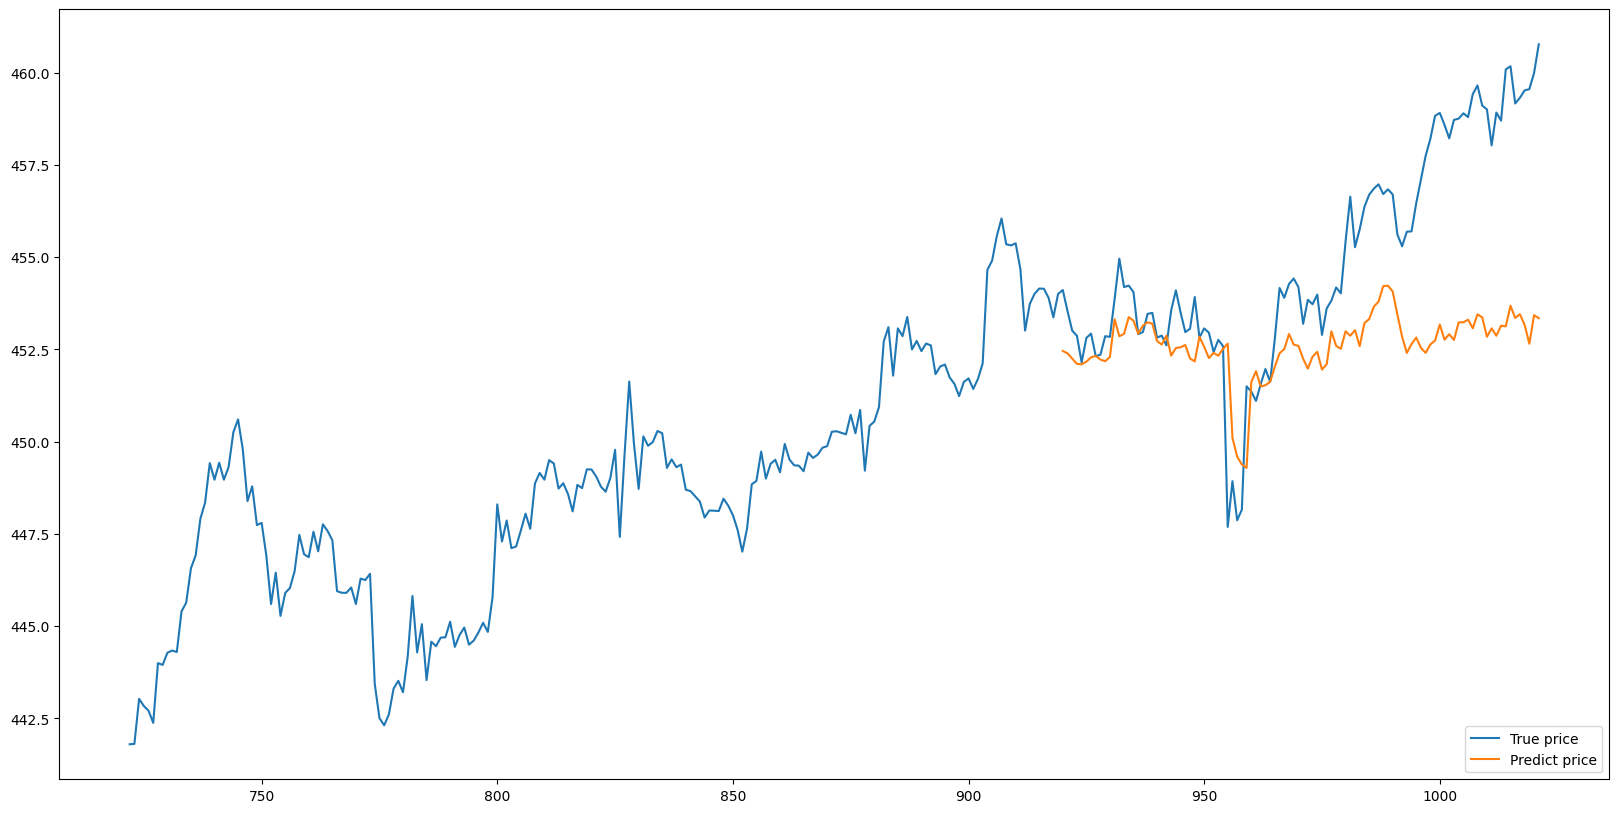

In [237]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2353105684.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2353105684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\2353105684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

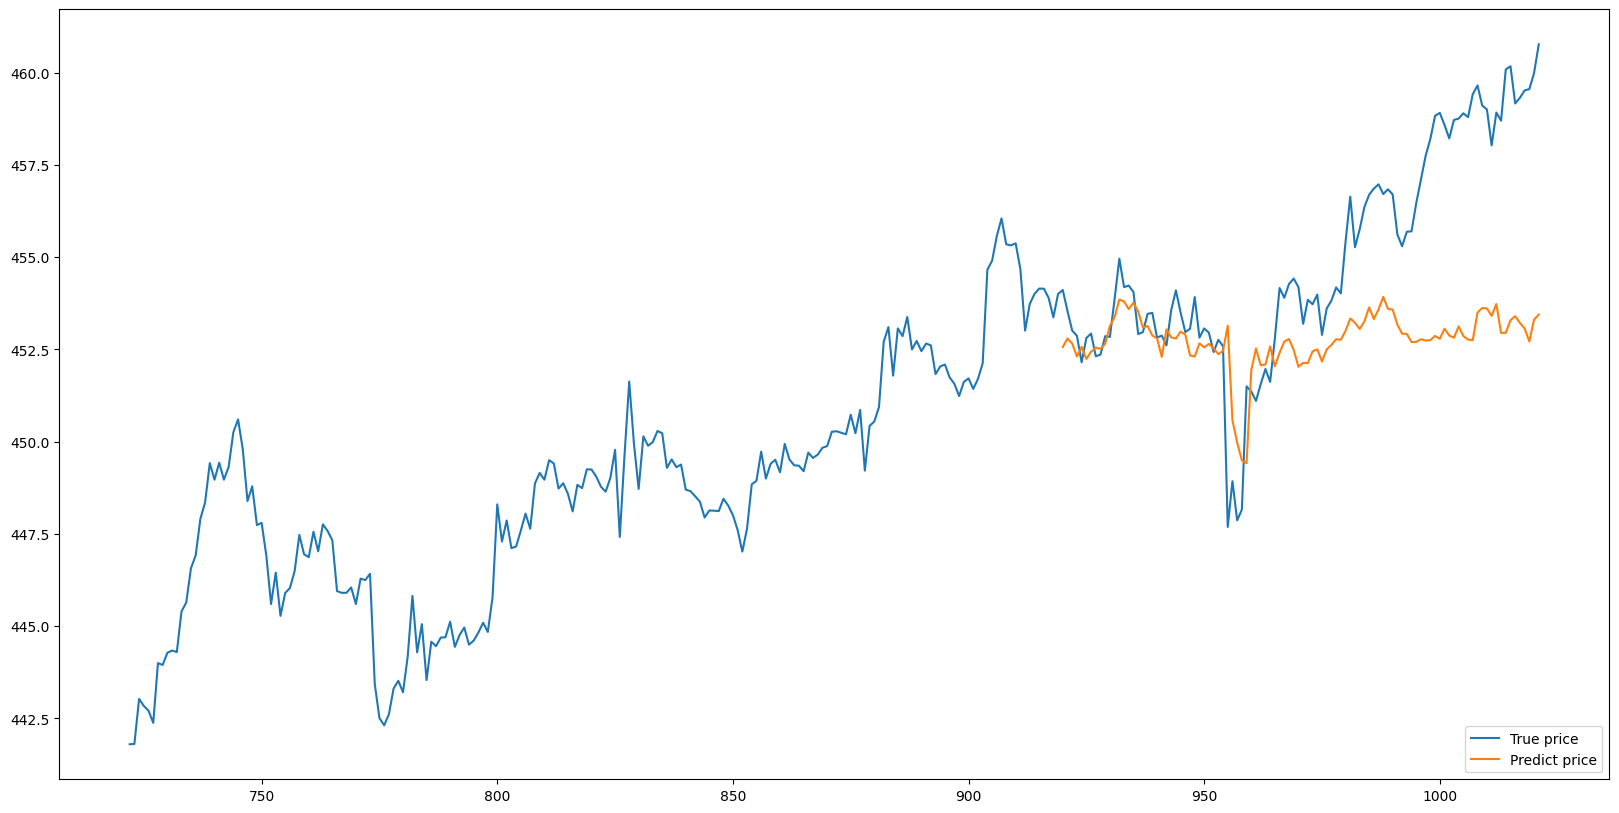

In [238]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3029990397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3029990397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\3029990397.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

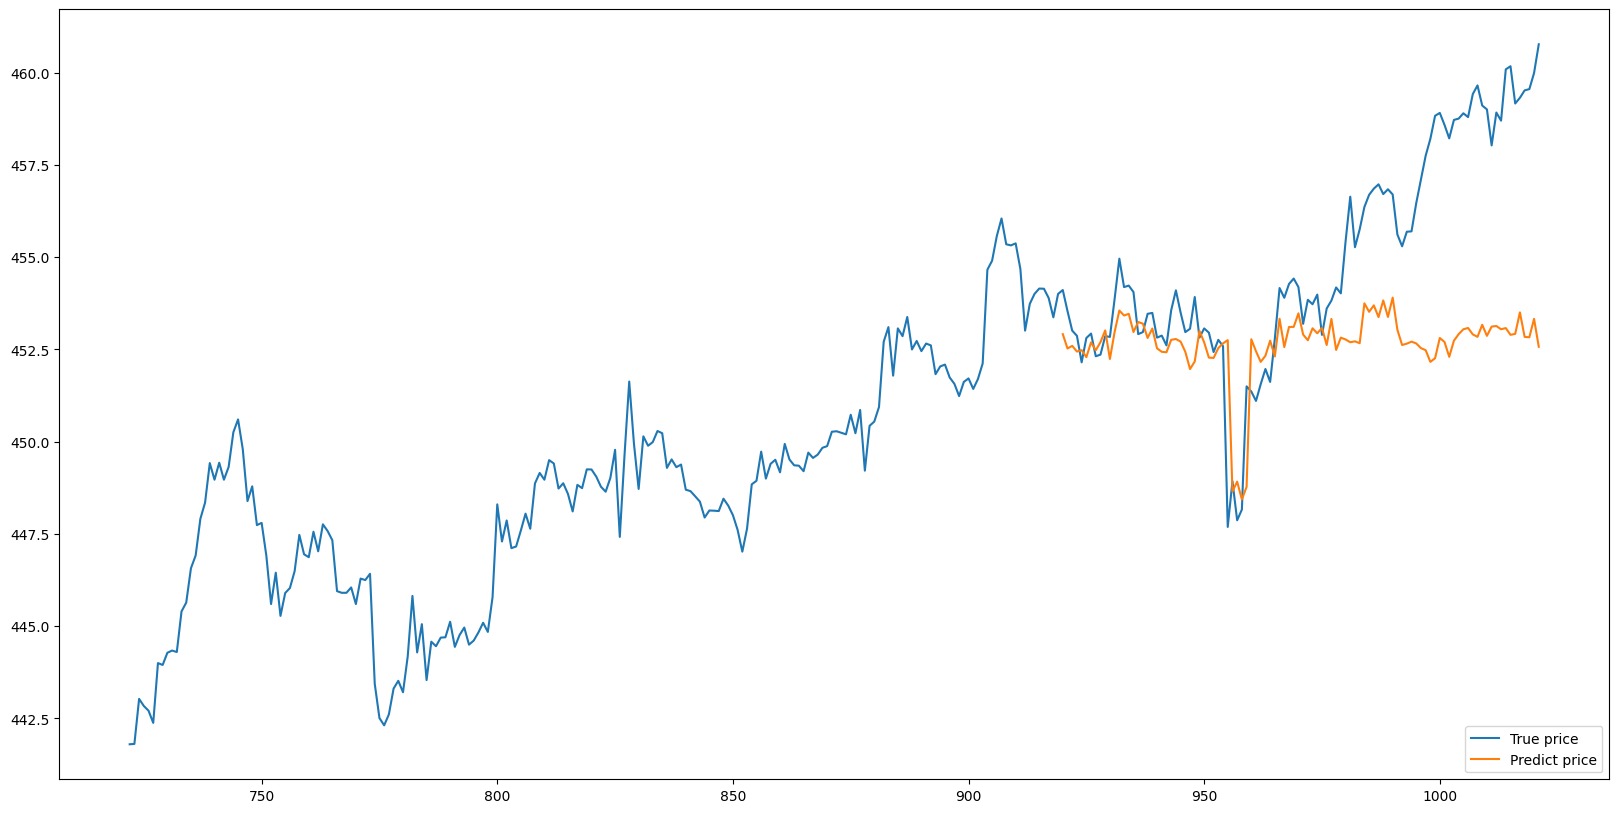

In [239]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1276790690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1276790690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16712\1276790690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

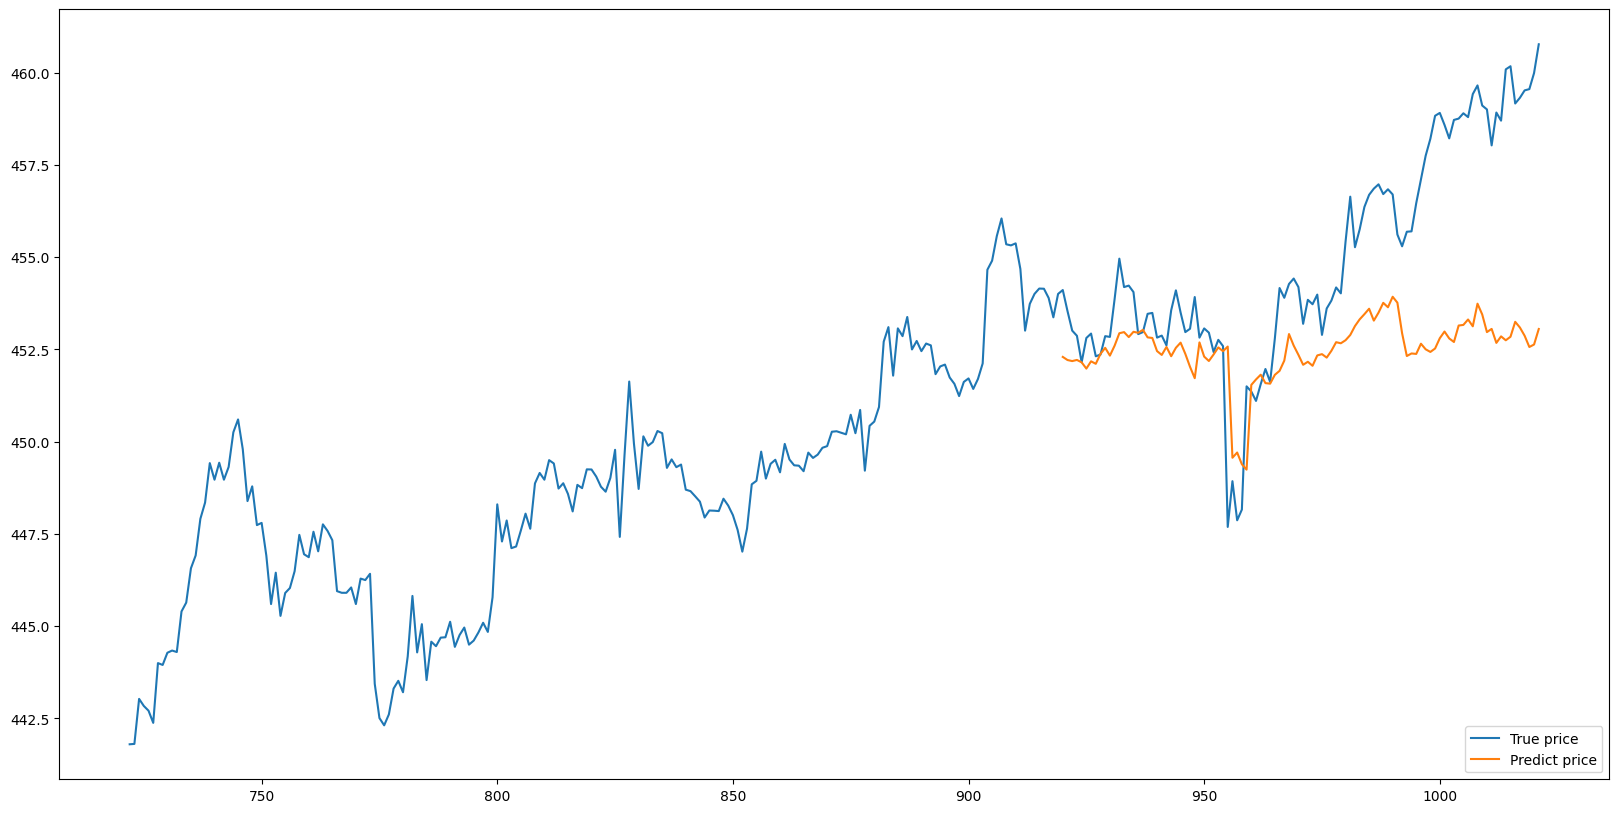

In [240]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [241]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue